In [ ]:
# Enhanced feature importance analysis
def analyze_feature_importance_for_symbol(model, X_test, y_test, feature_names, symbol):
    """Analyze feature importance using permutation importance"""
    from sklearn.inspection import permutation_importance
    
    # Convert model predictions to class labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate baseline accuracy
    baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")
    
    # Reshape X_test for sklearn compatibility
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    
    # Calculate permutation importance
    result = permutation_importance(
        lambda x: np.argmax(model.predict(x.reshape(-1, X_test.shape[1], X_test.shape[2])), axis=1),
        X_test_reshaped,
        y_test_classes,
        n_repeats=10,
        random_state=42,
        scoring='accuracy'
    )
    
    # Create DataFrame with importance scores
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
    plt.xlabel('Permutation Importance (decrease in accuracy)')
    plt.title(f'Feature Importance for {symbol} (Top 20)')
    plt.tight_layout()
    #plt.savefig(f"{symbol}_feature_importance.png")
    plt.show()
    
    return importance_df
def detect_market_regime(df, window=60):
    """Detect market regime based on volatility and trend"""
    # Calculate rolling volatility
    df['volatility'] = df['Returns'].rolling(window=window).std() * np.sqrt(252)
    
    # Calculate rolling trend (slope of linear regression)
    def rolling_slope(series, window):
        slopes = []
        for i in range(len(series) - window + 1):
            x = np.arange(window)
            y = series.iloc[i:i+window].values
            slope, _, _, _, _ = linregress(x, y)
            slopes.append(slope)
        return pd.Series(np.nan, index=series.index).iloc[window-1:].combine_first(pd.Series(slopes, index=series.index[window-1:len(slopes)+window-1]))
    
    df['trend'] = rolling_slope(df['Close'], window)
    
    # Classify regimes
    # High volatility, positive trend = 'Bull Volatile'
    # High volatility, negative trend = 'Bear Volatile'
    # Low volatility, positive trend = 'Bull Stable'
    # Low volatility, negative trend = 'Bear Stable'
    
    volatility_threshold = df['volatility'].mean() + 0.5 * df['volatility'].std()
    
    df['regime'] = np.where(
        df['volatility'] > volatility_threshold,
        np.where(df['trend'] > 0, 'Bull Volatile', 'Bear Volatile'),
        np.where(df['trend'] > 0, 'Bull Stable', 'Bear Stable')
    )
    
    return df
def evaluate_signal_quality(signals, prediction_horizon=5):
    """Evaluate signal quality using future price movements"""
    # Calculate future returns for different horizons
    for days in range(1, prediction_horizon + 1):
        signals[f'future_return_{days}d'] = signals['price'].pct_change(periods=days).shift(-days)
    
    # Evaluate buy signals
    buy_signals = signals[signals['position'] == 1]
    if len(buy_signals) > 0:
        buy_accuracy = {}
        for days in range(1, prediction_horizon + 1):
            buy_accuracy[days] = np.mean(buy_signals[f'future_return_{days}d'] > 0)
        
        print("Buy Signal Quality:")
        for days, acc in buy_accuracy.items():
            print(f"  {days}-day accuracy: {acc:.4f}")
    
    # Evaluate sell signals
    sell_signals = signals[signals['position'] == -1]
    if len(sell_signals) > 0:
        sell_accuracy = {}
        for days in range(1, prediction_horizon + 1):
            sell_accuracy[days] = np.mean(sell_signals[f'future_return_{days}d'] < 0)
        
        print("Sell Signal Quality:")
        for days, acc in sell_accuracy.items():
            print(f"  {days}-day accuracy: {acc:.4f}")
    
    # Calculate signal timeliness (how early signals are generated)
    # For buy signals: how many days before a significant uptrend
    # For sell signals: how many days before a significant downtrend
    
    # Define significant moves (e.g., 2% in 5 days)
    threshold = 0.02
    
    signals['significant_up'] = np.max([signals[f'future_return_{days}d'] > threshold 
                                        for days in range(1, prediction_horizon + 1)], axis=0)
    signals['significant_down'] = np.max([signals[f'future_return_{days}d'] < -threshold 
                                          for days in range(1, prediction_horizon + 1)], axis=0)
    
    # Return signal quality metrics
    signal_metrics = {
        'buy_precision': buy_accuracy[1] if len(buy_signals) > 0 else 0,
        'sell_precision': sell_accuracy[1] if len(sell_signals) > 0 else 0,
        'buy_signals_count': len(buy_signals),
        'sell_signals_count': len(sell_signals),
        'buy_win_rate': np.mean(buy_signals['strategy_return'] > 0) if len(buy_signals) > 0 else 0,
        'sell_win_rate': np.mean(sell_signals['strategy_return'] > 0) if len(sell_signals) > 0 else 0
    }
    
    return signal_metrics
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """Tune hyperparameters using grid search"""
    param_grid = {
        'filters': [[64, 128, 256], [128, 256, 512]],
        'lstm_units': [[64, 32], [128, 64]],
        'dropout_rates': [[0.3, 0.4, 0.5], [0.2, 0.3, 0.4]],
        'learning_rates': [0.001, 0.0005, 0.0001]
    }
    
    best_val_accuracy = 0
    best_params = None
    results = []
    
    # Simple grid search implementation
    for filters in param_grid['filters']:
        for lstm_units in param_grid['lstm_units']:
            for dropout_rates in param_grid['dropout_rates']:
                for lr in param_grid['learning_rates']:
                    print(f"Testing: filters={filters}, lstm_units={lstm_units}, "
                          f"dropout={dropout_rates}, lr={lr}")
                    
                    # Build model with current parameters
                    input_shape = (X_train.shape[1], X_train.shape[2])
                    model = build_model_with_params(
                        input_shape, 
                        filters=filters,
                        lstm_units=lstm_units,
                        dropout_rates=dropout_rates,
                        learning_rate=lr
                    )
                    
                    # Train with early stopping
                    early_stopping = EarlyStopping(
                        monitor='val_accuracy', 
                        patience=10,
                        restore_best_weights=True
                    )
                    
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,  # Reduced epochs for hyperparameter search
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=0
                    )
                    
                    # Get best validation accuracy
                    val_accuracy = max(history.history['val_accuracy'])
                    print(f"Validation accuracy: {val_accuracy:.4f}")
                    
                    # Track results
                    results.append({
                        'filters': filters,
                        'lstm_units': lstm_units,
                        'dropout_rates': dropout_rates,
                        'learning_rate': lr,
                        'val_accuracy': val_accuracy
                    })
                    
                    # Update best parameters
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {
                            'filters': filters,
                            'lstm_units': lstm_units,
                            'dropout_rates': dropout_rates,
                            'learning_rate': lr
                        }
    
    print(f"Best parameters: {best_params}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    return best_params, pd.DataFrame(results)
def optimize_decision_thresholds(model, X_val, y_val, df_val):
    """Optimize decision thresholds for trading signals"""
    # Get predictions
    y_pred_proba = model.predict(X_val)
    
    # Initialize variables
    best_sharpe = 0
    best_threshold_up = 0.5
    best_threshold_down = 0.5
    
    # Grid search over thresholds
    for threshold_up in np.arange(0.5, 0.95, 0.05):
        for threshold_down in np.arange(0.5, 0.95, 0.05):
            # Generate signals with current thresholds
            signals = pd.DataFrame(index=range(len(y_pred_proba)))
            signals['pred_down_prob'] = y_pred_proba[:, 0]
            signals['pred_neutral_prob'] = y_pred_proba[:, 1]
            signals['pred_up_prob'] = y_pred_proba[:, 2]
            
            # Apply thresholds
            signals['position'] = 0  # Default is no position
            signals.loc[signals['pred_up_prob'] > threshold_up, 'position'] = 1  # Long
            signals.loc[signals['pred_down_prob'] > threshold_down, 'position'] = -1  # Short
            
            # Add price data
            if len(df_val) >= len(signals):
                signals['price'] = df_val['Close'].values[:len(signals)]
                
                # Calculate returns
                signals['market_return'] = np.log(signals['price'] / signals['price'].shift(1))
                signals['strategy_return'] = signals['position'].shift(1) * signals['market_return']
                
                # Calculate Sharpe ratio
                sharpe_ratio = np.sqrt(252) * signals['strategy_return'].mean() / signals['strategy_return'].std() if signals['strategy_return'].std() > 0 else 0
                
                # Update best thresholds
                if sharpe_ratio > best_sharpe:
                    best_sharpe = sharpe_ratio
                    best_threshold_up = threshold_up
                    best_threshold_down = threshold_down
    
    print(f"Best thresholds: Up={best_threshold_up:.2f}, Down={best_threshold_down:.2f}")
    print(f"Best Sharpe ratio: {best_sharpe:.4f}")
    
    return best_threshold_up, best_threshold_down

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import linregress
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dynamic Class Weight Callback (assumed from original code)
class DynamicClassWeightCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, initial_weights, adjustment_factor=0.05):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.class_weights = initial_weights.copy()
        self.adjustment_factor = adjustment_factor

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_train)
        y_true = np.argmax(self.y_train, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        errors = y_true != y_pred_classes
        for cls in self.class_weights:
            class_mask = (y_true == cls)
            error_rate = np.mean(errors[class_mask]) if np.any(class_mask) else 0
            self.class_weights[cls] *= (1 + self.adjustment_factor * error_rate)
        self.model.class_weight = self.class_weights

# Preprocess Stock Data
def preprocess_stock_data(df):
    """Preprocess stock data by handling missing values and creating target labels."""
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.fillna(0, inplace=True)
    threshold = 0.003  # Threshold for classifying Up/Down movements
    df['target'] = np.where(df['Returns'].shift(-1) > threshold, 2,  # Up
                           np.where(df['Returns'].shift(-1) < -threshold, 0, 1))  # Down, Neutral
    df = df.dropna(subset=['target'])
    df['target'] = df['target'].astype(int)
    return df

# Feature Selection with Mutual Information
def select_features_with_mi(df, features, target_col='target', n_select=30):
    """Select top features using mutual information."""
    data = df.dropna(subset=[target_col])
    mi_scores = mutual_info_classif(data[features], data[target_col])
    mi_df = pd.DataFrame({'Feature': features, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values('MI Score', ascending=False)
    print("Top 15 features by mutual information:")
    print(mi_df.head(15))
    return mi_df.head(n_select)['Feature'].tolist()

# Prepare Multi-Sequence Data
def prepare_multi_sequence_data(df, sequence_lengths, target_column, feature_columns):
    """Prepare sequences of multiple lengths for model input."""
    max_length = max(sequence_lengths)
    X_dict = {length: [] for length in sequence_lengths}
    y = []
    for i in range(max_length, len(df)):
        for length in sequence_lengths:
            X_dict[length].append(df[feature_columns].iloc[i - length:i].values)
        y.append(df[target_column].iloc[i])
    for length in sequence_lengths:
        X_dict[length] = np.array(X_dict[length])
    y = np.array(y)
    return X_dict, y

# Build Multi-Timeframe CNN-BiLSTM Model
def build_multi_timeframe_model(sequence_lengths, num_features, num_classes=3):
    """Build a model with separate branches for each sequence length."""
    inputs = []
    branches = []
    for length in sequence_lengths:
        input_layer = Input(shape=(length, num_features))
        inputs.append(input_layer)
        # CNN Block 1
        conv1 = Conv1D(filters=128, kernel_size=3, padding='same')(input_layer)
        bn1 = BatchNormalization()(conv1)
        act1 = Activation('relu')(bn1)
        pool1 = MaxPooling1D(pool_size=2)(act1)
        drop1 = Dropout(0.2)(pool1)
        # CNN Block 2
        conv2 = Conv1D(filters=256, kernel_size=3, padding='same')(drop1)
        bn2 = BatchNormalization()(conv2)
        act2 = Activation('relu')(bn2)
        pool2 = MaxPooling1D(pool_size=2)(act2)
        drop2 = Dropout(0.3)(pool2)
        # BiLSTM Layers
        lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(drop2)
        drop_lstm1 = Dropout(0.4)(lstm1)
        lstm2 = Bidirectional(LSTM(units=64, return_sequences=False))(drop_lstm1)
        drop_lstm2 = Dropout(0.4)(lstm2)
        branches.append(drop_lstm2)
    # Concatenate branches
    if len(branches) > 1:
        combined = concatenate(branches)
    else:
        combined = branches[0]
    # Dense Layers
    dense1 = Dense(64, activation='relu')(combined)
    drop_dense = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(drop_dense)
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Model with Advanced Techniques
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, symbol=None):
    """Train the model with dynamic class weights and callbacks."""
    y_train_labels = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_labels)
    total_samples = len(y_train_labels)
    class_weights = {i: (total_samples / (len(np.unique(y_train_labels)) * count)) * 1.5 if i != 1 else (total_samples / (len(np.unique(y_train_labels)) * count))
                     for i, count in enumerate(class_counts)}
    dynamic_weights = DynamicClassWeightCallback(X_train, y_train, initial_weights=class_weights, adjustment_factor=0.05)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
        dynamic_weights
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return history, model

# Generate Advanced Trading Signals
def generate_advanced_trading_signals(model, X_test, df_test, confidence_threshold=0.6):
    """Generate trading signals based on model predictions."""
    y_pred_proba = model.predict(X_test)
    signals = pd.DataFrame(index=df_test.index[:len(y_pred_proba)])
    signals['pred_down_prob'] = y_pred_proba[:, 0]
    signals['pred_neutral_prob'] = y_pred_proba[:, 1]
    signals['pred_up_prob'] = y_pred_proba[:, 2]
    signals['predicted_class'] = np.argmax(y_pred_proba, axis=1)
    signals['confidence'] = np.max(y_pred_proba, axis=1)
    signals['position'] = 0
    signals.loc[(signals['predicted_class'] == 2) & (signals['confidence'] > confidence_threshold), 'position'] = 1  # Long
    signals.loc[(signals['predicted_class'] == 0) & (signals['confidence'] > confidence_threshold), 'position'] = -1  # Short
    signals['position_size'] = signals['position'] * (signals['confidence'] - 0.5) * 2
    signals.loc[signals['position_size'] < 0, 'position_size'] = signals['position_size'].abs()
    signals['price'] = df_test['Close'].values[:len(signals)]
    if 'Volatility_20d' in df_test.columns:
        signals['volatility'] = df_test['Volatility_20d'].values[:len(signals)]
        signals['position_size'] = signals['position_size'] / (1 + signals['volatility'] * 10)
    signals['market_return'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_return'] = signals['position'].shift(1) * signals['market_return']
    signals['sized_strategy_return'] = signals['position_size'].shift(1) * signals['market_return']
    signals['cumulative_market_return'] = np.exp(signals['market_return'].cumsum()) - 1
    signals['cumulative_strategy_return'] = np.exp(signals['sized_strategy_return'].cumsum()) - 1
    signals['drawdown'] = signals['cumulative_strategy_return'] - signals['cumulative_strategy_return'].cummax()
    total_return = np.exp(signals['sized_strategy_return'].sum()) - 1
    annual_return = np.exp(signals['sized_strategy_return'].mean() * 252) - 1
    sharpe_ratio = np.sqrt(252) * signals['sized_strategy_return'].mean() / signals['sized_strategy_return'].std()
    max_drawdown = signals['drawdown'].min()
    win_rate = len(signals[signals['sized_strategy_return'] > 0]) / len(signals[signals['sized_strategy_return'] != 0])
    gross_profits = signals.loc[signals['sized_strategy_return'] > 0, 'sized_strategy_return'].sum()
    gross_losses = abs(signals.loc[signals['sized_strategy_return'] < 0, 'sized_strategy_return'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
    performance_metrics = {
        'total_return': total_return,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'profit_factor': profit_factor
    }
    return signals, performance_metrics


# Visualize Trading Performance
def visualize_trading_performance(signals, performance_metrics, symbol_name):
    """Visualize trading performance metrics and signals."""
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    signals['cumulative_market_return'].plot(ax=ax1, label=f'{symbol_name} Return', color='blue', alpha=0.7)
    signals['cumulative_strategy_return'].plot(ax=ax1, label='Strategy Return', color='green')
    ax1.set_title(f'Cumulative Returns Comparison - {symbol_name}')
    ax1.set_ylabel('Return (%)')
    ax1.legend()
    ax1.grid(True)
    ax2 = fig.add_subplot(3, 1, 2)
    signals['drawdown'].plot(ax=ax2, color='red')
    ax2.set_title('Strategy Drawdown')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True)
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(signals.index, signals['price'], color='black', alpha=0.7)
    buy_signals = signals[signals['position'].diff() > 0]
    sell_signals = signals[signals['position'].diff() < 0]
    ax3.scatter(buy_signals.index, buy_signals['price'], marker='^', color='green', s=100, label='Buy')
    ax3.scatter(sell_signals.index, sell_signals['price'], marker='v', color='red', s=100, label='Sell')
    ax3.set_title(f'Trading Signals - {symbol_name}')
    ax3.set_ylabel('Price')
    ax3.legend()
    plt.figtext(0.01, 0.01, f"""
    {symbol_name} Performance Metrics:
    - Total Return: {performance_metrics['total_return']*100:.2f}%
    - Annual Return: {performance_metrics['annual_return']*100:.2f}%
    - Sharpe Ratio: {performance_metrics['sharpe_ratio']:.2f}
    - Max Drawdown: {performance_metrics['max_drawdown']*100:.2f}%
    - Win Rate: {performance_metrics['win_rate']*100:.2f}%
    - Profit Factor: {performance_metrics['profit_factor']:.2f}
    """, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


def run_trading_system_for_symbol(data_path, symbol, confidence_threshold=0.6, sequence_lengths=[30]):
    """Run the trading system for a given symbol with multiple sequence lengths."""
    print(f"Loading data for {symbol}...")
    df = pd.read_csv(data_path)
    if 'Symbol' in df.columns:
        df = df[df['Symbol'] == symbol].copy()
        print(f"Filtered data for {symbol}. Count of rows: {len(df)}")
    else:
        print(f"No Symbol column found. Assuming data is already for {symbol}.")
    if len(df) == 0:
        print(f"No data found for symbol {symbol}.")
        return None, None, None
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # Preprocess data
    print("Preprocessing data...")
    df = preprocess_stock_data(df)
    print(f"Missing values after imputation: {df.isna().sum().sum()}")

    # Define feature categories
    price_indicators = ['Close', 'Returns', 'Log_Returns', 'Price_Range', 'Price_Range_Pct']
    moving_averages = [col for col in df.columns if col.startswith(('MA_', 'EMA_', 'Returns_'))]
    volatility_metrics = [col for col in df.columns if col.startswith(('Volatility_', 'Volume_MA_', 'BB_Width_'))]
    technical_indicators = ['RSI_9', 'RSI_14', 'RSI_25', 'MACD', 'Signal_Line', 'MACD_Histogram',
                            'Momentum_14', 'ROC_14', 'MFI_14', 'MFI_28'] + \
                           [col for col in df.columns if col.startswith('Channel_Width_')]
    volume_indicators = ['OBV', 'Volume_Ratio', 'Volume_StdDev']
    fundamental_features = ['PE_Ratio', 'PB_Ratio', 'Dividend_Yield', 'Profit_Margin', 'Beta', 
                            'Enterprise_Value', 'Forward_EPS', 'Trailing_EPS']
    market_features = ['Market_Return', 'Market_Volatility', 'Rolling_Beta', 'VIX', 'VIX_MA_10']
    all_features = (price_indicators + moving_averages + volatility_metrics +
                    technical_indicators + volume_indicators + fundamental_features + market_features)
    features = [f for f in all_features if f in df.columns]
    print(f"Using {len(features)} features")

    # Feature selection
    selected_features = select_features_with_mi(df, features, 'target', n_select=30)
    print(f"Selected {len(selected_features)} features")

    # Prepare sequence data
    print("Preparing sequence data...")
    X_dict, y = prepare_multi_sequence_data(df, sequence_lengths, 'target', selected_features)
    print(f"X_dict shapes: {{ {', '.join(f'{length}: {X_dict[length].shape}' for length in sequence_lengths)} }}, y shape: {y.shape}")
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

    # Split data chronologically
    print("Splitting data...")
    num_samples = len(y)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)
    X_train_dict = {length: X_dict[length][:train_size] for length in sequence_lengths}
    X_val_dict = {length: X_dict[length][train_size:train_size + val_size] for length in sequence_lengths}
    X_test_dict = {length: X_dict[length][train_size + val_size:] for length in sequence_lengths}
    y_train = y_onehot[:train_size]
    y_val = y_onehot[train_size:train_size + val_size]
    y_test = y_onehot[train_size + val_size:]
    print(f"Training set: {{ {', '.join(f'{length}: {X_train_dict[length].shape}' for length in sequence_lengths)} }}, {y_train.shape}")
    print(f"Validation set: {{ {', '.join(f'{length}: {X_val_dict[length].shape}' for length in sequence_lengths)} }}, {y_val.shape}")
    print(f"Testing set: {{ {', '.join(f'{length}: {X_test_dict[length].shape}' for length in sequence_lengths)} }}, {y_test.shape}")
    class_counts = np.sum(y_train, axis=0)
    print(f"Class distribution in training set: Down: {class_counts[0]}, Neutral: {class_counts[1]}, Up: {class_counts[2]}")

    # Apply SMOTE to training data
    print("Applying SMOTE to training data...")
    num_features = X_dict[sequence_lengths[0]].shape[2]
    total_features = sum(length * num_features for length in sequence_lengths)
    X_train_flattened = np.hstack([X_train_dict[length].reshape(train_size, -1) for length in sequence_lengths])
    y_train_labels = np.argmax(y_train, axis=1)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train_labels)

    # Reshape back to sequences
    X_train_resampled_dict = {}
    start = 0
    for length in sequence_lengths:
        seq_features = length * num_features
        X_train_resampled_dict[length] = X_train_resampled[:, start:start + seq_features].reshape(-1, length, num_features)
        start += seq_features
    y_train_resampled_onehot = tf.keras.utils.to_categorical(y_train_resampled, num_classes=3)
    print(f"Resampled training set: {{ {', '.join(f'{length}: {X_train_resampled_dict[length].shape}' for length in sequence_lengths)} }}, {y_train_resampled_onehot.shape}")

    # Build and train model
    print("Building model...")
    model = build_multi_timeframe_model(sequence_lengths, num_features, num_classes=3)
    model.summary()
    print("Training model...")
    history, model = train_model_with_advanced_techniques(
        model,
        [X_train_resampled_dict[length] for length in sequence_lengths],
        y_train_resampled_onehot,
        [X_val_dict[length] for length in sequence_lengths],
        y_val,
        epochs=100,
        batch_size=32,
        symbol=symbol
    )

    # Evaluate model
    print("Evaluating model...")
    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_proba = model.predict([X_test_dict[length] for length in sequence_lengths])
    y_pred = np.argmax(y_pred_proba, axis=1)
    accuracy = accuracy_score(y_test_labels, y_pred)
    precision = precision_score(y_test_labels, y_pred, average='weighted')
    recall = recall_score(y_test_labels, y_pred, average='weighted')
    f1 = f1_score(y_test_labels, y_pred, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {symbol}')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {symbol}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {symbol}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Generate trading signals
    print("Generating trading signals...")
    max_length = max(sequence_lengths)
    start_index = max_length + train_size + val_size
    df_test = df.iloc[start_index:start_index + len(y_test)]
    signals, performance_metrics = generate_advanced_trading_signals(
        model, 
        [X_test_dict[length] for length in sequence_lengths], 
        df_test, 
        confidence_threshold
    )
    visualize_trading_performance(signals, performance_metrics, symbol)

    return model, signals, performance_metrics

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

def _run_trading_system_for_symbol(data_path, symbol, confidence_threshold=0.6, sequence_lengths=[30], train_on_all_data=False):
    """
    Run the trading system for a given symbol with multiple sequence lengths.

    Parameters:
    - data_path (str): Path to the CSV file containing stock data.
    - symbol (str): Stock symbol to analyze (e.g., 'AAPL').
    - confidence_threshold (float): Threshold for making trading decisions.
    - sequence_lengths (list): List of sequence lengths for multi-timeframe analysis.
    - train_on_all_data (bool): If True, train the model on all available data without splitting.
                                If False, split into training (70%), validation (15%), and testing (15%) sets.

    Returns:
    - model: Trained TensorFlow model.
    - signals: Trading signals DataFrame (or None if train_on_all_data=True).
    - performance_metrics: Dictionary of performance metrics (or None if train_on_all_data=True).
    """
    # Load and preprocess data
    print(f"Loading data for {symbol}...")
    df = pd.read_csv(data_path)
    if 'Symbol' in df.columns:
        df = df[df['Symbol'] == symbol].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Assume preprocess_stock_data and feature selection are defined elsewhere
    df = preprocess_stock_data(df)
    selected_features = select_features_with_mi(df, df.columns, 'target', n_select=30)

    # Prepare sequence data
    print("Preparing sequence data...")
    X_dict, y = prepare_multi_sequence_data(df, sequence_lengths, 'target', selected_features)
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

    # Data splitting based on train_on_all_data
    if train_on_all_data:
        print("Training on all available data...")
        X_train_dict = X_dict
        y_train = y_onehot
        X_val_dict = None
        y_val = None
        X_test_dict = None
        y_test = None
    else:
        print("Splitting data into train, validation, and test sets...")
        num_samples = len(y)
        train_size = int(0.7 * num_samples)
        val_size = int(0.15 * num_samples)
        X_train_dict = {length: X_dict[length][:train_size] for length in sequence_lengths}
        X_val_dict = {length: X_dict[length][train_size:train_size + val_size] for length in sequence_lengths}
        X_test_dict = {length: X_dict[length][train_size + val_size:] for length in sequence_lengths}
        y_train = y_onehot[:train_size]
        y_val = y_onehot[train_size:train_size + val_size]
        y_test = y_onehot[train_size + val_size:]

    # Build model (assume this function is defined elsewhere)
    num_features = X_dict[sequence_lengths[0]].shape[2]
    model = build_multi_timeframe_model(sequence_lengths, num_features, num_classes=3)

    # Train model
    print("Training model...")
    if train_on_all_data:
        history, model = train_model_with_advanced_techniques(
            model,
            [X_train_dict[length] for length in sequence_lengths],
            y_train,
            None,  # No validation data
            None,  # No validation labels
            epochs=100,
            batch_size=32,
            symbol=symbol
        )
        print("Training complete. Returning model only (no evaluation or signals).")
        return model, None, None
    else:
        history, model = train_model_with_advanced_techniques(
            model,
            [X_train_dict[length] for length in sequence_lengths],
            y_train,
            [X_val_dict[length] for length in sequence_lengths],
            y_val,
            epochs=100,
            batch_size=32,
            symbol=symbol
        )

        # Evaluate model and generate signals (assume these functions are defined)
        y_pred_proba = model.predict([X_test_dict[length] for length in sequence_lengths])
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        print(f"Test accuracy: {accuracy_score(y_test_labels, y_pred):.4f}")

        max_length = max(sequence_lengths)
        start_index = max_length + train_size + val_size
        df_test = df.iloc[start_index:start_index + len(y_test)]
        signals, performance_metrics = generate_advanced_trading_signals(
            model,
            [X_test_dict[length] for length in sequence_lengths],
            df_test,
            confidence_threshold
        )
        return model, signals, performance_metrics

# Example helper function adjustment (must handle None validation data)
def _train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs, batch_size, symbol):
    if X_val is not None and y_val is not None:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    return history, model

# Example usage
if __name__ == "__main__":
    model, signals, performance = run_trading_system_for_symbol(
        'stock_data.csv',
        'AAPL',
        train_on_all_data=True  # Train on all data
    )

In [ ]:

# Example Usage
if __name__ == "__main__":
    # Run the trading system for TSLA with multiple sequence lengths
    model, signals, performance = run_trading_system_for_symbol(
        'sp500_master_data.csv', 
        'AAPL', 
        confidence_threshold=0.85, 
        sequence_lengths=[7, 30, 60]  # Short-term, medium-term, long-term
    )
    if performance:
        print("\nTrading Performance Metrics:")
        print(f"Total Return: {performance['total_return']*100:.2f}%")
        print(f"Annual Return: {performance['annual_return']*100:.2f}%")
        print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
        print(f"Maximum Drawdown: {performance['max_drawdown']*100:.2f}%")
        print(f"Win Rate: {performance['win_rate']*100:.2f}%")
        print(f"Profit Factor: {performance['profit_factor']:.2f}")

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Technical Indicator Functions
def calculate_moving_averages(df, windows=[50, 200]):
    """Calculate moving averages for specified windows."""
    for window in windows:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def calculate_rsi(df, window=14):
    """Calculate Relative Strength Index (RSI)."""
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """Calculate Moving Average Convergence Divergence (MACD)."""
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = short_ema - long_ema
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_bollinger_bands(df, window=20):
    """Calculate Bollinger Bands."""
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=window).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=window).std()
    return df

# Load and Preprocess Data
def load_and_preprocess_data(file_path, symbol):
    """Load and preprocess stock data with technical indicators."""
    df = pd.read_csv(file_path)
    if 'Symbol' in df.columns:
        df = df[df['Symbol'] == symbol].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Calculate technical indicators
    df = calculate_moving_averages(df)
    df = calculate_rsi(df)
    df = calculate_macd(df)
    df = calculate_bollinger_bands(df)
    
    # Handle missing values
    df.ffill(inplace=True)
    
    # Define target: 1 if next day's return > 0, else 0
    df['Return'] = df['Close'].pct_change().shift(-1)
    df['Target'] = np.where(df['Return'] > 0, 1, 0)
    df = df.dropna()
    
    # Select features
    features = ['Close', 'Volume', 'Return', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'BB_Middle', 'BB_Upper', 'BB_Lower']
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    return scaled_data, df['Target'].values, features, df

# Create Sequences
def create_sequences(data, targets, seq_length):
    """Create sequences for LSTM input."""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Build Model
def build_model(seq_length, num_features):
    """Build a three-layer LSTM model."""
    model = Sequential([
        LSTM(128, input_shape=(seq_length, num_features), return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Simulate Trades
def simulate_trades(signals, df, stop_loss_pct=0.02, take_profit_pct=0.05, max_holding_days=30):
    """Simulate trades with stop-loss and take-profit."""
    portfolio = 10000  # Initial capital
    position = 0  # 0: no position, 1: long position
    entry_price = 0
    days_held = 0
    trade_returns = []
    portfolio_values = [portfolio]

    for date, row in signals.iterrows():
        signal = row['Signal']
        close_price = df.loc[date, 'Close']

        if position == 0:  # No position
            if signal == 'Buy':
                position = 1
                entry_price = close_price
                days_held = 0
                print(f"Entering position at {close_price} on {date}")
        elif position == 1:  # Holding position
            days_held += 1
            if close_price <= entry_price * (1 - stop_loss_pct):
                position = 0
                trade_return = (close_price - entry_price) / entry_price
                portfolio *= (1 + trade_return)
                trade_returns.append(trade_return)
                print(f"Stop-loss triggered at {close_price} on {date}, return: {trade_return:.2%}")
            elif close_price >= entry_price * (1 + take_profit_pct):
                position = 0
                trade_return = (close_price - entry_price) / entry_price
                portfolio *= (1 + trade_return)
                trade_returns.append(trade_return)
                print(f"Take-profit triggered at {close_price} on {date}, return: {trade_return:.2%}")
            elif days_held >= max_holding_days:
                position = 0
                trade_return = (close_price - entry_price) / entry_price
                portfolio *= (1 + trade_return)
                trade_returns.append(trade_return)
                print(f"Max holding period reached, exiting at {close_price} on {date}, return: {trade_return:.2%}")

        portfolio_values.append(portfolio)

    # Calculate performance metrics
    daily_returns = pd.Series(portfolio_values).pct_change().dropna()
    total_return = (portfolio - 10000) / 10000
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() != 0 else 0
    max_drawdown = (pd.Series(portfolio_values).cummax() - pd.Series(portfolio_values)).max() / pd.Series(portfolio_values).cummax().max()

    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Main Trading System Function
def run_trading_system(file_path, symbol='AAPL', seq_length=30, confidence_threshold=0.6):
    """Run the trading system with updated features and strategy."""
    # Load and preprocess data
    scaled_data, targets, feature_cols, df = load_and_preprocess_data(file_path, symbol)
    
    # Create sequences
    X, y = create_sequences(scaled_data, targets, seq_length)
    
    # Split data: 70% train, 15% validation, 15% test
    num_samples = len(X)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Build and train model
    model = build_model(seq_length, len(feature_cols))
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Evaluate on test set
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > confidence_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Generate trading signals
    start_index = seq_length + train_size + val_size
    test_dates = df.index[start_index:start_index + len(y_test)]
    signals = pd.DataFrame(index=test_dates)
    signals['Signal'] = np.where(y_pred == 1, 'Buy', 'Hold')
    
    # Simulate trades
    performance_metrics = simulate_trades(signals, df)
    
    return model, signals, performance_metrics

# Example Usage
if __name__ == "__main__":
    model, signals, performance = run_trading_system(
        file_path='sp500_master_data.csv',
        symbol='AAPL',
        seq_length=30,
        confidence_threshold=0.6
    )
    print("\nPerformance Metrics:", performance)
    

Epoch 1/100


c:\Users\17034\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4939 - loss: 0.6997 - val_accuracy: 0.5163 - val_loss: 0.6936
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5247 - loss: 0.6942 - val_accuracy: 0.5163 - val_loss: 0.6939
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4688 - loss: 0.6975 - val_accuracy: 0.5098 - val_loss: 0.6940
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5091 - loss: 0.6938 - val_accuracy: 0.5033 - val_loss: 0.6939
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5427 - loss: 0.6919 - val_accuracy: 0.5229 - val_loss: 0.6936
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5658 - loss: 0.6915 - val_accuracy: 0.4967 - val_loss: 0.6942
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5619 - loss: 0.6918 - val_accuracy: 0.5163 - val_loss: 0.6943
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5137 - loss: 0.6934 - val_accuracy: 0.4967 - val_

In [ ]:
import pandas as pd
import os
import numpy as np
import json
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)




'c:\\Users\\17034\\Documents\\GitHub\\Class\\SPRING -2025\\ADTA 5900 - Advanced Data Analytics Capstone\\Project\\Code\\ModelandTEST'

In [20]:
# Technical Indicator Functions
def calculate_moving_averages(df, windows=[50, 200]):
    """Calculate moving averages for specified windows."""
    for window in windows:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def calculate_rsi(df, window=14):
    """Calculate Relative Strength Index (RSI)."""
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """Calculate Moving Average Convergence Divergence (MACD)."""
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = short_ema - long_ema
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_bollinger_bands(df, window=20):
    """Calculate Bollinger Bands."""
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=window).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=window).std()
    return df


In [ ]:
def categories_features(df):
    # Define feature categories
    price_indicators = ['Close', 'Returns', 'Log_Returns', 'Price_Range', 'Price_Range_Pct']
    moving_averages = [col for col in df.columns if col.startswith(('MA_', 'EMA_', 'Returns_'))]
    volatility_metrics = [col for col in df.columns if col.startswith(('Volatility_', 'Volume_MA_', 'BB_Width_'))]
    technical_indicators = ['RSI_9', 'RSI_14', 'RSI_25', 'MACD', 'Signal_Line', 'MACD_Histogram',
                        'Momentum_14', 'ROC_14', 'MFI_14', 'MFI_28'] + \
                        [col for col in df.columns if col.startswith('Channel_Width_')]
    volume_indicators = ['OBV', 'Volume_Ratio', 'Volume_StdDev']
    fundamental_features = ['PE_Ratio', 'PB_Ratio', 'Dividend_Yield', 'Profit_Margin', 'Beta', 
                        'Enterprise_Value', 'Forward_EPS', 'Trailing_EPS']
    market_features = ['Market_Return', 'Market_Volatility', 'Rolling_Beta', 'VIX', 'VIX_MA_10']
    all_features = (price_indicators + moving_averages + volatility_metrics +
                technical_indicators + volume_indicators + fundamental_features + market_features)
    features = [f for f in all_features if f in df.columns]
    
    return features
# Function to select features using mutual information
def select_features_with_mi(df, features, target_col='Target', n_select=30):

    """Select top features using mutual information."""
    data = df.dropna(subset=[target_col])
    mi_scores = mutual_info_classif(data[features], data[target_col])
    mi_df = pd.DataFrame({'Feature': features, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values('MI Score', ascending=False)
    print("Top 15 features by mutual information:")
    print(mi_df.head(15))
    return mi_df.head(n_select)['Feature'].tolist()

# Function to load and preprocess data
def load_and_preprocess_data(file_path, symbol, seq_length):
    """
    Load stock data from a CSV file, preprocess it, and create sequences for the specified symbol.
    
    Args:
        file_path (str): Path to the CSV file containing stock data.
        symbol (str): Stock symbol to filter (e.g., 'AAPL').
        seq_length (int): Number of time steps in each input sequence.
    
    Returns:
        np.array: Input sequences (X).
        np.array: Target values (y).
        list: List of feature column names.
    """
    # Load data
    df = pd.read_csv(file_path)
    if 'Symbol' in df.columns:
        df = df[df['Symbol'] == symbol].copy()
    else:
        raise ValueError(f"No data found for symbol '{symbol}' in the dataset.")
    
    # Convert 'Date' to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Calculate technical indicators
    df = calculate_moving_averages(df)
    df = calculate_rsi(df)
    df = calculate_macd(df)
    df = calculate_bollinger_bands(df)

    # Handle missing values with forward fill
    df.ffill(inplace=True)
    
    # Define target: 1 if next day's return > 0, else 0 include sell if
    df['Return'] = df['Close'].pct_change().shift(-1)
    df['Target'] = np.where(df['Return'] > 0, 1, 0)
    df = df.dropna()
    
    # Define features
    features = categories_features(df)
    # Feature selection
    selected_features = select_features_with_mi(df, features, 'Target', n_select=15)
    #selected_features = ['Close', 'Volume', 'Return', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'BB_Middle', 'BB_Upper', 'BB_Lower']
    print(f"Selected {len(selected_features)} features")
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[selected_features])
    
    # Create sequences
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i - seq_length:i])
        y.append(df['Target'].iloc[i])
    X, y = np.array(X), np.array(y)
    
    return X, y, features, df
# Feature Selection with Mutual Information
# Function to build the CNN-BiLSTM model
def _build_cnn_bilstm_model(seq_length, num_features, num_classes=1):
    """
    Build a CNN-BiLSTM model for time series forecasting in a trading system.
    
    Args:
        seq_length (int): Number of time steps in each input sequence.
        num_features (int): Number of features in the input data.
        num_classes (int): Number of output classes (default: 1 for binary classification).
    
    Returns:
        Sequential: Compiled Keras model.
    """
    model = Sequential()
    # CNN layers for feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, num_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    # BiLSTM layers for temporal dependencies
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    # Dense layers for prediction
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn_bilstm_model(seq_length, num_features, num_classes=1):
    """
    Build a CNN-BiLSTM model with attention for time series forecasting in a trading system.
    
    Args:
        seq_length (int): Number of time steps in each input sequence.
        num_features (int): Number of features in the input data.
        num_classes (int): Number of output classes (default: 1 for binary classification).
    
    Returns:
        Model: Compiled Keras model.
    """
    # Define input layer
    inputs = Input(shape=(seq_length, num_features))
    
    # CNN layers for feature extraction
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # First BiLSTM layer for temporal dependencies
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    
    # Second BiLSTM layer, outputting a sequence for attention
    sequence = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.2)(sequence)

    # Final BiLSTM layer
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.2)(x)

    # Attention mechanism using Keras operations
    attention_scores = Dense(1)(sequence)  # Shape: (batch_size, time_steps, 1)
    attention_weights = Activation('softmax')(attention_scores)  # Normalize weights across time steps
    attention_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([sequence, attention_weights])  # Weighted sum: (batch_size, 64)
    
    # Dense layers for prediction
    x = Dense(32, activation='relu')(attention_output)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def _build_improved_cnn_bilstm_model(seq_length, num_features, num_classes=1):
    # Define input layer
    inputs = Input(shape=(seq_length, num_features))
    
    # CNN layers for multi-scale feature extraction
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)  # Added second Conv1D
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # First BiLSTM layer with increased capacity
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    
    # Second BiLSTM layer for attention, with increased capacity
    sequence = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(sequence)

    # Attention mechanism
    attention_scores = Dense(1)(sequence)
    attention_weights = Activation('softmax')(attention_scores)
    attention_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([sequence, attention_weights])
    
    # Dense layers for prediction
    x = Dense(32, activation='relu')(attention_output)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
# Function to split data into train, validation, and test sets
def split_data(X, y, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data into training, validation, and test sets.
    
    Args:
        X (np.array): Input sequences.
        y (np.array): Target values.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
    
    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test, train_size, val_size
    """
    num_samples = len(X)
    train_size = int(train_ratio * num_samples)
    val_size = int(val_ratio * num_samples)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    return X_train, X_val, X_test, y_train, y_val, y_test, train_size, val_size

# Placeholder for advanced trading signal generation
def generate_advanced_trading_signals(model, X_test, df_test, confidence_threshold):
    """Generate trading signals based on model predictions."""
    y_pred_proba = model.predict(X_test)
    
    # Ensure proper shape for binary classification
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] == 1:
        y_pred_proba = y_pred_proba.flatten()
    
    signals = pd.DataFrame(index=df_test.index[:len(y_pred_proba)])
    
    # For binary classification (0 = down, 1 = up)
    signals['pred_prob'] = y_pred_proba  
    signals['predicted_class'] = (signals['pred_prob'] > confidence_threshold).astype(int)
    signals['confidence'] = np.where(signals['pred_prob'] > 0.5, 
                                    signals['pred_prob'], 
                                    1 - signals['pred_prob'])
    
    # Generate positions (-1 for short, 0 for neutral, 1 for long)
    signals['position'] = 0
    signals.loc[(signals['predicted_class'] == 1) & (signals['confidence'] > confidence_threshold), 'position'] = 1  # Long
    signals.loc[(signals['predicted_class'] == 0) & (signals['confidence'] > confidence_threshold), 'position'] = -1  # Short
    
    # Add trading signals label
    signals['Signal'] = 'Hold'  # Default
    signals.loc[signals['position'] == 1, 'Signal'] = 'Buy'
    signals.loc[signals['position'] == -1, 'Signal'] = 'Sell'
    
    # Calculate position size based on confidence
    signals['position_size'] = signals['position'] * (signals['confidence'] - 0.5) * 2
    signals.loc[signals['position_size'] < 0, 'position_size'] = signals['position_size'].abs()
    
    # Add market data
    signals['price'] = df_test['Close'].values[:len(signals)]
    
    # Calculate returns
    signals['market_return'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_return'] = signals['position'].shift(1) * signals['market_return']
    signals['sized_strategy_return'] = signals['position_size'].shift(1) * signals['market_return']
    
    # Handle NaN values in return calculations
    signals.dropna(subset=['market_return', 'strategy_return', 'sized_strategy_return'], inplace=True)
    
    # Calculate cumulative returns and drawdowns
    signals['cumulative_market_return'] = np.exp(signals['market_return'].cumsum()) - 1
    signals['cumulative_strategy_return'] = np.exp(signals['sized_strategy_return'].cumsum()) - 1
    signals['drawdown'] = signals['cumulative_strategy_return'] - signals['cumulative_strategy_return'].cummax()
    
    # Calculate performance metrics
    if len(signals) > 0:
        total_return = np.exp(signals['sized_strategy_return'].sum()) - 1
        annual_return = np.exp(signals['sized_strategy_return'].mean() * 252) - 1
        sharpe_ratio = np.sqrt(252) * signals['sized_strategy_return'].mean() / (signals['sized_strategy_return'].std() or 1e-8)
        max_drawdown = signals['drawdown'].min()
        win_rate = len(signals[signals['sized_strategy_return'] > 0]) / (len(signals[signals['sized_strategy_return'] != 0]) or 1)
        gross_profits = signals.loc[signals['sized_strategy_return'] > 0, 'sized_strategy_return'].sum()
        gross_losses = abs(signals.loc[signals['sized_strategy_return'] < 0, 'sized_strategy_return'].sum())
        profit_factor = gross_profits / (gross_losses or 1e-8)
        
        performance_metrics = {
            'total_return': total_return,
            'annual_return': annual_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'profit_factor': profit_factor
        }
    else:
        performance_metrics = {
            'total_return': 0,
            'annual_return': 0,
            'sharpe_ratio': 0,
            'max_drawdown': 0,
            'win_rate': 0,
            'profit_factor': 0
        }
    
    return signals, performance_metrics
def visualize_trading_performance(signals, performance_metrics, symbol_name):
    """Visualize trading performance metrics and signals."""
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    signals['cumulative_market_return'].plot(ax=ax1, label=f'{symbol_name} Return', color='blue', alpha=0.7)
    signals['cumulative_strategy_return'].plot(ax=ax1, label='Strategy Return', color='green')
    ax1.set_title(f'Cumulative Returns Comparison - {symbol_name}')
    ax1.set_ylabel('Return (%)')
    ax1.legend()
    ax1.grid(True)
    ax2 = fig.add_subplot(3, 1, 2)
    signals['drawdown'].plot(ax=ax2, color='red')
    ax2.set_title('Strategy Drawdown')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True)
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(signals.index, signals['price'], color='black', alpha=0.7)
    buy_signals = signals[signals['position'].diff() > 0]
    sell_signals = signals[signals['position'].diff() < 0]
    ax3.scatter(buy_signals.index, buy_signals['price'], marker='^', color='green', s=100, label='Buy')
    ax3.scatter(sell_signals.index, sell_signals['price'], marker='v', color='red', s=100, label='Sell')
    ax3.set_title(f'Trading Signals - {symbol_name}')
    ax3.set_ylabel('Price')
    ax3.legend()
    plt.figtext(0.01, 0.01, f"""
    {symbol_name} Performance Metrics:
    - Total Return: {performance_metrics['total_return']*100:.2f}%
    - Annual Return: {performance_metrics['annual_return']*100:.2f}%
    - Sharpe Ratio: {performance_metrics['sharpe_ratio']:.2f}
    - Max Drawdown: {performance_metrics['max_drawdown']*100:.2f}%
    - Win Rate: {performance_metrics['win_rate']*100:.2f}%
    - Profit Factor: {performance_metrics['profit_factor']:.2f}
    """, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.savefig(f'{symbol_name}_trading_performance.png')
    plt.show()
def simulate_trades(signals, df, stop_loss_pct=0.02, take_profit_pct=0.05, max_holding_days=30):
    """Simulate trades with stop-loss and take-profit."""
    portfolio = 10000  # Initial capital
    position = 0  # 0: no position, 1: long position
    entry_price = 0
    days_held = 0
    trade_returns = []
    portfolio_values = [portfolio]

    # Ensure indices are aligned
    if isinstance(signals.index, pd.DatetimeIndex) and isinstance(df.index, pd.DatetimeIndex):
        common_index = signals.index.intersection(df.index)
        signals = signals.loc[common_index]
        df = df.loc[common_index]

    for date, row in signals.iterrows():
        try:
            signal = row['position']
            close_price = df.loc[date, 'Close'] if date in df.index else None
            
            if close_price is None:
                continue
                
            if position == 0:  # No position
                if signal == 1:  # Buy signal
                    position = 1
                    entry_price = close_price
                    days_held = 0
                    print(f"Entering position at {close_price} on {date}")
            elif position == 1:  # Holding position
                days_held += 1
                if close_price <= entry_price * (1 - stop_loss_pct):
                    position = 0
                    trade_return = (close_price - entry_price) / entry_price
                    portfolio *= (1 + trade_return)
                    trade_returns.append(trade_return)
                    print(f"Stop-loss triggered at {close_price} on {date}, return: {trade_return:.2%}")
                elif close_price >= entry_price * (1 + take_profit_pct):
                    position = 0
                    trade_return = (close_price - entry_price) / entry_price
                    portfolio *= (1 + trade_return)
                    trade_returns.append(trade_return)
                    print(f"Take-profit triggered at {close_price} on {date}, return: {trade_return:.2%}")
                elif days_held >= max_holding_days:
                    position = 0
                    trade_return = (close_price - entry_price) / entry_price
                    portfolio *= (1 + trade_return)
                    trade_returns.append(trade_return)
                    print(f"Max holding period reached, exiting at {close_price} on {date}, return: {trade_return:.2%}")

            portfolio_values.append(portfolio)
            
        except Exception as e:
            print(f"Error processing trade on {date}: {e}")
            continue

    # Calculate performance metrics
    daily_returns = pd.Series(portfolio_values).pct_change().dropna()
    total_return = (portfolio - 10000) / 10000
    sharpe_ratio = daily_returns.mean() / (daily_returns.std() or 1e-8) * np.sqrt(252)
    max_drawdown = (pd.Series(portfolio_values).cummax() - pd.Series(portfolio_values)).max() / pd.Series(portfolio_values).cummax().max()

    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'num_trades': len(trade_returns),
        'win_rate': sum(r > 0 for r in trade_returns) / (len(trade_returns) or 1)
    }
# Main function to run the trading system
def run_trading_system(file_path, symbol='AAPL', seq_length=30, confidence_threshold=0.6,results_dir):
    """
    Run the trading system for a given stock symbol using a CNN-BiLSTM model.
    
    Args:
        file_path (str): Path to the CSV file with stock data.
        symbol (str): Stock symbol (default: 'AAPL').
        seq_length (int): Number of days in each sequence (default: 30).
        confidence_threshold (float): Threshold for generating buy signals (default: 0.6).
    
    Returns:
        model: Trained CNN-BiLSTM model.
        signals (pd.DataFrame): Generated trading signals.
        performance_metrics (dict): Performance metrics including accuracy, precision, recall, and F1 score.
    """
    # Create symbol-specific directory
    symbol_dir = os.path.join(results_dir, symbol)
    os.makedirs(symbol_dir, exist_ok=True)
    # Load and preprocess data
    X, y, feature_cols, df = load_and_preprocess_data(file_path, symbol, seq_length)
    
    # Split data into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test, train_size, val_size = split_data(X, y)
    
    # Build the CNN-BiLSTM model
    num_features = X.shape[2]
    model = build_cnn_bilstm_model(seq_length, num_features)
    #model = build_improved_cnn_bilstm_model(seq_length, num_features)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=1
    )
    
    # Evaluate model
    print("Evaluating model...")
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > confidence_threshold).astype(int)
    y_test_labels = y_test  # Binary classification, no argmax needed
    
    accuracy = accuracy_score(y_test_labels, y_pred)
    precision = precision_score(y_test_labels, y_pred, average='weighted')
    recall = recall_score(y_test_labels, y_pred, average='weighted')
    f1 = f1_score(y_test_labels, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hold', 'Buy'], yticklabels=['Hold', 'Buy'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {symbol}')
    #plt.savefig(os.path.join(symbol_dir, f'confusion_matrix_{symbol}.png'))
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {symbol}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {symbol}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    #plt.savefig(os.path.join(symbol_dir, f'training_history_{symbol}.png'))
    plt.show()
    
    # Generate trading signals
    print(f"Generating trading signals for {symbol}...")
    start_index = seq_length + train_size + val_size
    df_test = df.iloc[start_index:start_index + len(y_test)]
    signals, performance_metrics = generate_advanced_trading_signals(
        model, 
        X_test, 
        df_test, 
        confidence_threshold
    )
    
    # Visualize trading performance (placeholder)
    visualize_trading_performance(signals, performance_metrics, symbol)
    
    # Simulate trades
    trades = simulate_trades(signals, df)

    # Update performance metrics with evaluation results
    performance_metrics.update({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    with open(os.path.join(symbol_dir, f'metrics_{symbol}.json'), 'w') as f:
        json.dump(performance_metrics, f, indent=4)

    # Simulate trades
    #Save signals and trades to CSV
    signals.to_csv(os.path.join(symbol_dir, f'signals_{symbol}.csv'))
    pd.DataFrame([trades]).to_csv(os.path.join(symbol_dir, f'trades_{symbol}.csv'), index=False)
    
    return model, signals, performance_metrics, trades


Processing AAPL...
Top 15 features by mutual information:
              Feature  MI Score
52  Market_Volatility  0.047995
48   Enterprise_Value  0.033587
53       Rolling_Beta  0.021552
54                VIX  0.021465
24     Volatility_60d  0.019219
2         Log_Returns  0.017328
13        Returns_20d  0.017272
1             Returns  0.017012
45     Dividend_Yield  0.013395
27        BB_Width_50  0.012483
9              EMA_10  0.011591
25      Volume_MA_60d  0.011515
28              RSI_9  0.010004
42      Volume_StdDev  0.008788
46      Profit_Margin  0.008283
Selected 15 features
Epoch 1/50


c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5288 - loss: 0.7054 - val_accuracy: 0.4837 - val_loss: 0.6987
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5046 - loss: 0.6971 - val_accuracy: 0.5163 - val_loss: 0.6941
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5046 - loss: 0.6937 - val_accuracy: 0.5163 - val_loss: 0.6942
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5046 - loss: 0.6931 - val_accuracy: 0.5163 - val_loss: 0.6948
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5029 - loss: 0.6919 - val_accuracy: 0.5163 - val_loss: 0.6963
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.5124 - loss: 0.6908 - val_accuracy: 0.5163 - val_loss: 0.6987
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5500 - loss: 0.6900 - val_accuracy: 0.5163 - val_loss: 0.6966
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5389 - loss: 0.6910 - val_accuracy: 0.5163 - val_loss

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step
Accuracy: 0.4194
Precision: 0.4760
Recall: 0.4194
F1 Score: 0.3338

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.86      0.55        64
           1       0.53      0.11      0.18        91

    accuracy                           0.42       155
   macro avg       0.47      0.48      0.37       155
weighted avg       0.48      0.42      0.33       155



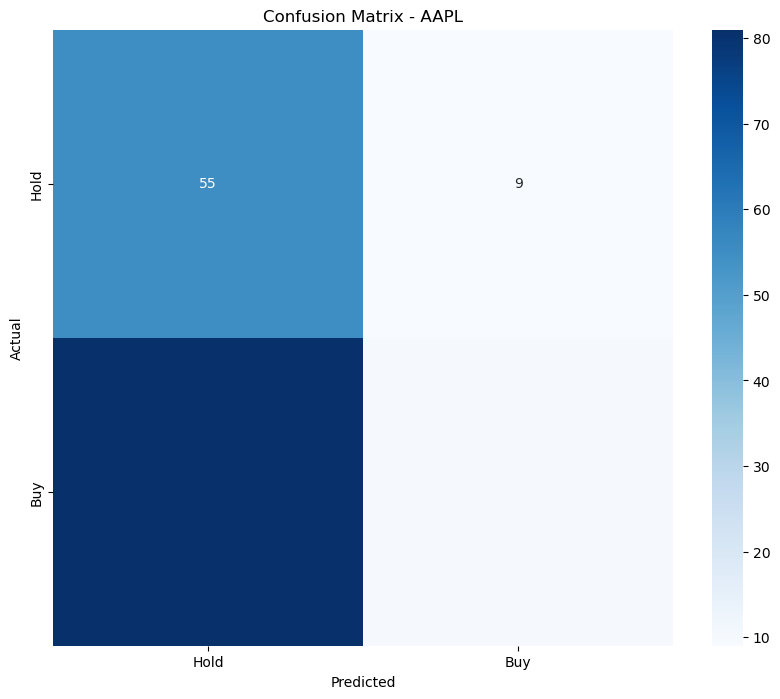

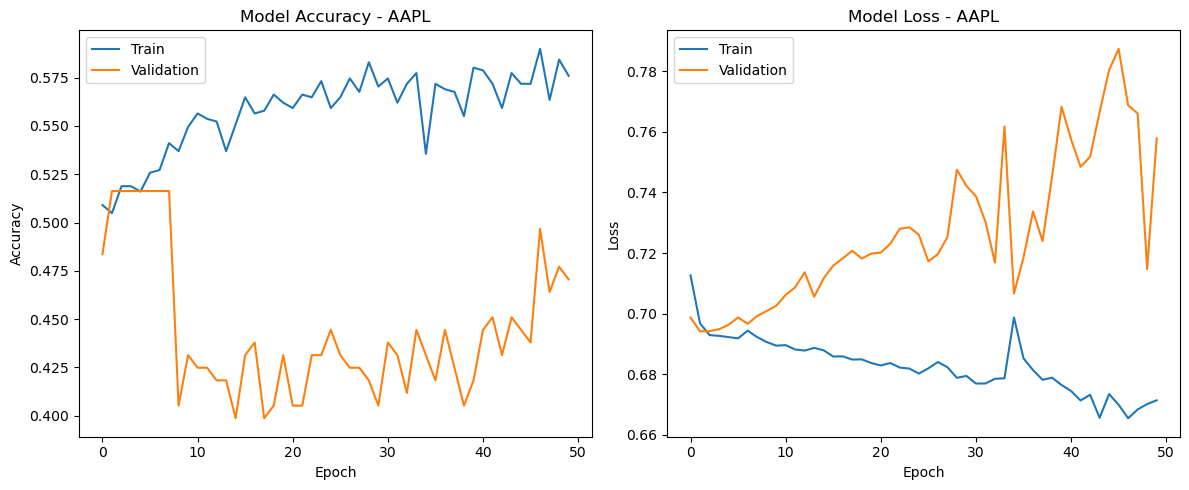

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


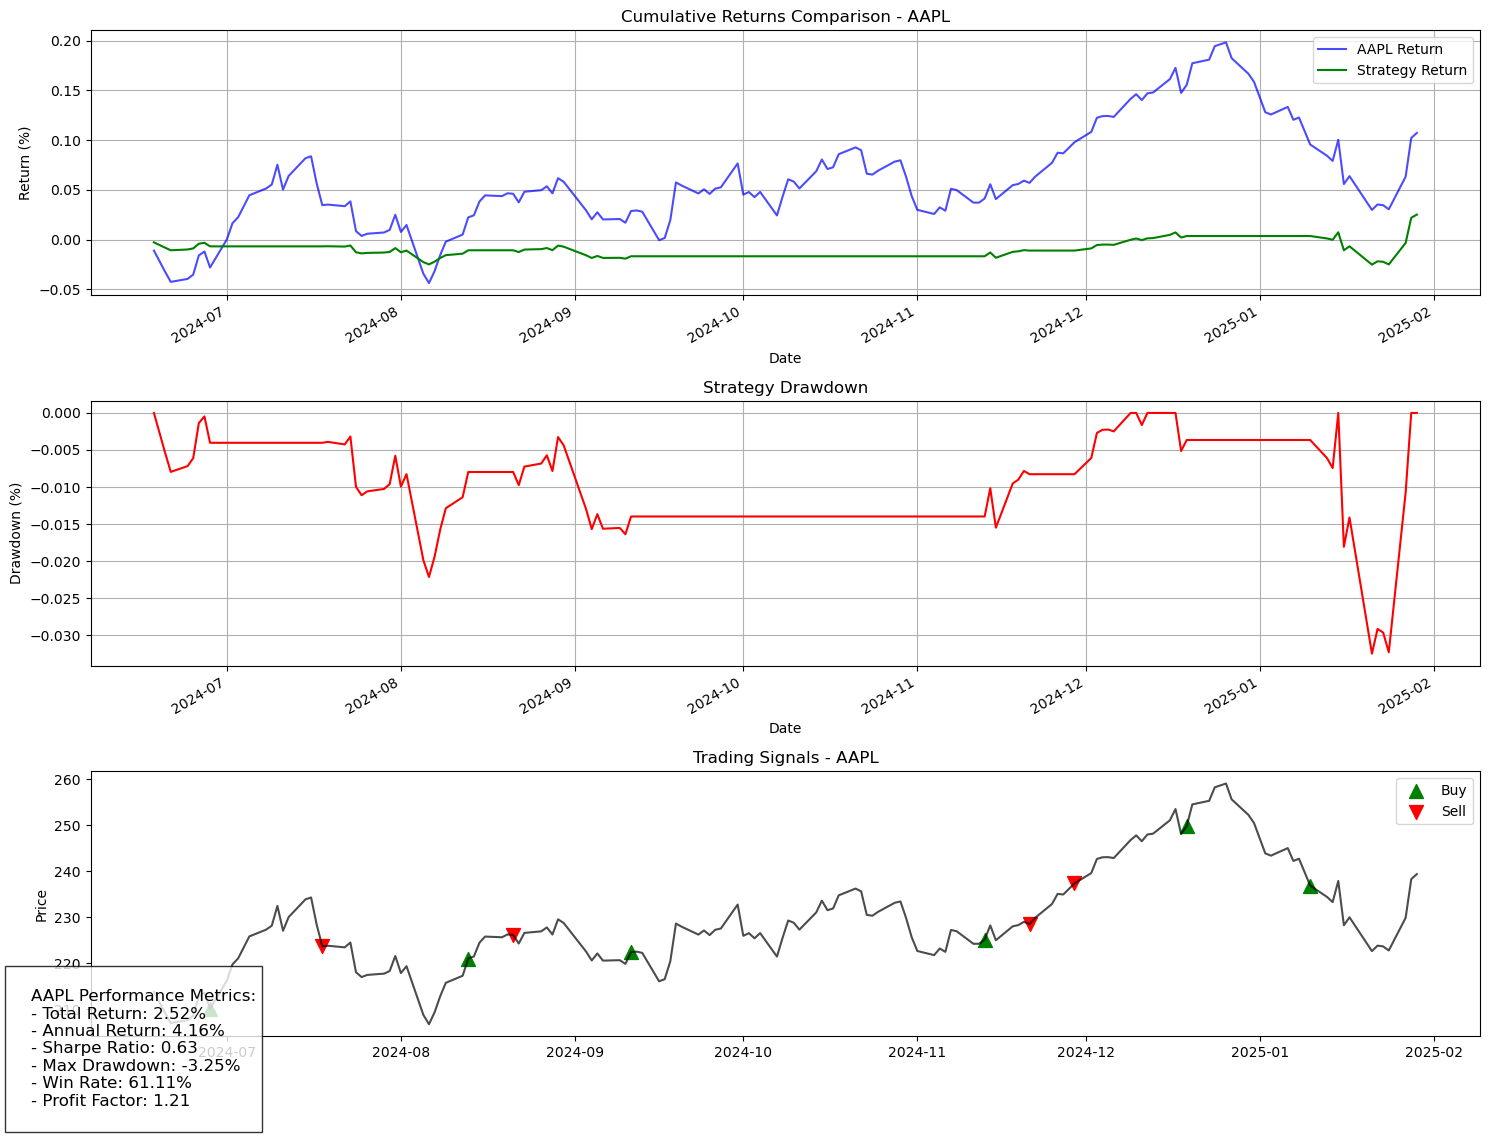

Entering position at 225.1199951171875 on 2024-11-13 00:00:00
Take-profit triggered at 237.3300018310547 on 2024-11-29 00:00:00, return: 5.42%
Entering position at 236.8500061035156 on 2025-01-10 00:00:00
Stop-loss triggered at 228.25999450683597 on 2025-01-16 00:00:00, return: -3.63%
Entering position at 229.97999572753903 on 2025-01-17 00:00:00
Stop-loss triggered at 222.63999938964844 on 2025-01-21 00:00:00, return: -3.19%
Entering position at 223.8300018310547 on 2025-01-22 00:00:00
Take-profit triggered at 238.25999450683597 on 2025-01-28 00:00:00, return: 6.45%
Entering position at 239.3600006103516 on 2025-01-29 00:00:00

Performance Metrics AAPL: {'total_return': 0.025203556199208554, 'annual_return': 0.041571915053334685, 'sharpe_ratio': 0.6275390937739589, 'max_drawdown': -0.032488370661589716, 'win_rate': 0.6111111111111112, 'profit_factor': 1.2128340667168476, 'accuracy': 0.41935483870967744, 'precision': 0.4759812244082692, 'recall': 0.41935483870967744, 'f1_score': 0.3338

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step - accuracy: 0.4589 - loss: 0.8424 - val_accuracy: 0.6013 - val_loss: 0.6844
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5032 - loss: 0.6956 - val_accuracy: 0.6013 - val_loss: 0.6812
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5032 - loss: 0.6947 - val_accuracy: 0.6013 - val_loss: 0.6815
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5032 - loss: 0.6939 - val_accuracy: 0.6013 - val_loss: 0.6796
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5032 - loss: 0.6947 - val_accuracy: 0.6013 - val_loss: 0.6784
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5032 - loss: 0.6930 - val_accuracy: 0.6013 - val_loss: 0.6786
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5032 - loss: 0.6924 - val_accuracy: 0.6013 - val_loss: 0.6800
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4993 - loss: 0.6907 - val_accuracy: 0.6013 - val_loss: 

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step
Accuracy: 0.4774
Precision: 0.4769
Recall: 0.4774
F1 Score: 0.3985

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.85      0.61        75
           1       0.48      0.12      0.20        80

    accuracy                           0.48       155
   macro avg       0.48      0.49      0.41       155
weighted avg       0.48      0.48      0.40       155



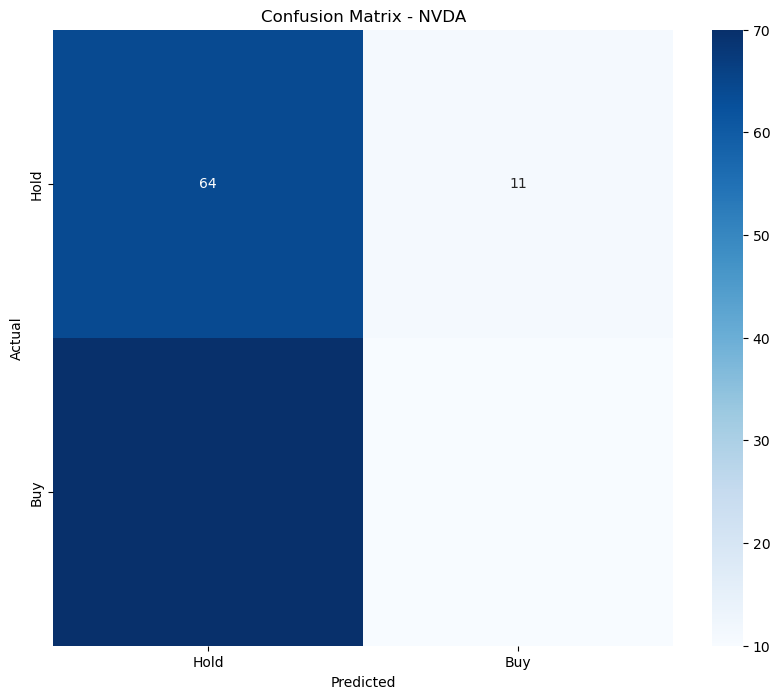

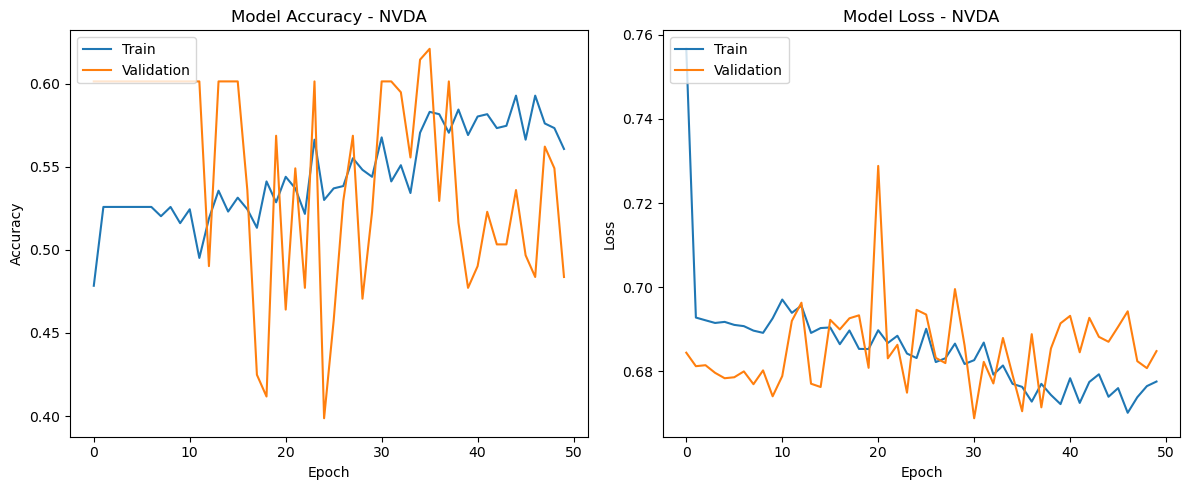

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


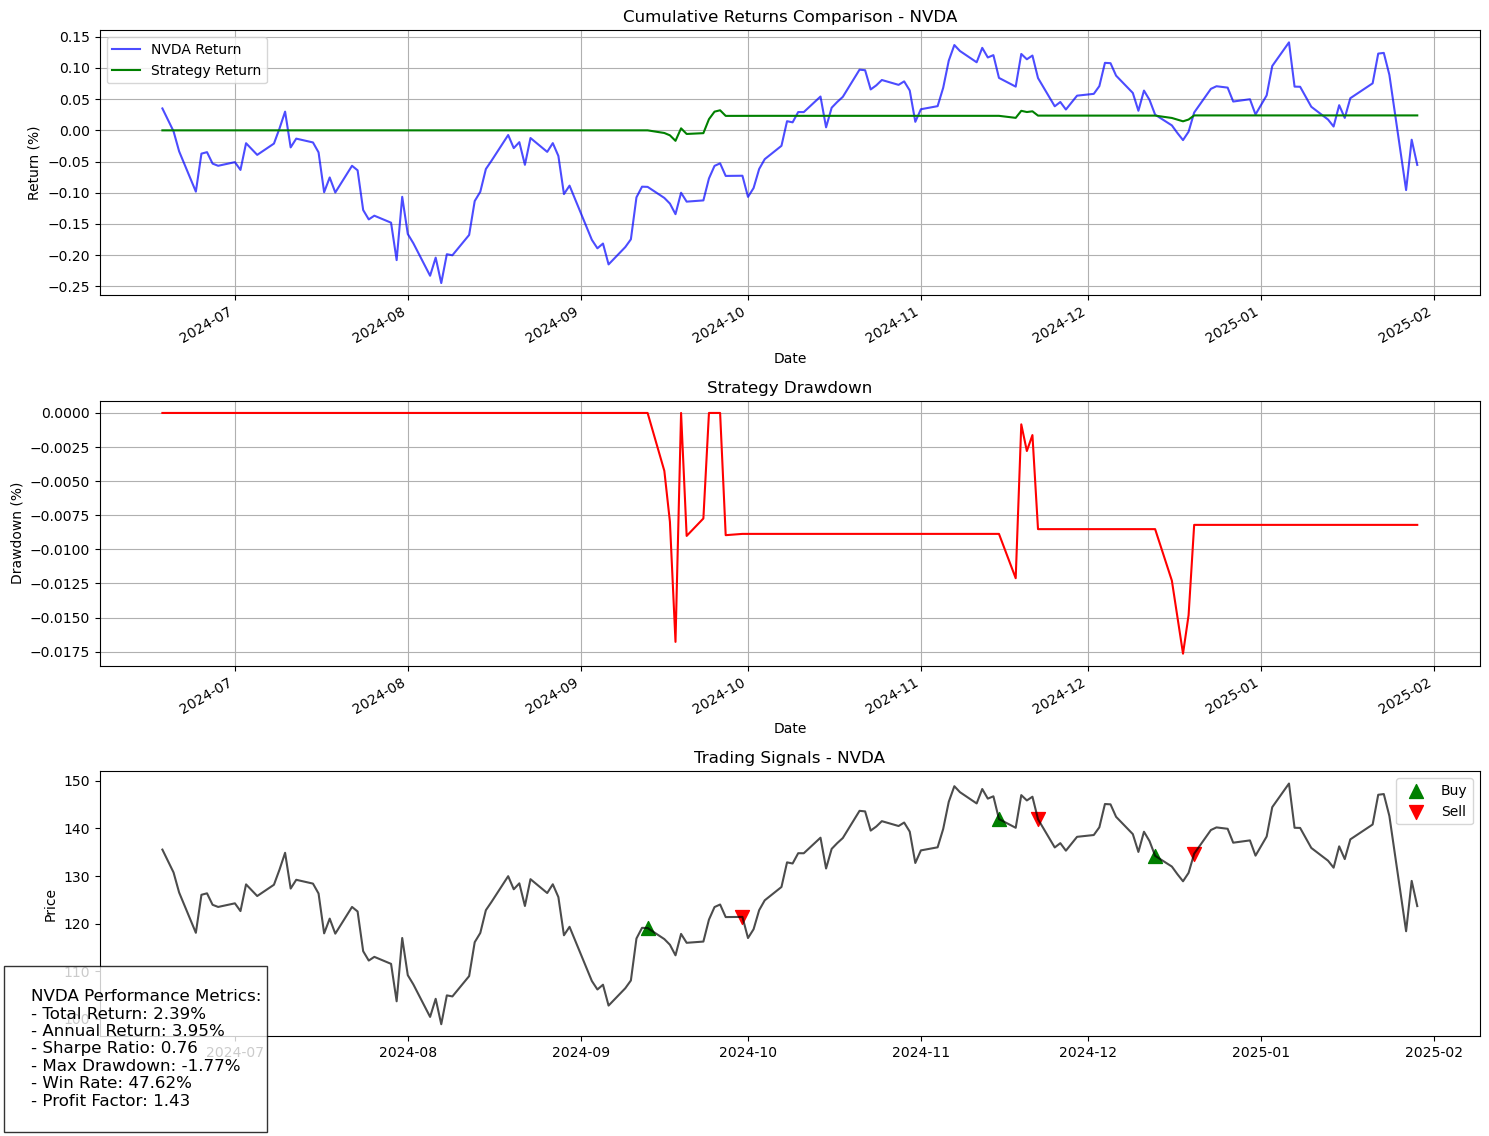

Entering position at 119.09178924560548 on 2024-09-13 00:00:00
Stop-loss triggered at 115.58203125 on 2024-09-17 00:00:00, return: -2.95%
Entering position at 113.36219024658205 on 2024-09-18 00:00:00
Take-profit triggered at 120.8616714477539 on 2024-09-24 00:00:00, return: 6.62%
Entering position at 123.50149536132812 on 2024-09-25 00:00:00
Stop-loss triggered at 116.99193572998048 on 2024-10-01 00:00:00, return: -5.27%
Entering position at 141.97021484375 on 2024-11-15 00:00:00
Stop-loss triggered at 136.01063537597656 on 2024-11-25 00:00:00, return: -4.20%
Entering position at 134.25 on 2024-12-13 00:00:00
Stop-loss triggered at 130.38999938964844 on 2024-12-17 00:00:00, return: -2.88%
Entering position at 128.91000366210938 on 2024-12-18 00:00:00
Take-profit triggered at 139.6699981689453 on 2024-12-23 00:00:00, return: 8.35%

Performance Metrics NVDA: {'total_return': 0.023937495048849344, 'annual_return': 0.03946792854211134, 'sharpe_ratio': 0.7609507845958791, 'max_drawdown': -

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.5464 - loss: 0.7328 - val_accuracy: 0.4444 - val_loss: 0.7197
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5021 - loss: 0.6946 - val_accuracy: 0.5556 - val_loss: 0.6910
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5240 - loss: 0.6936 - val_accuracy: 0.4444 - val_loss: 0.6965
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5074 - loss: 0.6952 - val_accuracy: 0.4444 - val_loss: 0.6946
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5011 - loss: 0.6943 - val_accuracy: 0.4444 - val_loss: 0.6991
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5018 - loss: 0.6944 - val_accuracy: 0.5556 - val_loss: 0.6918
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5289 - loss: 0.6932 - val_accuracy: 0.5556 - val_loss: 0.6901
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5119 - loss: 0.6933 - val_accuracy: 0.5556 - val_loss

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
Accuracy: 0.4774
Precision: 0.2279
Recall: 0.4774
F1 Score: 0.3086

Classification Report:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        74
           1       0.00      0.00      0.00        81

    accuracy                           0.48       155
   macro avg       0.24      0.50      0.32       155
weighted avg       0.23      0.48      0.31       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

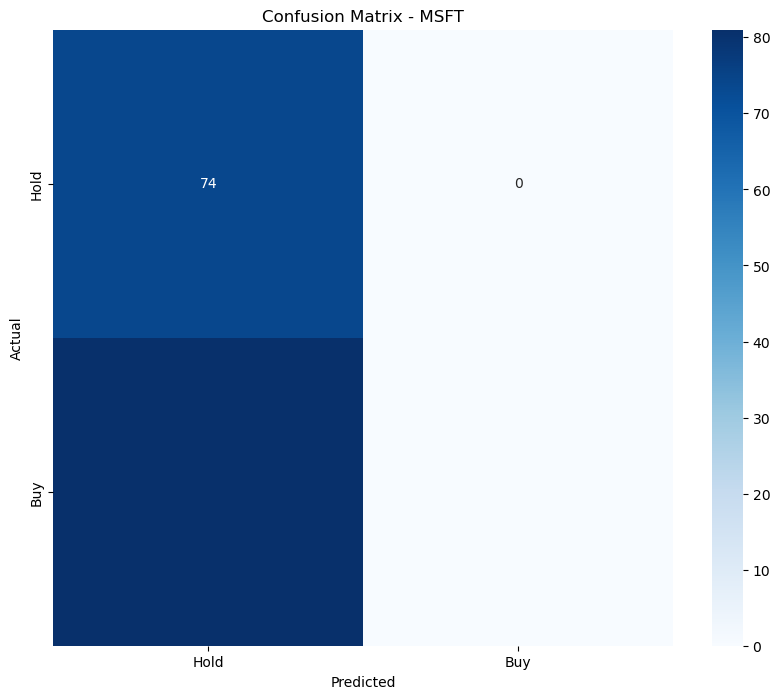

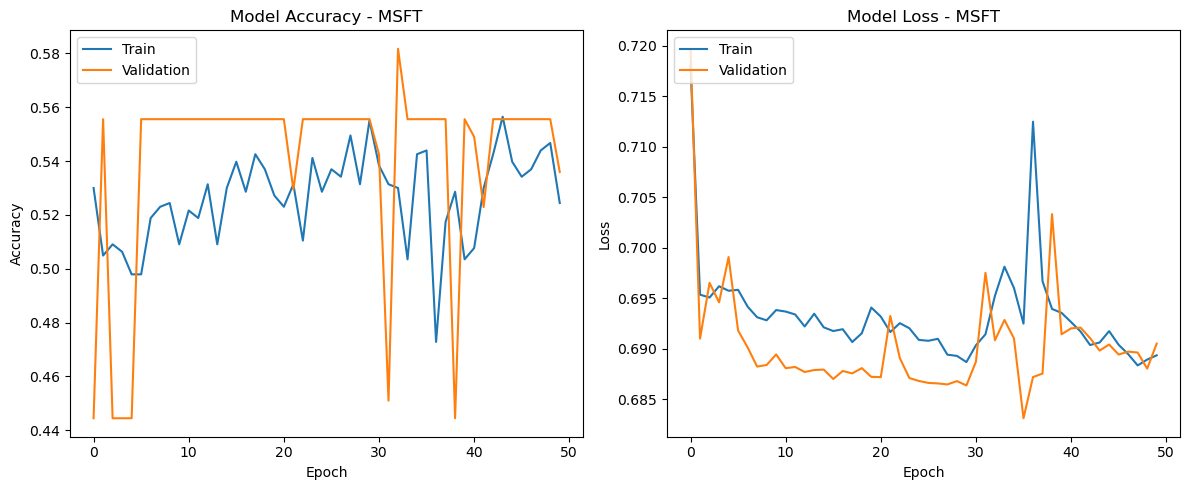

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


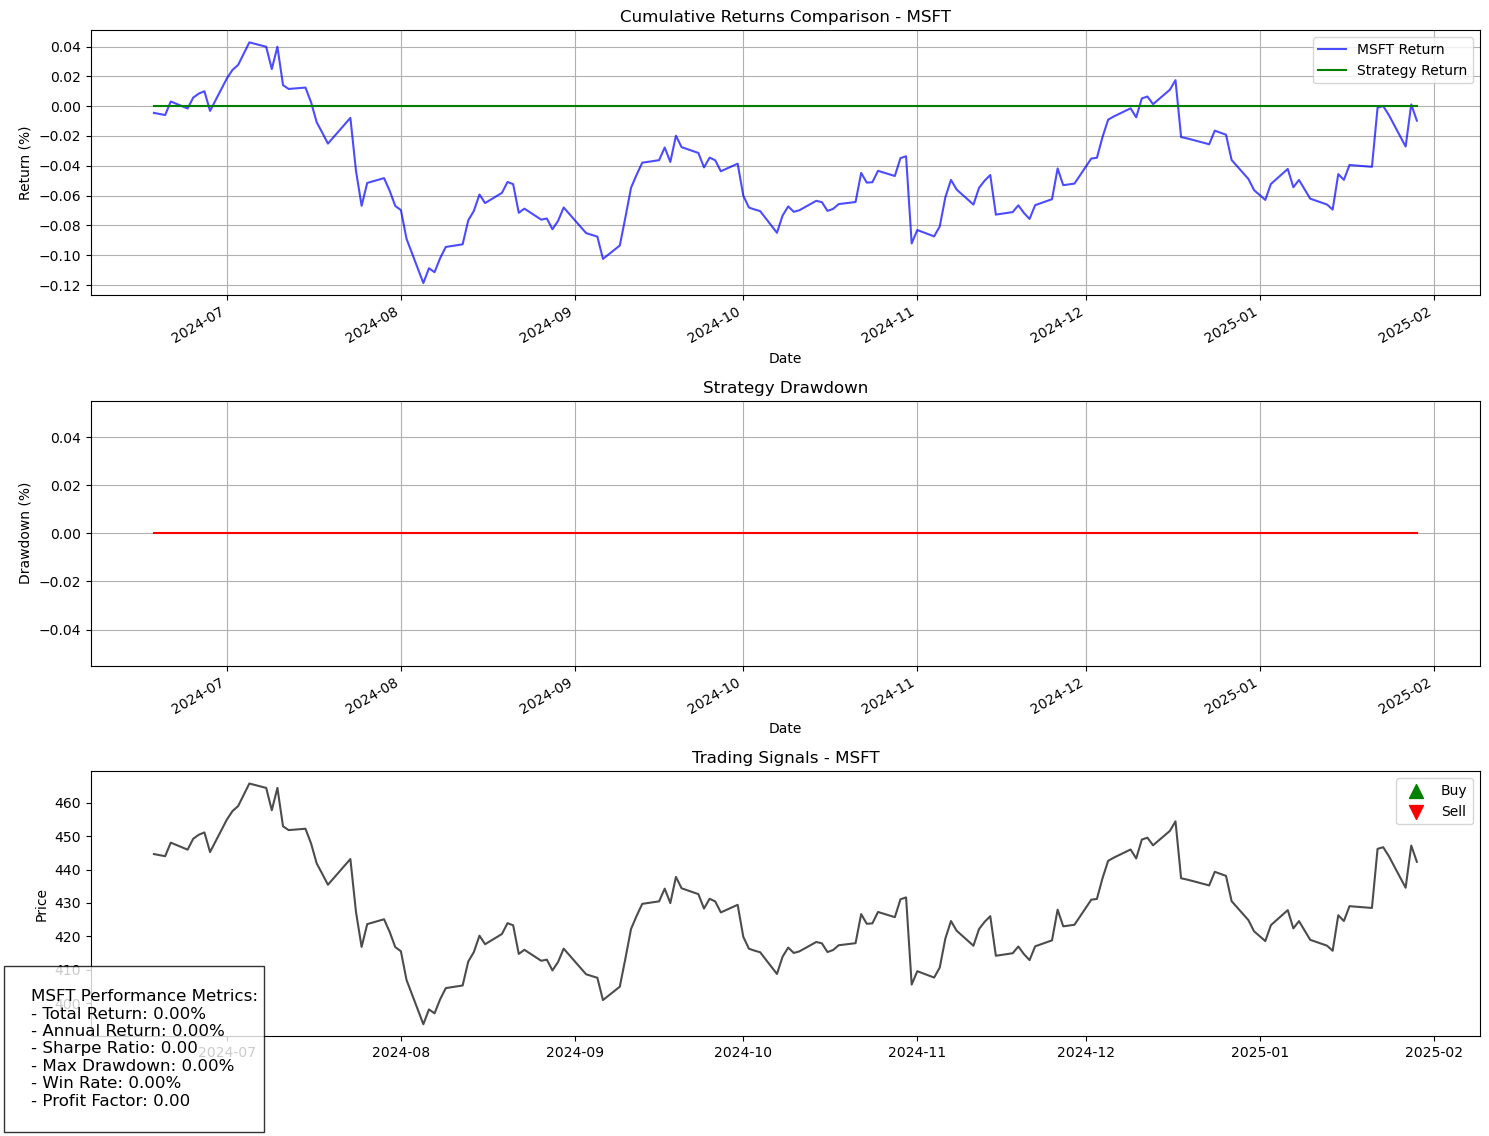


Performance Metrics MSFT: {'total_return': 0.0, 'annual_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'win_rate': 0.0, 'profit_factor': 0.0, 'accuracy': 0.4774193548387097, 'precision': 0.22792924037460977, 'recall': 0.4774193548387097, 'f1_score': 0.30855050007043244}

Trades MSFT: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing AMZN...
Error processing AMZN: Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Processing META...
Top 15 features by mutual information:
              Feature  MI Score
2         Log_Returns  0.029998
1             Returns  0.029998
55          VIX_MA_10  0.024969
52  Market_Volatility  0.021557
27        BB_Width_50  0.021195
53       Rolling_Beta  0.020651
34        Momentum_14  0.019275
44           PB_Ratio  0.016768
37             MFI_28  0.016548
29             RSI_14  0.015767
47               Beta  0.015526
24     Volatility_60d  0.015330
54          

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.4858 - loss: 0.7078 - val_accuracy: 0.4510 - val_loss: 0.7153
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5233 - loss: 0.6957 - val_accuracy: 0.5490 - val_loss: 0.6902
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4799 - loss: 0.6968 - val_accuracy: 0.5490 - val_loss: 0.6885
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4726 - loss: 0.6982 - val_accuracy: 0.5490 - val_loss: 0.6884
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4672 - loss: 0.6981 - val_accuracy: 0.4510 - val_loss: 0.6939
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5128 - loss: 0.6942 - val_accuracy: 0.5490 - val_loss: 0.6919
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4550 - loss: 0.6940 - val_accuracy: 0.5490 - val_loss: 0.6924
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4565 - loss: 0.6937 - val_accuracy: 0.5490 - val_loss: 

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step
Accuracy: 0.4516
Precision: 0.2040
Recall: 0.4516
F1 Score: 0.2810

Classification Report:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        70
           1       0.00      0.00      0.00        85

    accuracy                           0.45       155
   macro avg       0.23      0.50      0.31       155
weighted avg       0.20      0.45      0.28       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

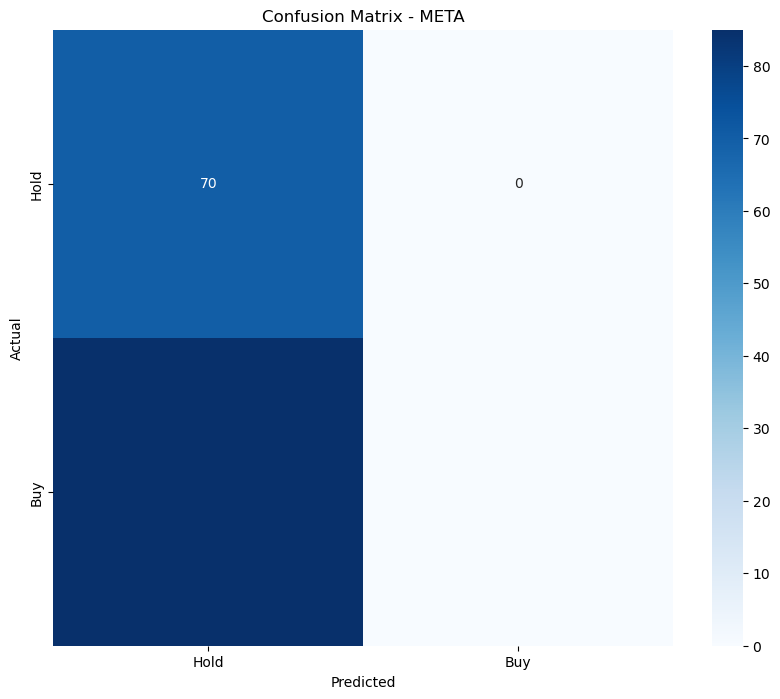

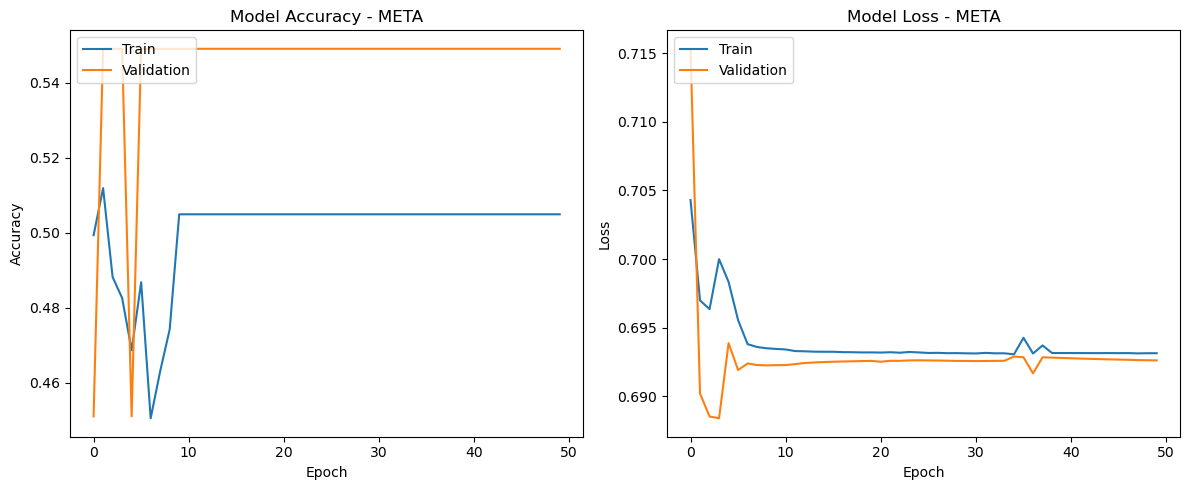

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


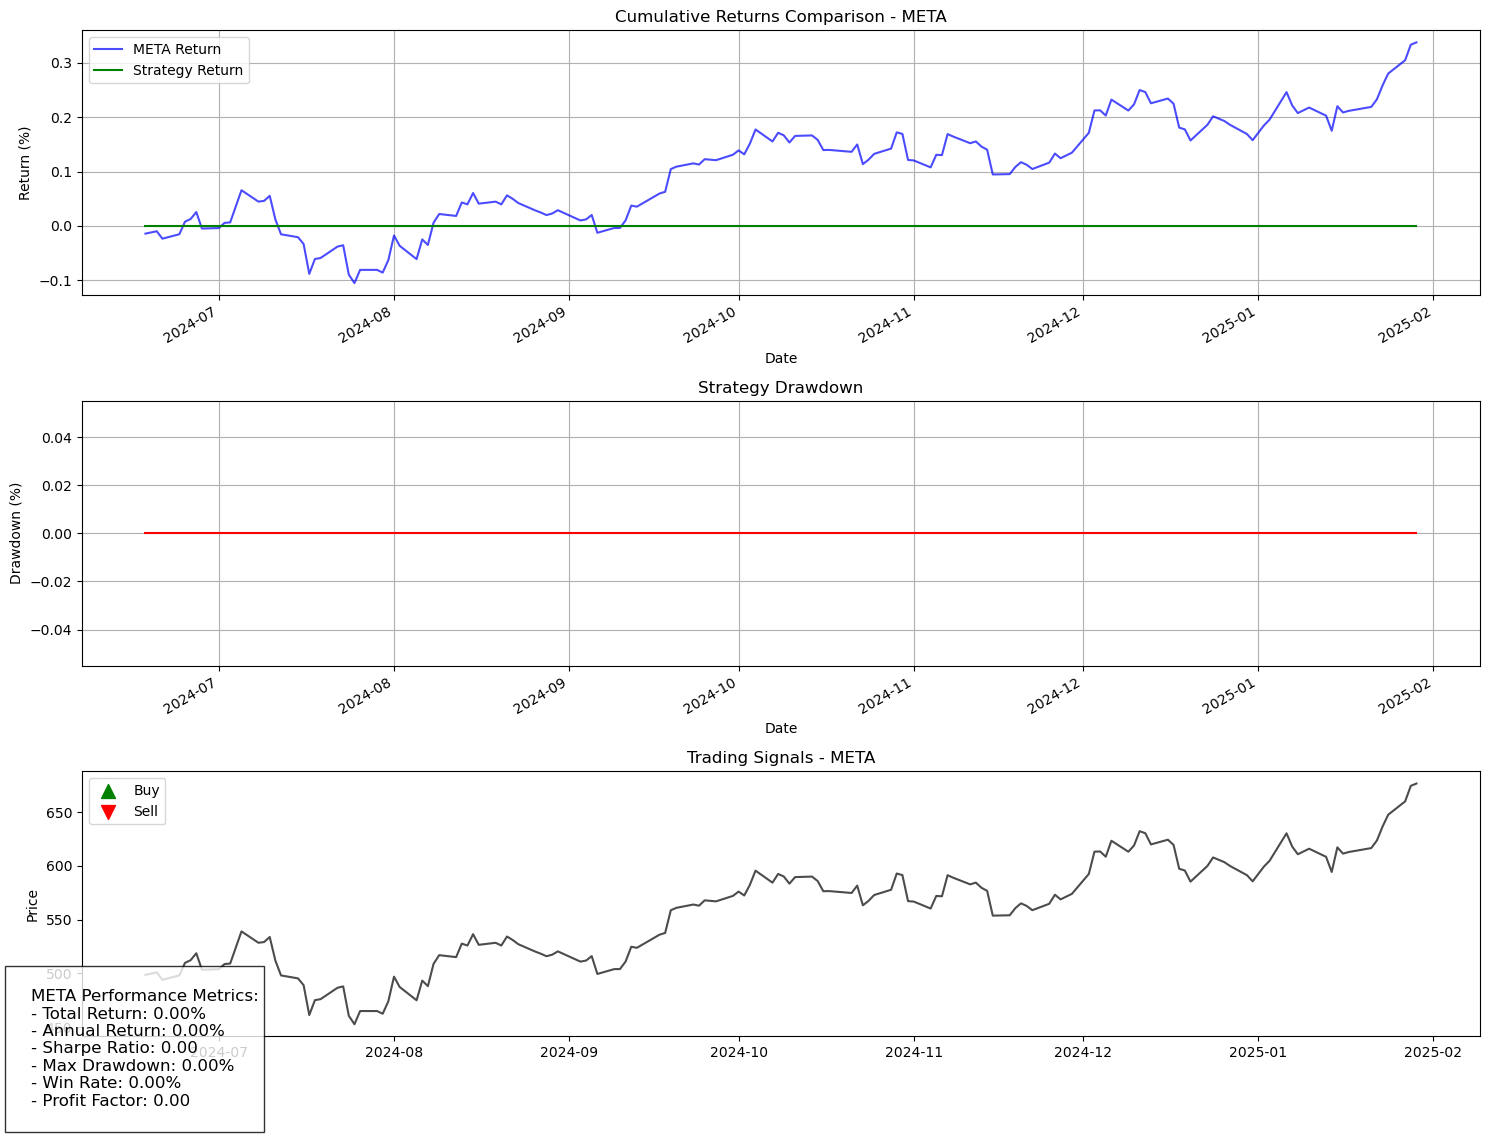


Performance Metrics META: {'total_return': 0.0, 'annual_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'win_rate': 0.0, 'profit_factor': 0.0, 'accuracy': 0.45161290322580644, 'precision': 0.20395421436004163, 'recall': 0.45161290322580644, 'f1_score': 0.2810035842293907}

Trades META: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing GOOGL...
Top 15 features by mutual information:
            Feature  MI Score
49      Forward_EPS  0.039317
14            MA_50  0.030260
34      Momentum_14  0.027248
54              VIX  0.024576
10      Returns_10d  0.023602
12           EMA_20  0.023247
13      Returns_20d  0.022420
28            RSI_9  0.021330
0             Close  0.019241
4   Price_Range_Pct  0.019122
6             EMA_5  0.016879
19     Returns_200d  0.014318
55        VIX_MA_10  0.013482
30           RSI_25  0.013434
7        Returns_5d  0.011655
Selected 15 features
Epoch 1/50


c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5003 - loss: 0.7968 - val_accuracy: 0.3856 - val_loss: 0.7245
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5283 - loss: 0.6998 - val_accuracy: 0.3856 - val_loss: 0.7060
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.4714 - loss: 0.6964 - val_accuracy: 0.3856 - val_loss: 0.7005
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4681 - loss: 0.6958 - val_accuracy: 0.3856 - val_loss: 0.7190
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5142 - loss: 0.6939 - val_accuracy: 0.3856 - val_loss: 0.7036
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5025 - loss: 0.6947 - val_accuracy: 0.5294 - val_loss: 0.6919
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5345 - loss: 0.6917 - val_accuracy: 0.5163 - val_loss: 0.6901
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5687 - loss: 0.6888 - val_accuracy: 0.6144 - val_loss: 

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step
Accuracy: 0.4452
Precision: 0.1982
Recall: 0.4452
F1 Score: 0.2743

Classification Report:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        69
           1       0.00      0.00      0.00        86

    accuracy                           0.45       155
   macro avg       0.22      0.50      0.31       155
weighted avg       0.20      0.45      0.27       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

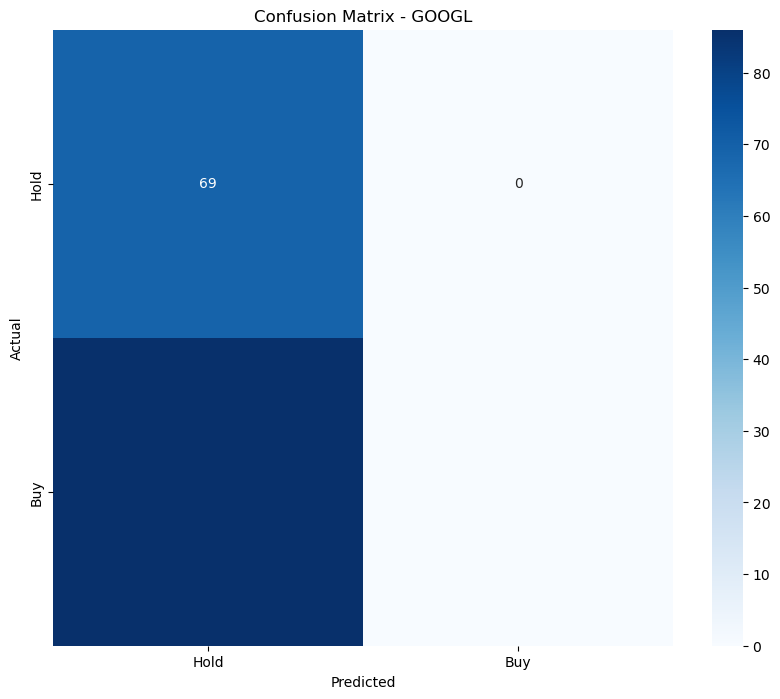

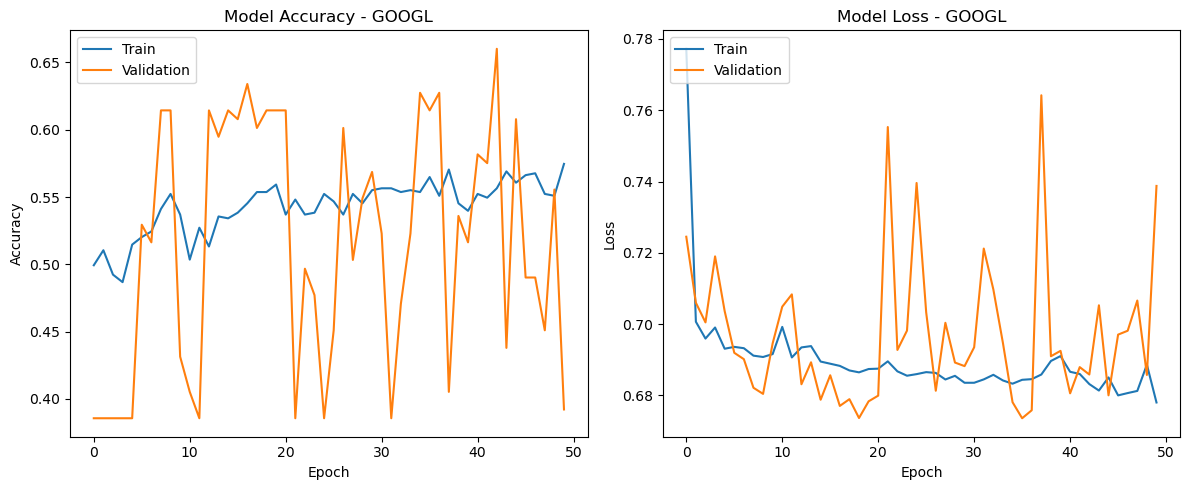

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


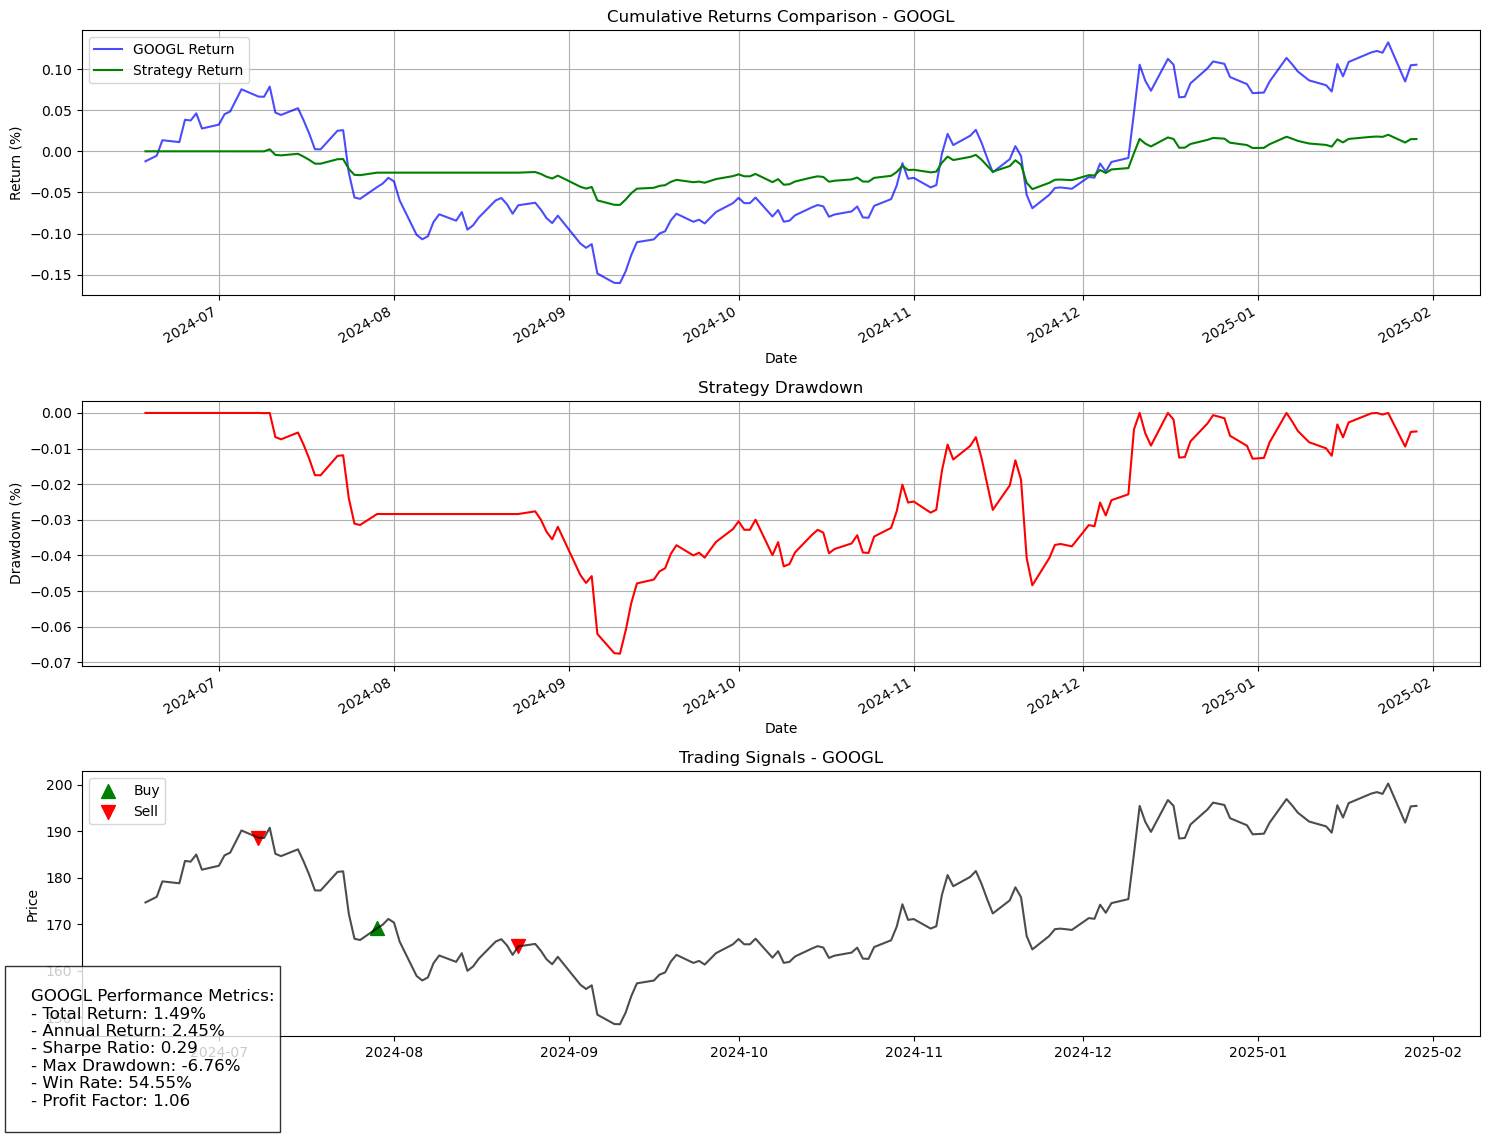


Performance Metrics GOOGL: {'total_return': 0.01491919968040567, 'annual_return': 0.024528917396855254, 'sharpe_ratio': 0.29105490054879757, 'max_drawdown': -0.06759153949217234, 'win_rate': 0.5454545454545454, 'profit_factor': 1.0578051044516137, 'accuracy': 0.44516129032258067, 'precision': 0.19816857440166494, 'recall': 0.44516129032258067, 'f1_score': 0.27425115207373274}

Trades GOOGL: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing AVGO...
Top 15 features by mutual information:
              Feature  MI Score
51      Market_Return  0.039248
52  Market_Volatility  0.030066
8               MA_10  0.028723
11              MA_20  0.023924
41       Volume_Ratio  0.022074
31               MACD  0.020210
19       Returns_200d  0.018319
48   Enterprise_Value  0.016460
43           PE_Ratio  0.014643
6               EMA_5  0.011613
45     Dividend_Yield  0.010338
12             EMA_20  0.009801
20      Volatility_5d  0.006890
1

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.4777 - loss: 0.7214 - val_accuracy: 0.5556 - val_loss: 0.6876
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4734 - loss: 0.7073 - val_accuracy: 0.5556 - val_loss: 0.6905
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4916 - loss: 0.6941 - val_accuracy: 0.5556 - val_loss: 0.6883
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.4916 - loss: 0.6985 - val_accuracy: 0.5556 - val_loss: 0.6874
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.4691 - loss: 0.6992 - val_accuracy: 0.5556 - val_loss: 0.6953
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4804 - loss: 0.7039 - val_accuracy: 0.5556 - val_loss: 0.6887
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4916 - loss: 0.6965 - val_accuracy: 0.5556 - val_loss: 0.6881
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4916 - loss: 0.6972 - val_accuracy: 0.5556 - val_loss

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step
Accuracy: 0.4903
Precision: 0.2404
Recall: 0.4903
F1 Score: 0.3226

Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        76
           1       0.00      0.00      0.00        79

    accuracy                           0.49       155
   macro avg       0.25      0.50      0.33       155
weighted avg       0.24      0.49      0.32       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

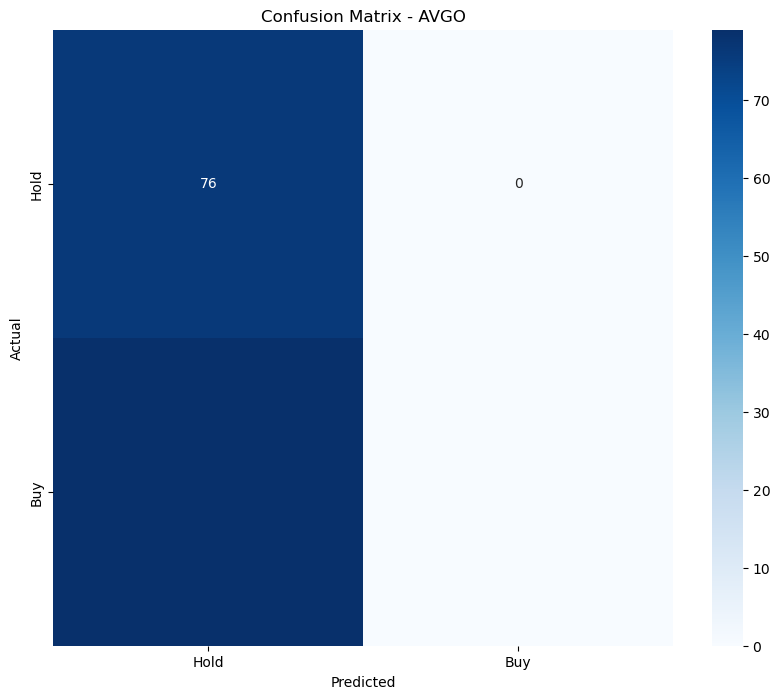

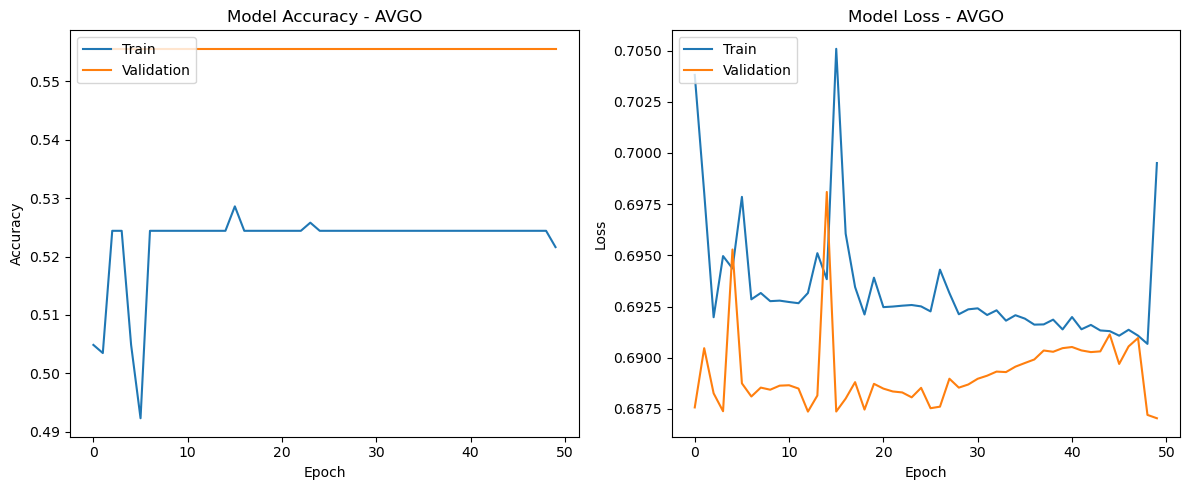

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


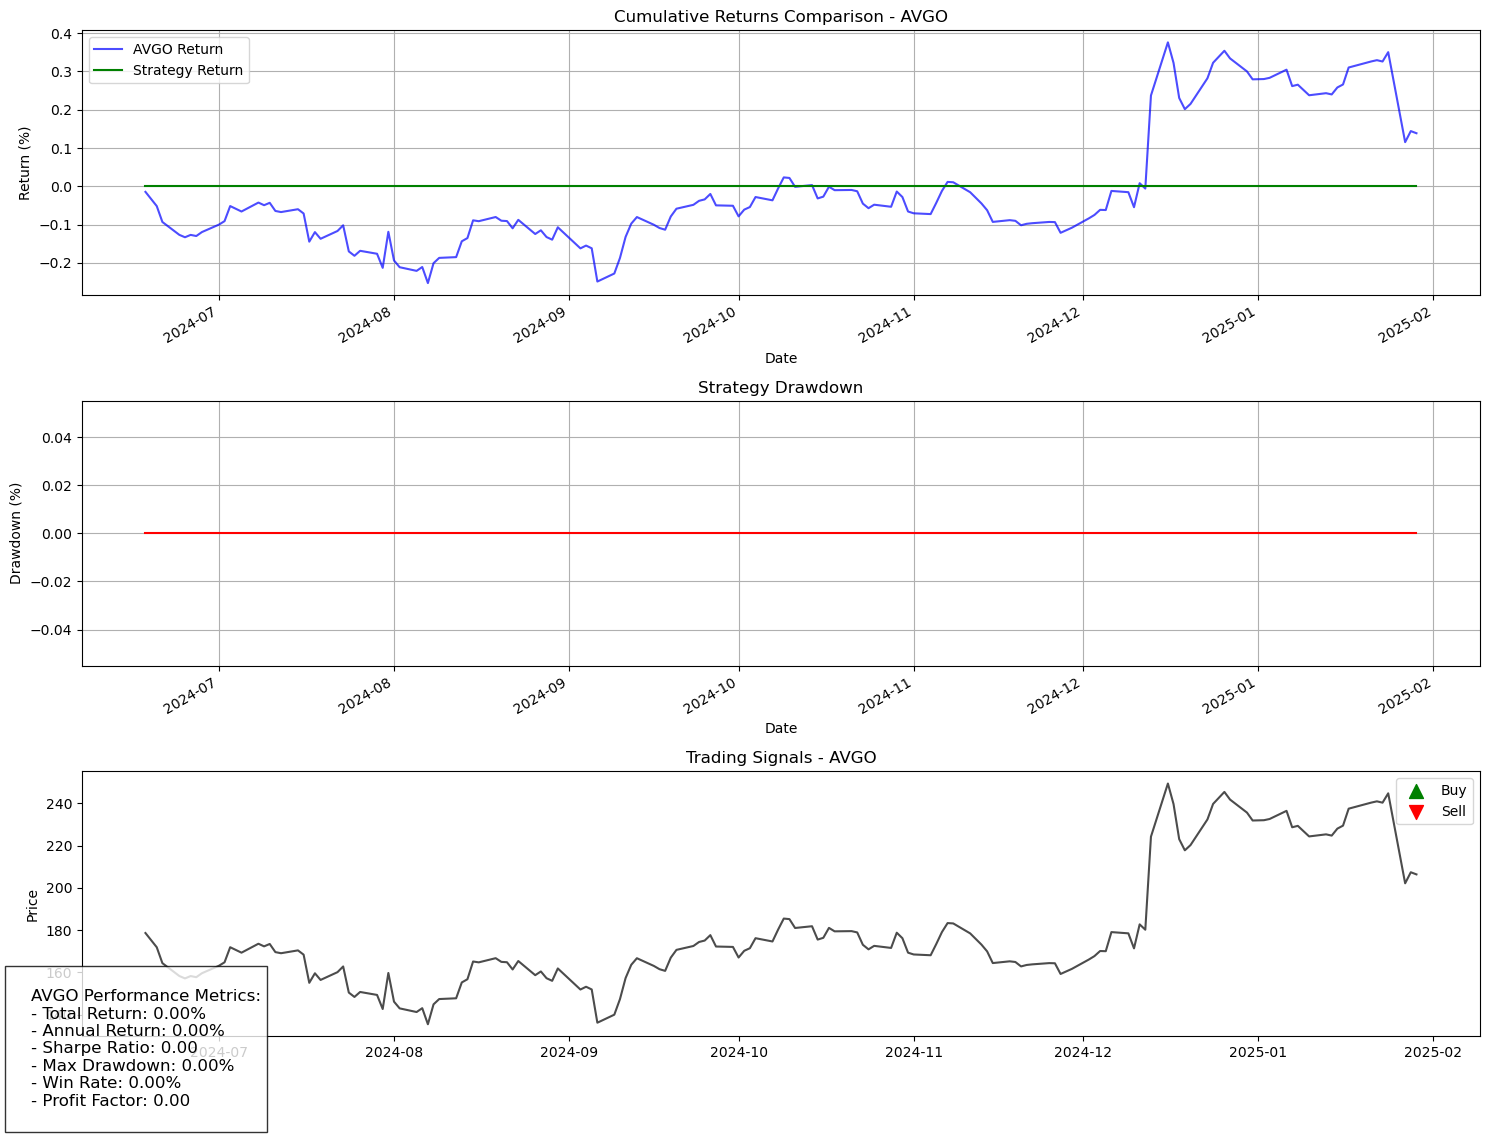


Performance Metrics AVGO: {'total_return': 0.0, 'annual_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'win_rate': 0.0, 'profit_factor': 0.0, 'accuracy': 0.49032258064516127, 'precision': 0.2404162330905307, 'recall': 0.49032258064516127, 'f1_score': 0.3226365032816646}

Trades AVGO: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing TSLA...
Error processing TSLA: Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Processing BRK.B...
Error processing BRK.B: attempt to get argmax of an empty sequence
Processing GOOG...
Top 15 features by mutual information:
            Feature  MI Score
31             MACD  0.042797
29           RSI_14  0.028466
14            MA_50  0.027935
12           EMA_20  0.024395
0             Close  0.023631
24   Volatility_60d  0.018541
44         PB_Ratio  0.018187
37           MFI_28  0.018109
54              VIX  0.018056
19     Returns_200d  0.016476
4   Price_R

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.4831 - loss: 0.7975 - val_accuracy: 0.3856 - val_loss: 0.7027
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4999 - loss: 0.6921 - val_accuracy: 0.3856 - val_loss: 0.6996
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5205 - loss: 0.6916 - val_accuracy: 0.4052 - val_loss: 0.6991
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5382 - loss: 0.6903 - val_accuracy: 0.4379 - val_loss: 0.7000
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5471 - loss: 0.6900 - val_accuracy: 0.3856 - val_loss: 0.7075
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5031 - loss: 0.6923 - val_accuracy: 0.4706 - val_loss: 0.6920
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5335 - loss: 0.6897 - val_accuracy: 0.3856 - val_loss: 0.7096
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5072 - loss: 0.6941 - val_accuracy: 0.3856 - val_loss:

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step
Accuracy: 0.4258
Precision: 0.1813
Recall: 0.4258
F1 Score: 0.2543

Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        66
           1       0.00      0.00      0.00        89

    accuracy                           0.43       155
   macro avg       0.21      0.50      0.30       155
weighted avg       0.18      0.43      0.25       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

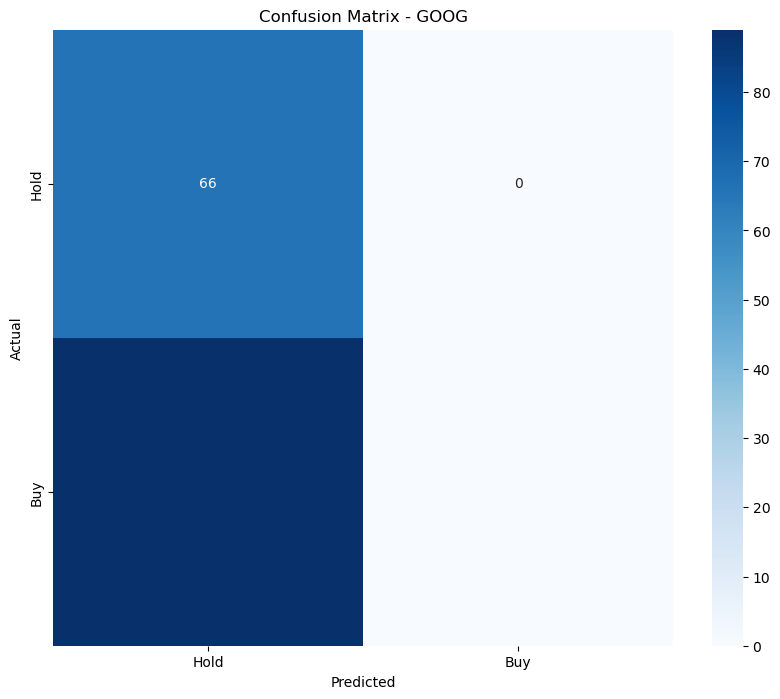

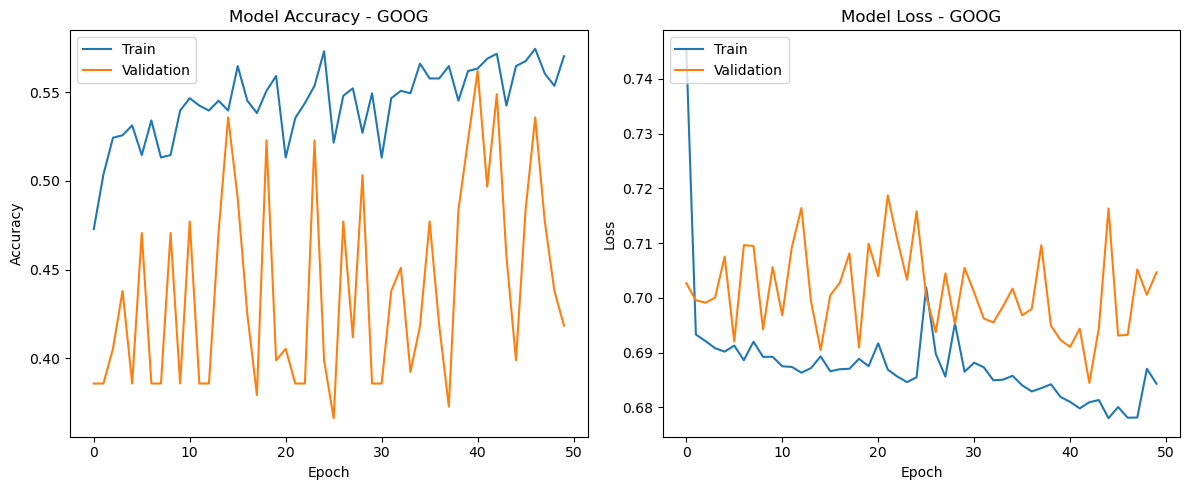

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


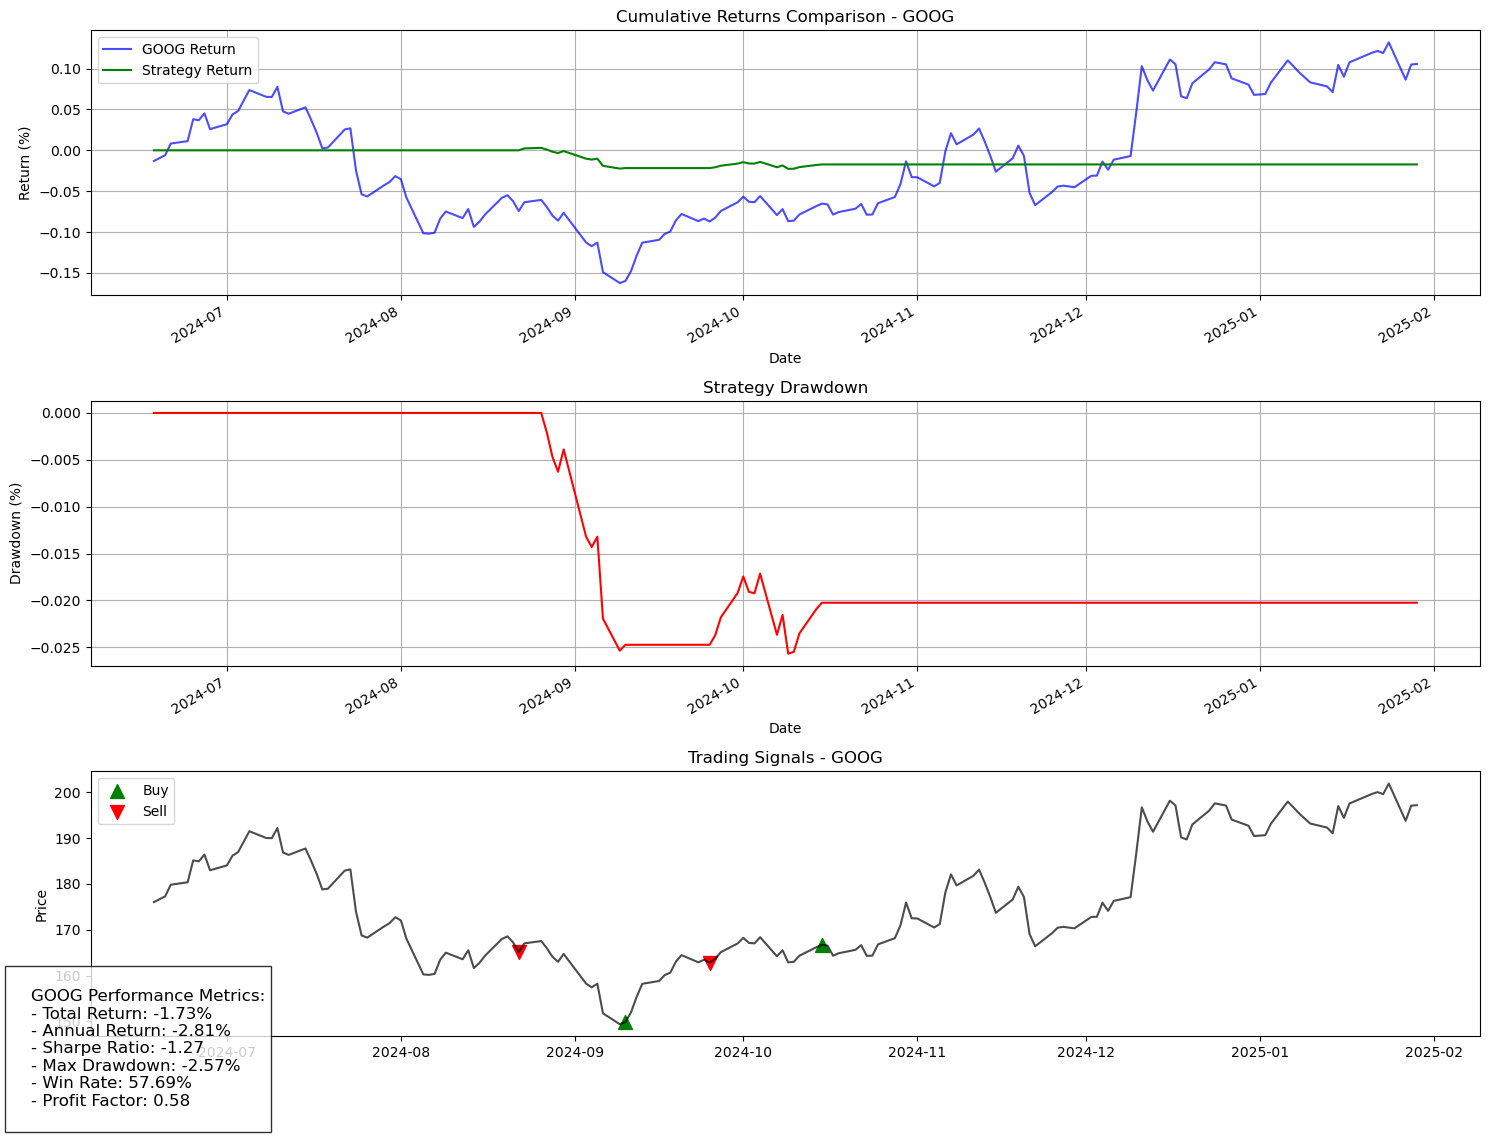


Performance Metrics GOOG: {'total_return': -0.017270914246852453, 'annual_return': -0.028105863845702128, 'sharpe_ratio': -1.2716788850812164, 'max_drawdown': -0.02567511140510037, 'win_rate': 0.5769230769230769, 'profit_factor': 0.5829760623899255, 'accuracy': 0.4258064516129032, 'precision': 0.18131113423517167, 'recall': 0.4258064516129032, 'f1_score': 0.2543278353525033}

Trades GOOG: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing JPM...
Top 15 features by mutual information:
              Feature  MI Score
4     Price_Range_Pct  0.041839
20      Volatility_5d  0.034312
39   Channel_Width_50  0.032038
30             RSI_25  0.029841
38   Channel_Width_20  0.027875
31               MACD  0.026275
5                MA_5  0.024839
14              MA_50  0.019596
36             MFI_14  0.019035
54                VIX  0.018816
18            EMA_200  0.016889
52  Market_Volatility  0.016648
37             MFI_28  0.016456
41  

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.4968 - loss: 0.7565 - val_accuracy: 0.3922 - val_loss: 0.7199
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5098 - loss: 0.6927 - val_accuracy: 0.3922 - val_loss: 0.7112
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5419 - loss: 0.6885 - val_accuracy: 0.3922 - val_loss: 0.7134
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5147 - loss: 0.6917 - val_accuracy: 0.3922 - val_loss: 0.7210
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5194 - loss: 0.6916 - val_accuracy: 0.3922 - val_loss: 0.7116
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4979 - loss: 0.6949 - val_accuracy: 0.3922 - val_loss: 0.6997
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.4920 - loss: 0.6933 - val_accuracy: 0.4771 - val_loss: 0.6929
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5230 - loss: 0.6903 - val_accuracy: 0.3922 - val_loss:

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step
Accuracy: 0.4065
Precision: 0.1652
Recall: 0.4065
F1 Score: 0.2349

Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        63
           1       0.00      0.00      0.00        92

    accuracy                           0.41       155
   macro avg       0.20      0.50      0.29       155
weighted avg       0.17      0.41      0.23       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

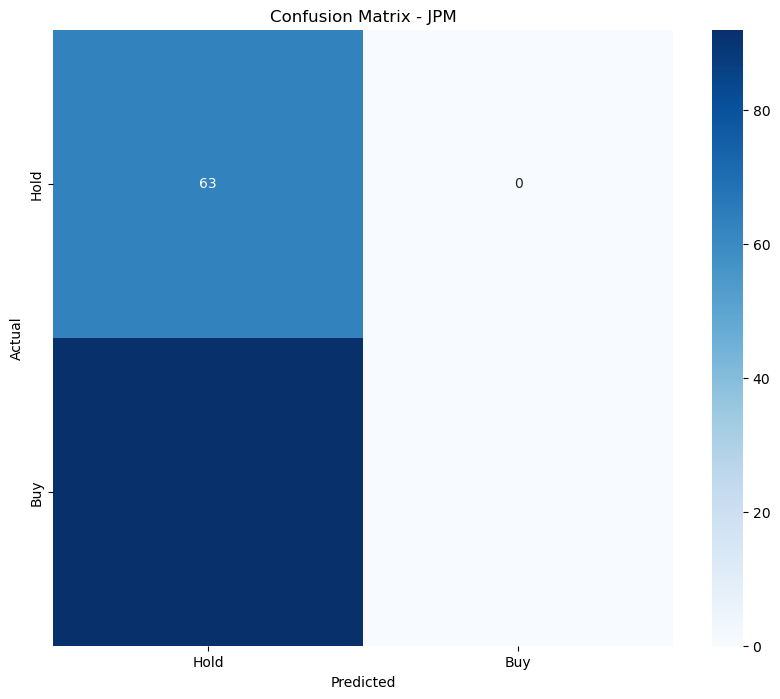

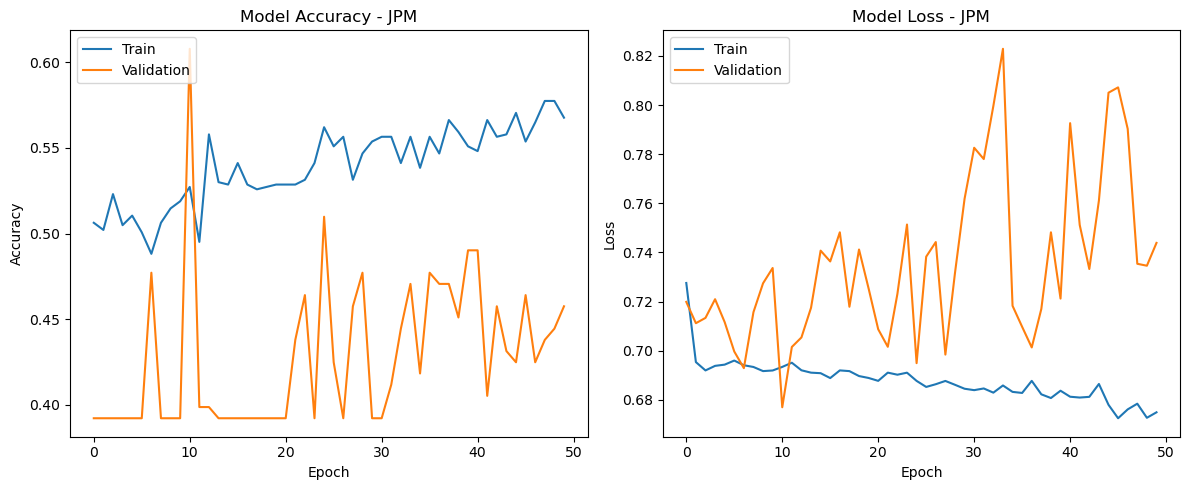

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


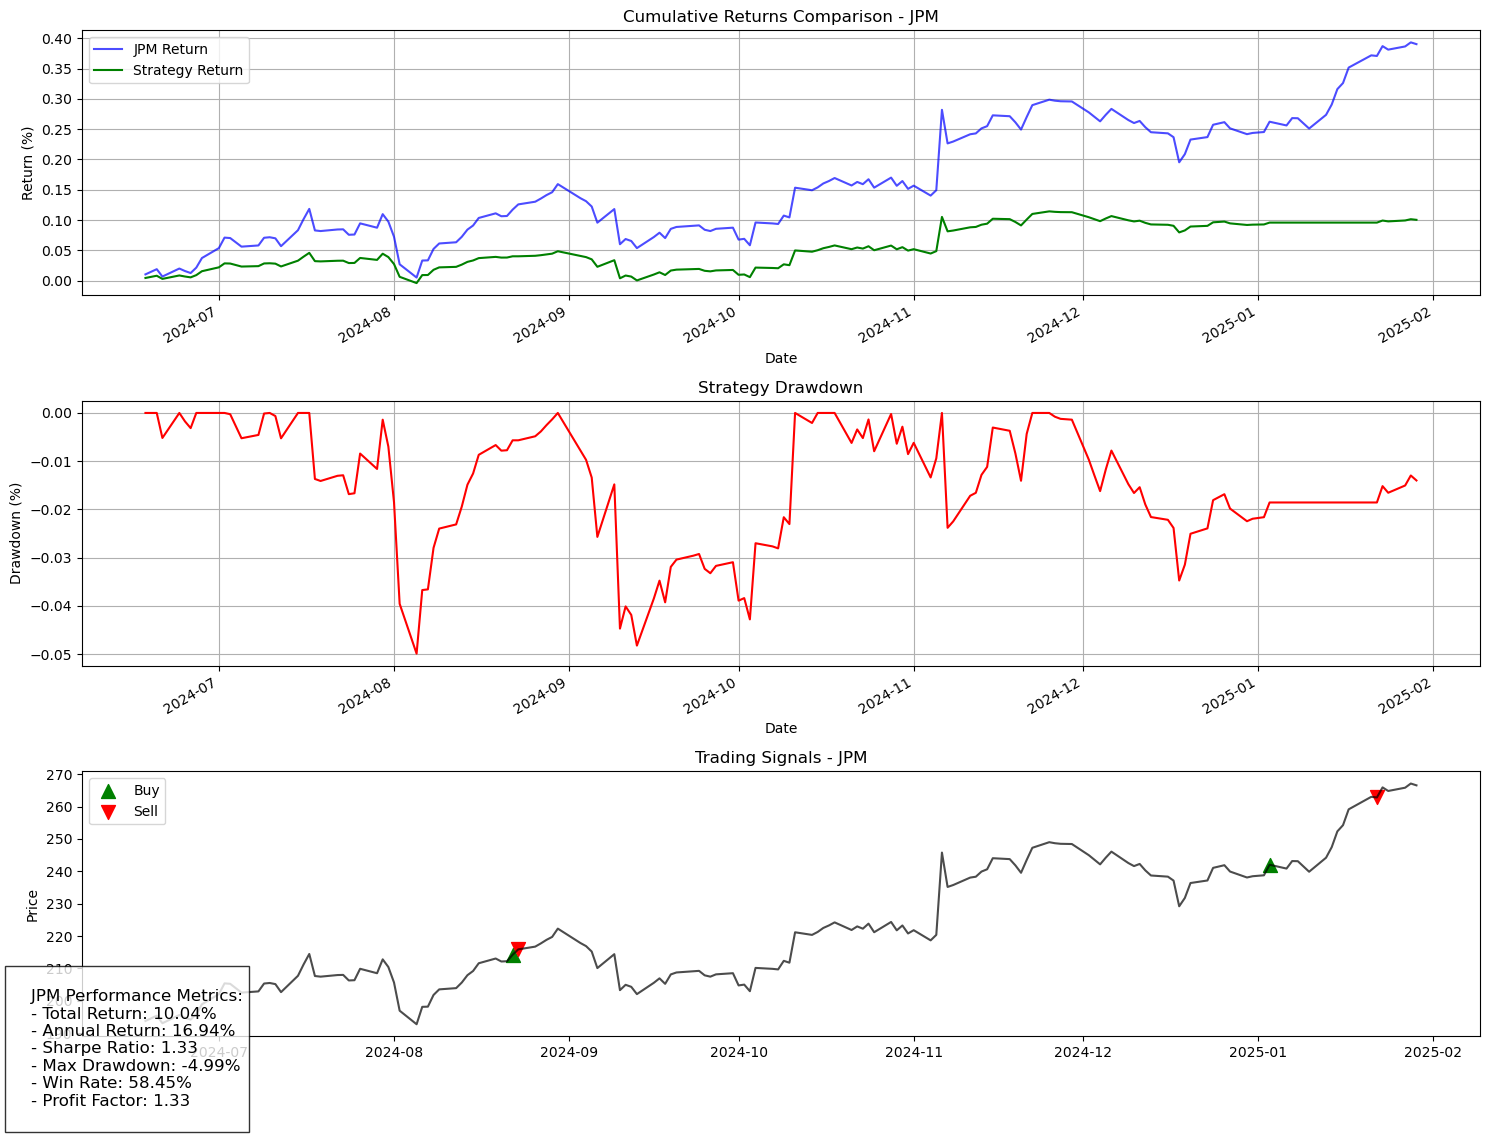


Performance Metrics JPM: {'total_return': 0.10036764189882041, 'annual_return': 0.16942120092152768, 'sharpe_ratio': 1.33262402084762, 'max_drawdown': -0.04987978833985074, 'win_rate': 0.5845070422535211, 'profit_factor': 1.3341411208494438, 'accuracy': 0.4064516129032258, 'precision': 0.1652029136316337, 'recall': 0.4064516129032258, 'f1_score': 0.2349215744303048}

Trades JPM: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing LLY...
Top 15 features by mutual information:
             Feature  MI Score
22    Volatility_20d  0.027817
24    Volatility_60d  0.024605
38  Channel_Width_20  0.020417
0              Close  0.018474
33    MACD_Histogram  0.016783
39  Channel_Width_50  0.013827
13       Returns_20d  0.013314
14             MA_50  0.013007
43          PE_Ratio  0.012884
49       Forward_EPS  0.011792
3        Price_Range  0.010576
41      Volume_Ratio  0.009356
48  Enterprise_Value  0.008241
21      Volume_MA_5d  0.0074

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.5359 - loss: 0.7345 - val_accuracy: 0.6013 - val_loss: 0.6858
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5713 - loss: 0.6871 - val_accuracy: 0.4771 - val_loss: 0.6932
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5387 - loss: 0.6897 - val_accuracy: 0.4510 - val_loss: 0.6926
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5251 - loss: 0.6922 - val_accuracy: 0.6013 - val_loss: 0.6847
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5788 - loss: 0.6876 - val_accuracy: 0.6013 - val_loss: 0.6790
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5714 - loss: 0.6837 - val_accuracy: 0.4837 - val_loss: 0.6933
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5887 - loss: 0.6863 - val_accuracy: 0.6013 - val_loss: 0.6828
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5855 - loss: 0.6839 - val_accuracy: 0.4510 - val_

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
Accuracy: 0.4581
Precision: 0.4569
Recall: 0.4581
F1 Score: 0.4556

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.49        78
           1       0.45      0.39      0.42        77

    accuracy                           0.46       155
   macro avg       0.46      0.46      0.46       155
weighted avg       0.46      0.46      0.46       155



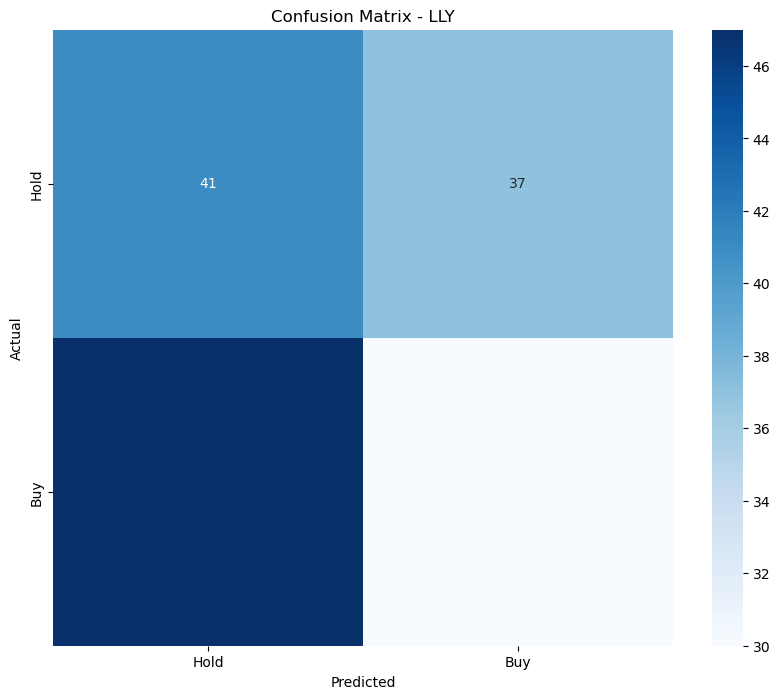

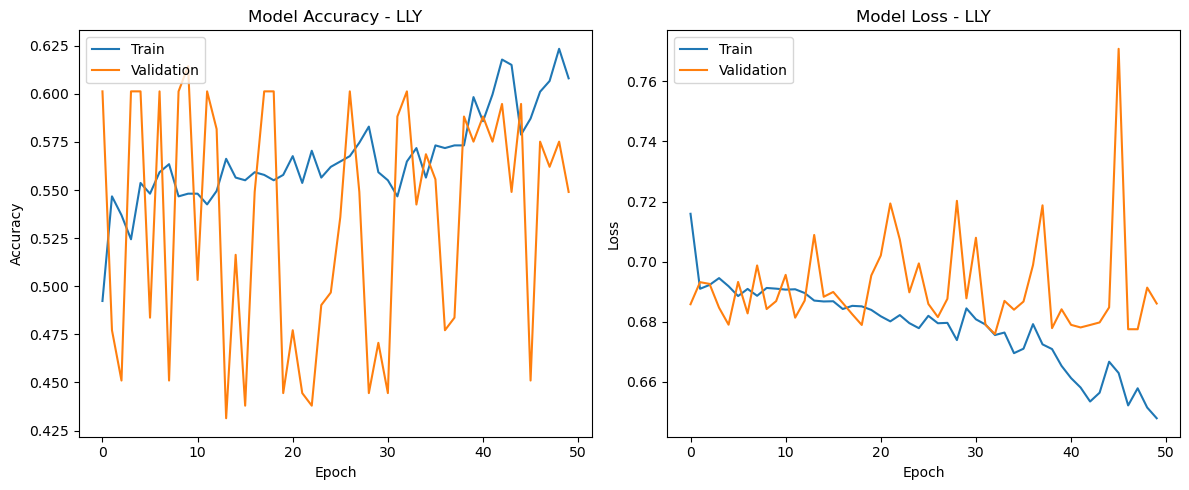

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


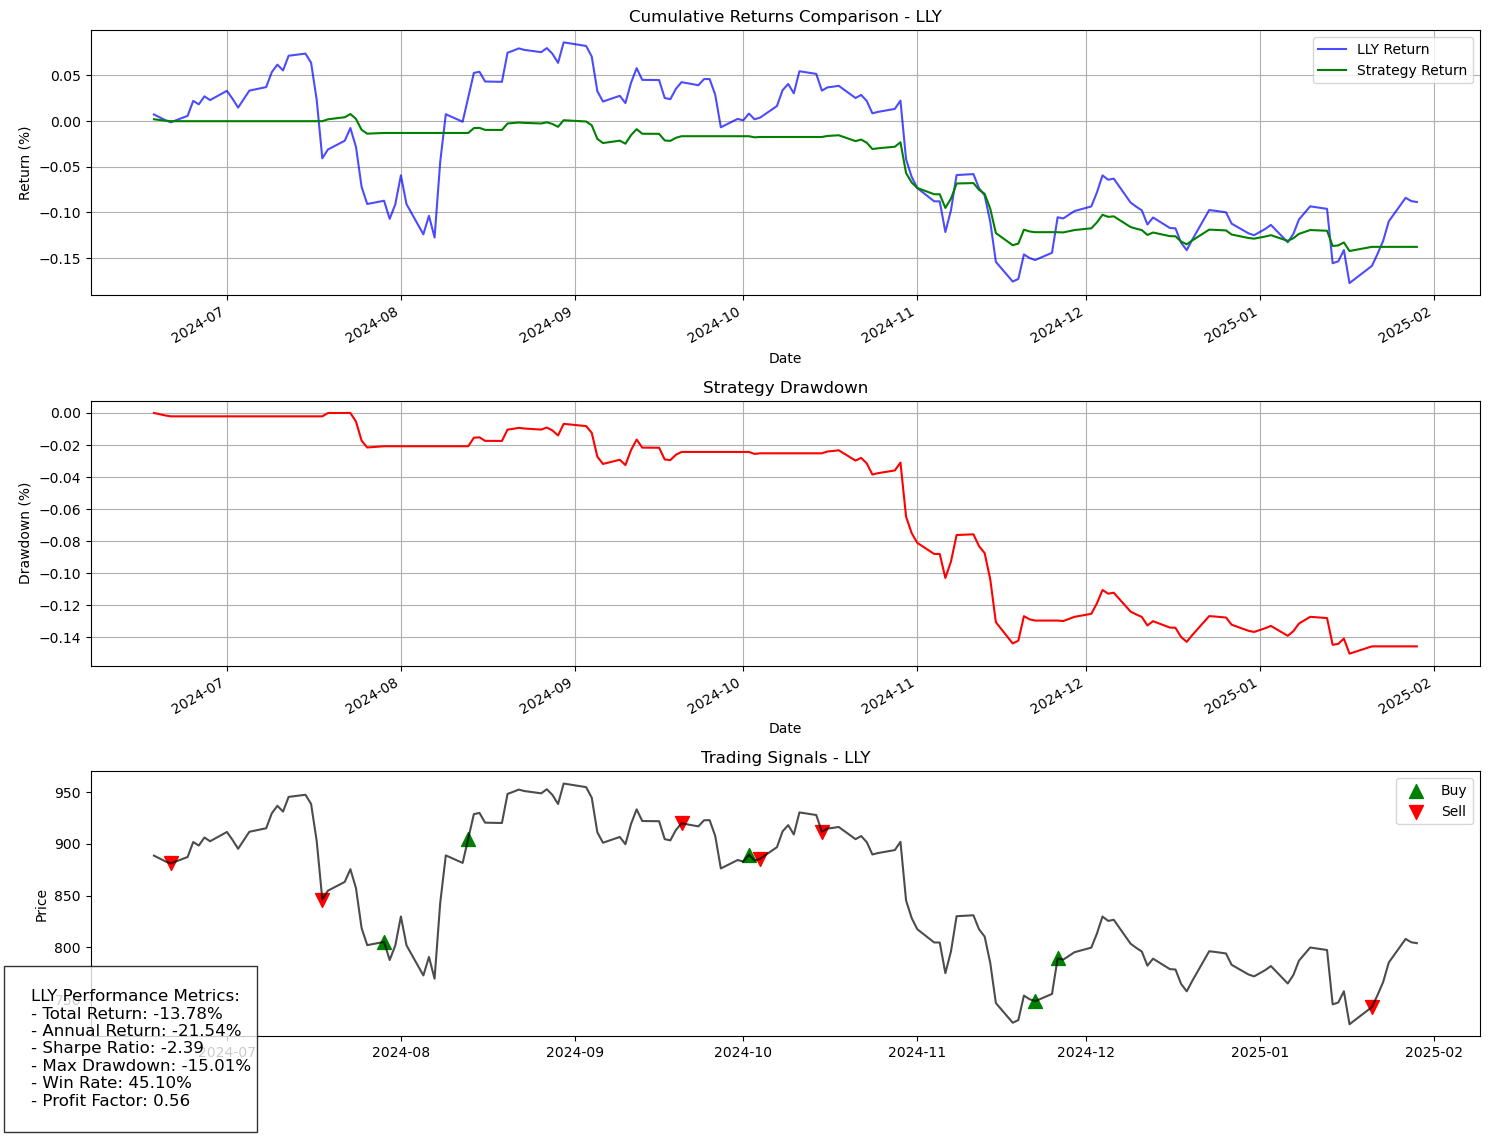

Entering position at 888.7442016601562 on 2024-06-18 00:00:00
Take-profit triggered at 936.9169921875 on 2024-07-10 00:00:00, return: 5.42%
Entering position at 905.2836303710938 on 2024-08-13 00:00:00
Take-profit triggered at 952.5923461914062 on 2024-08-22 00:00:00, return: 5.23%
Entering position at 951.1646728515624 on 2024-08-23 00:00:00
Stop-loss triggered at 911.2408447265624 on 2024-09-05 00:00:00, return: -4.20%
Entering position at 901.2174682617188 on 2024-09-06 00:00:00
Stop-loss triggered at 876.338623046875 on 2024-09-27 00:00:00, return: -2.76%
Entering position at 889.5966796875 on 2024-10-02 00:00:00
Stop-loss triggered at 845.4298706054688 on 2024-10-30 00:00:00, return: -4.96%
Entering position at 789.3200073242188 on 2024-11-26 00:00:00
Take-profit triggered at 829.8400268554688 on 2024-12-04 00:00:00, return: 5.13%
Entering position at 825.6199951171875 on 2024-12-05 00:00:00
Stop-loss triggered at 803.5800170898438 on 2024-12-09 00:00:00, return: -2.67%
Entering p

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.5026 - loss: 0.7158 - val_accuracy: 0.5948 - val_loss: 0.6820
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.4815 - loss: 0.7014 - val_accuracy: 0.4052 - val_loss: 0.7019
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5059 - loss: 0.6958 - val_accuracy: 0.4052 - val_loss: 0.7138
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5451 - loss: 0.6927 - val_accuracy: 0.4052 - val_loss: 0.7298
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5368 - loss: 0.6935 - val_accuracy: 0.4052 - val_loss: 0.6964
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4622 - loss: 0.6977 - val_accuracy: 0.4052 - val_loss: 0.6937
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4860 - loss: 0.6933 - val_accuracy: 0.5621 - val_loss: 0.6931
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4697 - loss: 0.6932 - val_accuracy: 0.5948 - val_los

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
Accuracy: 0.3935
Precision: 0.1549
Recall: 0.3935
F1 Score: 0.2223

Classification Report:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56        61
           1       0.00      0.00      0.00        94

    accuracy                           0.39       155
   macro avg       0.20      0.50      0.28       155
weighted avg       0.15      0.39      0.22       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

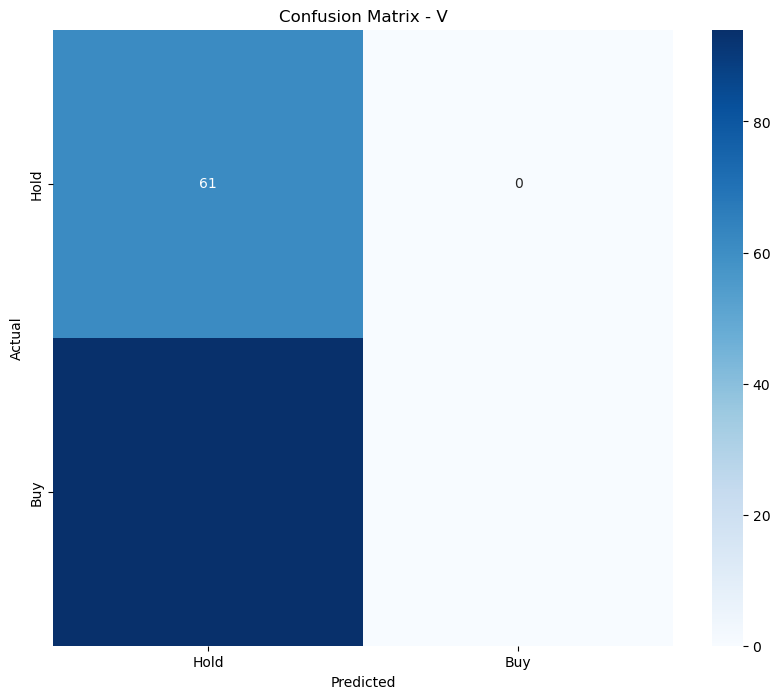

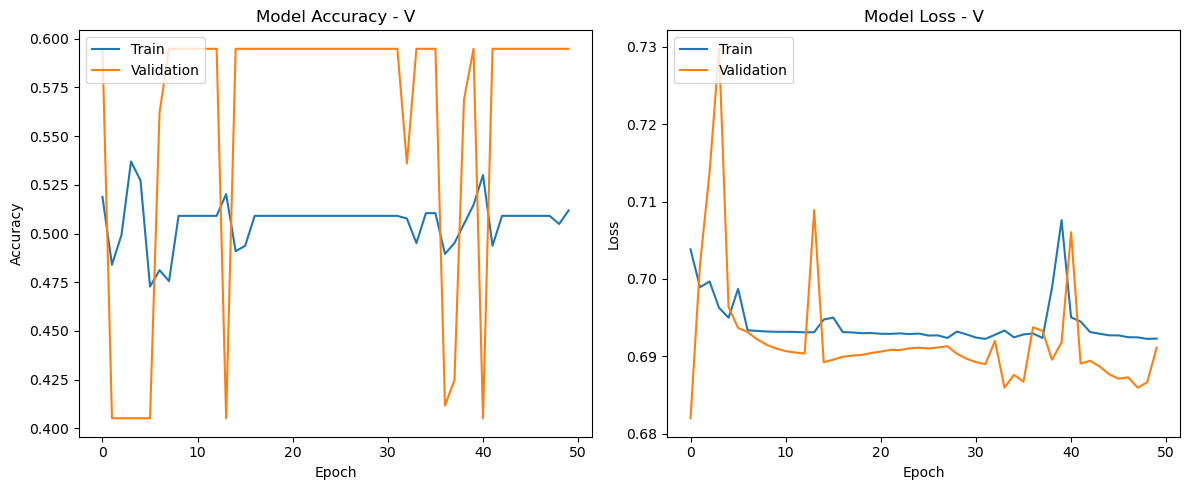

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


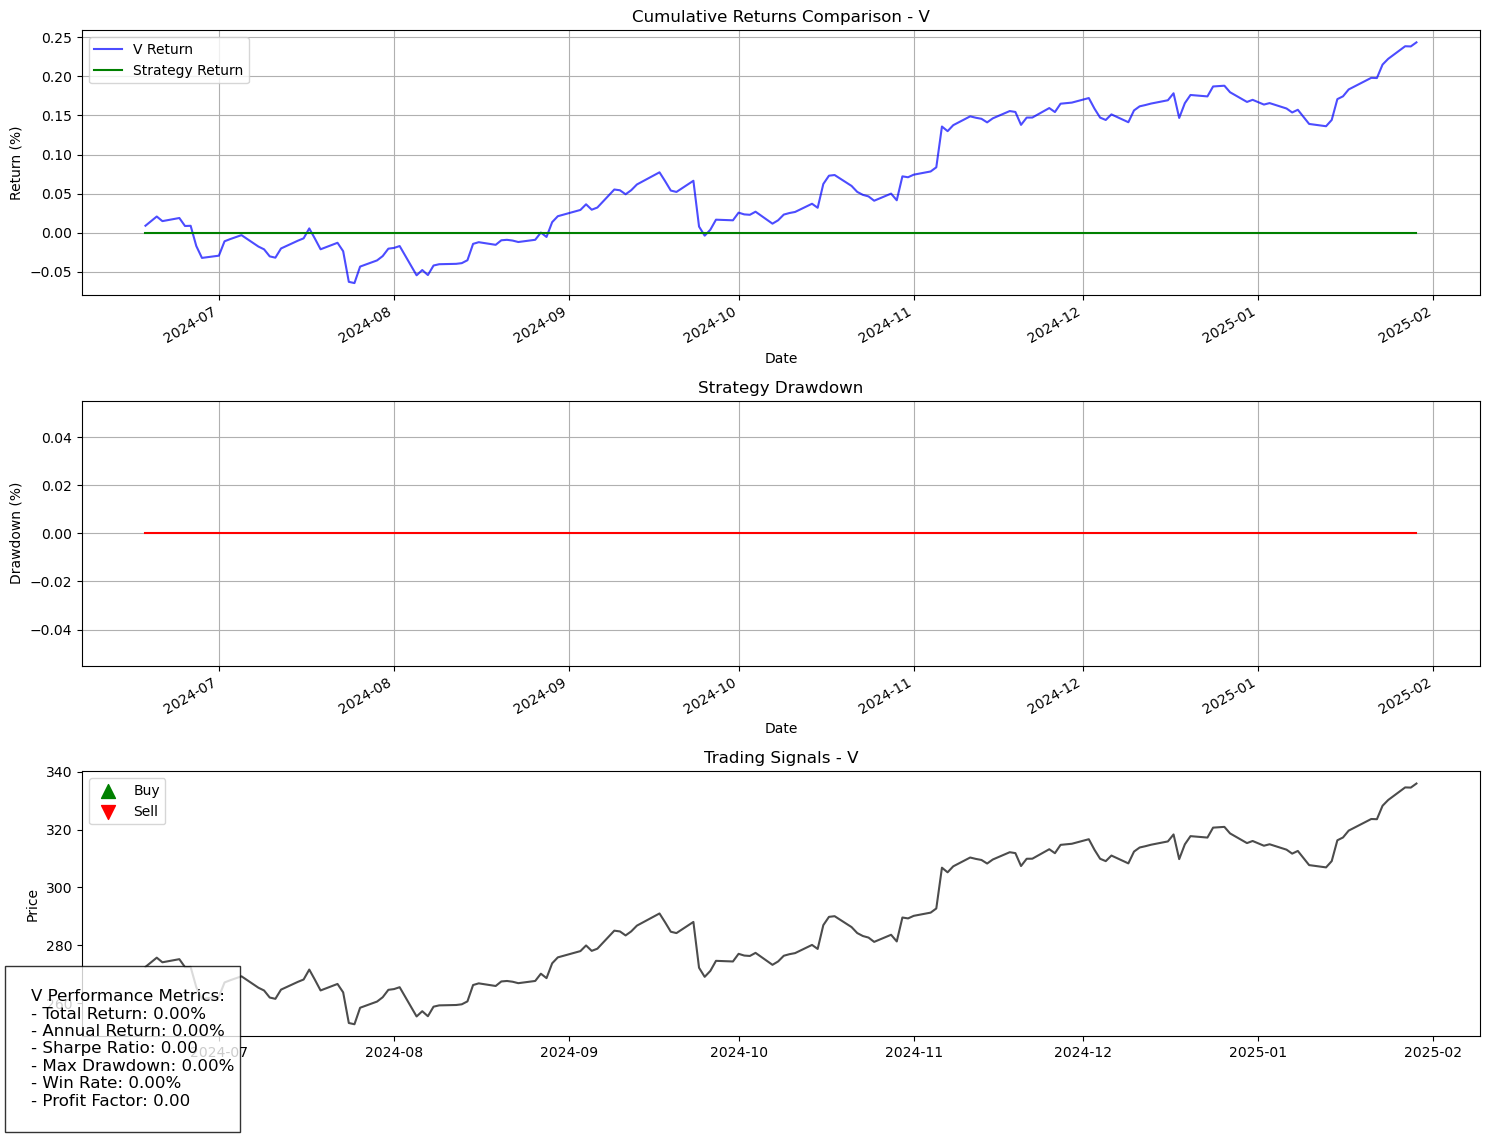


Performance Metrics V: {'total_return': 0.0, 'annual_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'win_rate': 0.0, 'profit_factor': 0.0, 'accuracy': 0.3935483870967742, 'precision': 0.15488033298647244, 'recall': 0.3935483870967742, 'f1_score': 0.22228195937873357}

Trades V: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing COST...
Top 15 features by mutual information:
              Feature  MI Score
10        Returns_10d  0.036972
7          Returns_5d  0.027757
3         Price_Range  0.026568
27        BB_Width_50  0.025008
38   Channel_Width_20  0.019818
32        Signal_Line  0.016979
54                VIX  0.016145
28              RSI_9  0.015233
33     MACD_Histogram  0.014295
55          VIX_MA_10  0.013199
52  Market_Volatility  0.012782
34        Momentum_14  0.012711
41       Volume_Ratio  0.012448
29             RSI_14  0.010908
25      Volume_MA_60d  0.010267
Selected 15 features
Epoch 1/50


c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.4370 - loss: 0.7278 - val_accuracy: 0.6209 - val_loss: 0.6869
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5119 - loss: 0.6948 - val_accuracy: 0.6209 - val_loss: 0.6744
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5231 - loss: 0.6942 - val_accuracy: 0.6209 - val_loss: 0.6705
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5230 - loss: 0.6922 - val_accuracy: 0.6209 - val_loss: 0.6691
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5257 - loss: 0.6908 - val_accuracy: 0.6209 - val_loss: 0.6713
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5373 - loss: 0.6882 - val_accuracy: 0.6209 - val_loss: 0.6675
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5537 - loss: 0.6878 - val_accuracy: 0.6209 - val_loss: 0.6768
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5555 - loss: 0.6868 - val_accuracy: 0.6209 - val_los

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step
Accuracy: 0.4968
Precision: 0.4983
Recall: 0.4968
F1 Score: 0.3794

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.94      0.65        77
           1       0.50      0.06      0.11        78

    accuracy                           0.50       155
   macro avg       0.50      0.50      0.38       155
weighted avg       0.50      0.50      0.38       155



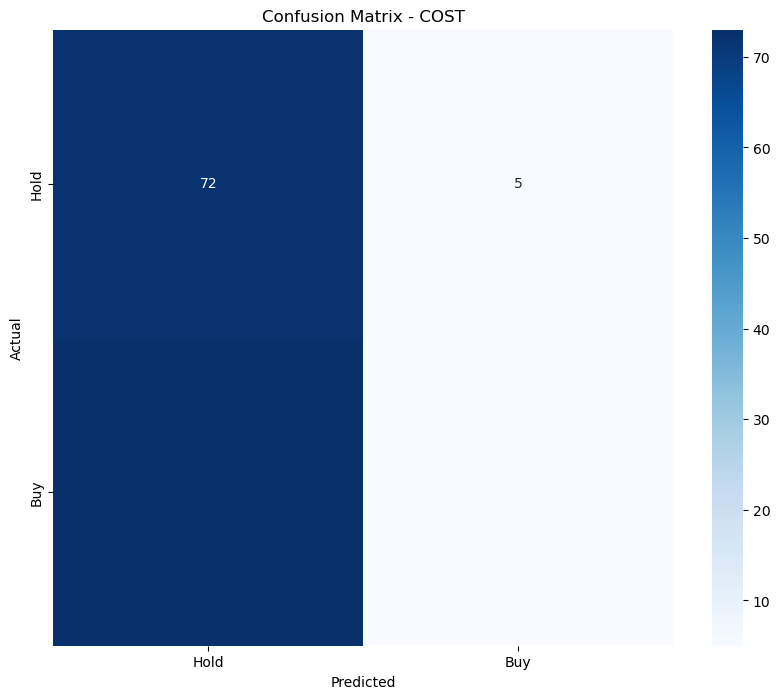

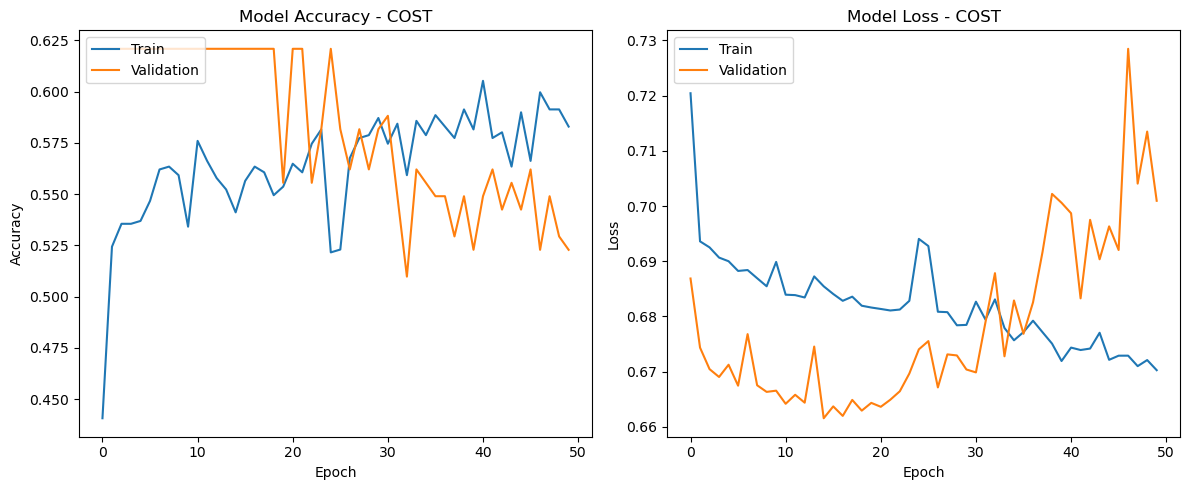

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


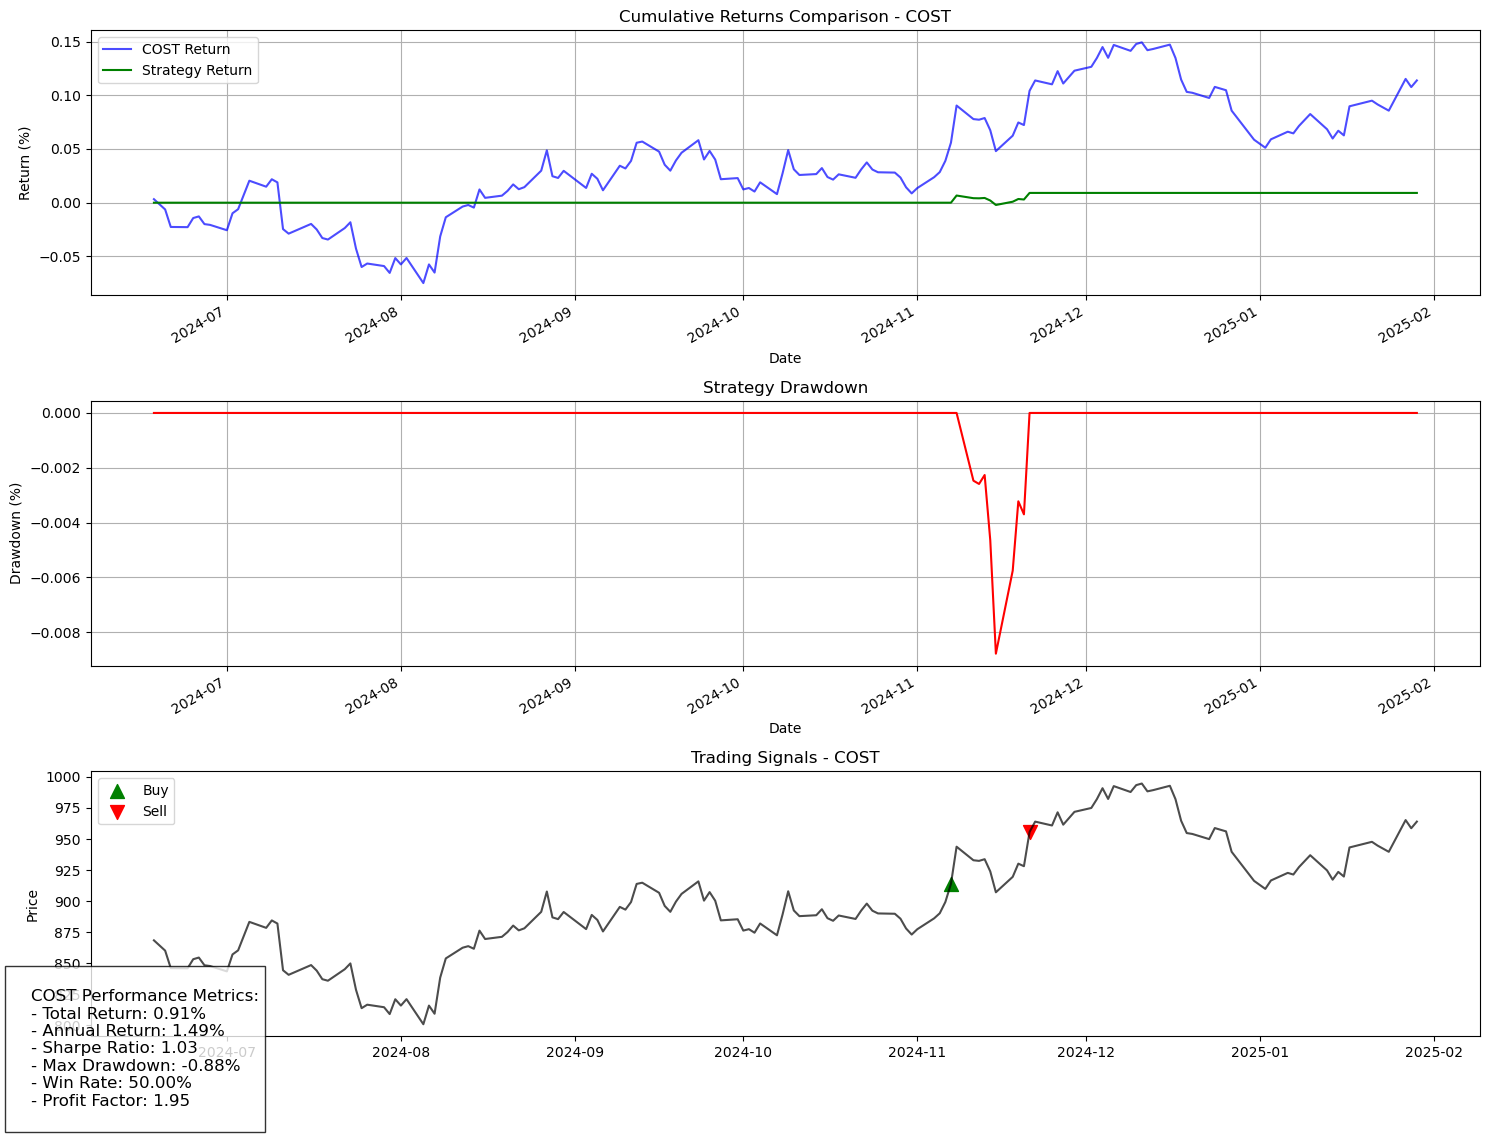

Entering position at 913.9299926757812 on 2024-11-07 00:00:00
Take-profit triggered at 964.010009765625 on 2024-11-22 00:00:00, return: 5.48%

Performance Metrics COST: {'total_return': 0.00909813884891042, 'annual_return': 0.014930914504593273, 'sharpe_ratio': 1.0306308159715603, 'max_drawdown': -0.008788307802503725, 'win_rate': 0.5, 'profit_factor': 1.9465390042629322, 'accuracy': 0.4967741935483871, 'precision': 0.4982869855394883, 'recall': 0.4967741935483871, 'f1_score': 0.37941666006182134}

Trades COST: {'total_return': 0.05479633833136486, 'sharpe_ratio': 1.2792042981336618, 'max_drawdown': 0.0, 'num_trades': 1, 'win_rate': 1.0}
Processing MA...
Top 15 features by mutual information:
             Feature  MI Score
46     Profit_Margin  0.046112
28             RSI_9  0.035749
35            ROC_14  0.032400
39  Channel_Width_50  0.017700
30            RSI_25  0.017633
0              Close  0.014600
7         Returns_5d  0.013019
20     Volatility_5d  0.012219
6              EMA_

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.4792 - loss: 0.7178 - val_accuracy: 0.3987 - val_loss: 0.7320
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5113 - loss: 0.6937 - val_accuracy: 0.4444 - val_loss: 0.7158
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5294 - loss: 0.6934 - val_accuracy: 0.4118 - val_loss: 0.7111
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5111 - loss: 0.6962 - val_accuracy: 0.3987 - val_loss: 0.7217
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5272 - loss: 0.6947 - val_accuracy: 0.3987 - val_loss: 0.7130
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5308 - loss: 0.6950 - val_accuracy: 0.3660 - val_loss: 0.7181
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5245 - loss: 0.6960 - val_accuracy: 0.4444 - val_loss: 0.7024
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5089 - loss: 0.6951 - val_accuracy: 0.6013 - val_

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step
Accuracy: 0.5161
Precision: 0.5247
Recall: 0.5161
F1 Score: 0.5187

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.50      0.47        66
           1       0.59      0.53      0.56        89

    accuracy                           0.52       155
   macro avg       0.51      0.51      0.51       155
weighted avg       0.52      0.52      0.52       155



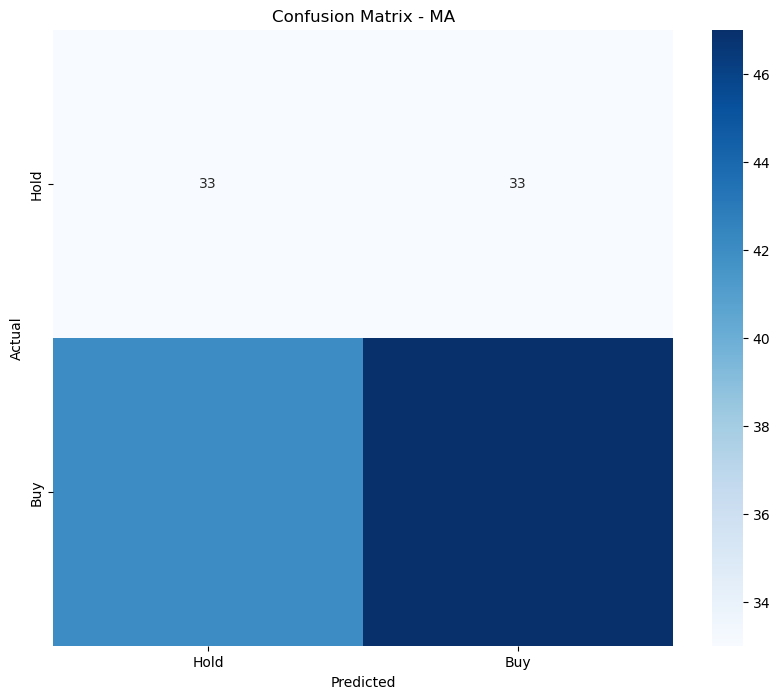

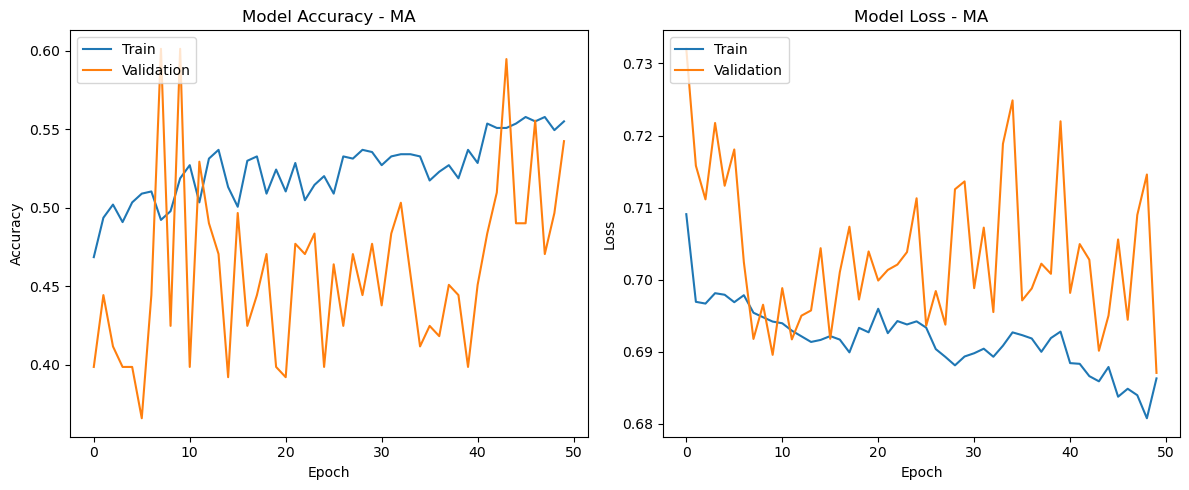

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


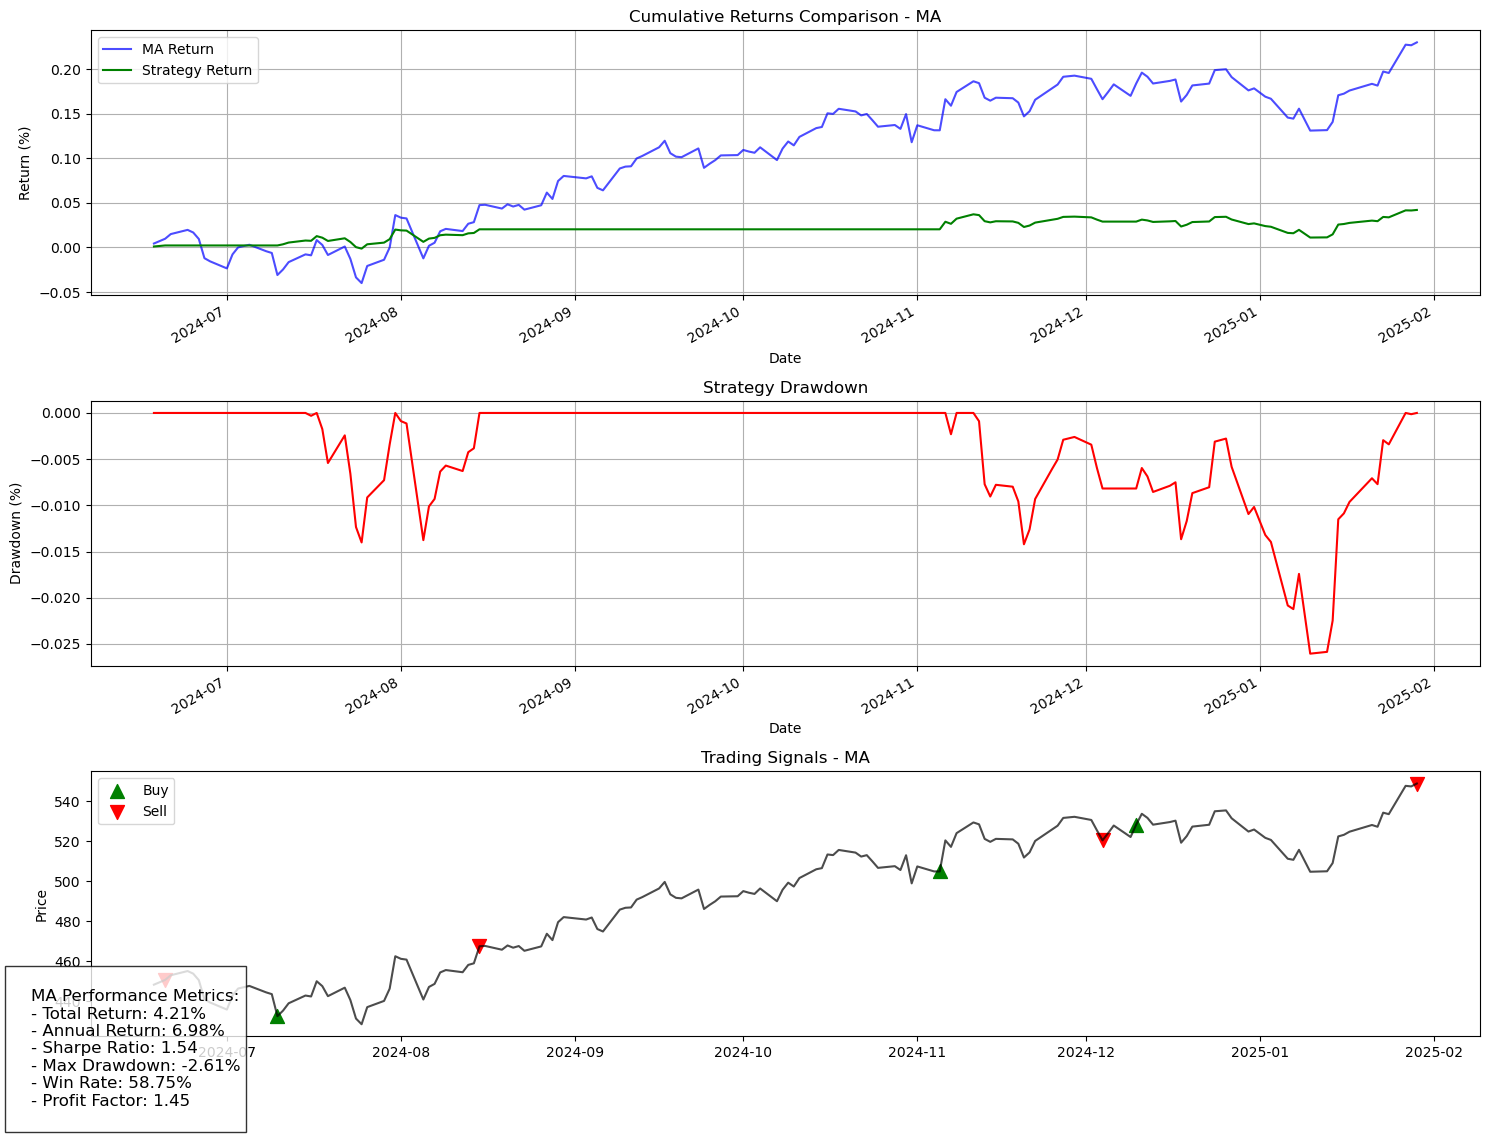

Entering position at 448.18695068359375 on 2024-06-18 00:00:00
Stop-loss triggered at 435.7403259277344 on 2024-07-01 00:00:00, return: -2.78%
Entering position at 432.4268798828125 on 2024-07-10 00:00:00
Take-profit triggered at 462.4127502441406 on 2024-07-31 00:00:00, return: 6.93%
Entering position at 461.1163635253906 on 2024-08-01 00:00:00
Stop-loss triggered at 440.7634887695313 on 2024-08-05 00:00:00, return: -4.41%
Entering position at 447.04583740234375 on 2024-08-06 00:00:00
Take-profit triggered at 473.66119384765625 on 2024-08-27 00:00:00, return: 5.95%
Entering position at 504.8159790039063 on 2024-11-05 00:00:00
Take-profit triggered at 531.5964965820312 on 2024-11-27 00:00:00, return: 5.31%
Entering position at 532.1557006835938 on 2024-11-29 00:00:00
Stop-loss triggered at 520.373046875 on 2024-12-04 00:00:00, return: -2.21%
Entering position at 528.2314453125 on 2024-12-10 00:00:00
Stop-loss triggered at 511.1765747070313 on 2025-01-06 00:00:00, return: -3.23%
Enterin

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.5383 - loss: 0.7412 - val_accuracy: 0.5229 - val_loss: 0.6933
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5266 - loss: 0.6980 - val_accuracy: 0.5556 - val_loss: 0.6926
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5174 - loss: 0.6936 - val_accuracy: 0.5033 - val_loss: 0.6925
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5227 - loss: 0.6922 - val_accuracy: 0.5425 - val_loss: 0.6922
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5264 - loss: 0.6928 - val_accuracy: 0.5556 - val_loss: 0.6930
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5342 - loss: 0.6928 - val_accuracy: 0.5229 - val_loss: 0.6914
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5272 - loss: 0.6928 - val_accuracy: 0.5621 - val_loss: 0.6918
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5250 - loss: 0.6921 - val_accuracy: 0.5621 - val_loss:

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step
Accuracy: 0.4516
Precision: 0.2125
Recall: 0.4516
F1 Score: 0.2890

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.97      0.62        72
           1       0.00      0.00      0.00        83

    accuracy                           0.45       155
   macro avg       0.23      0.49      0.31       155
weighted avg       0.21      0.45      0.29       155



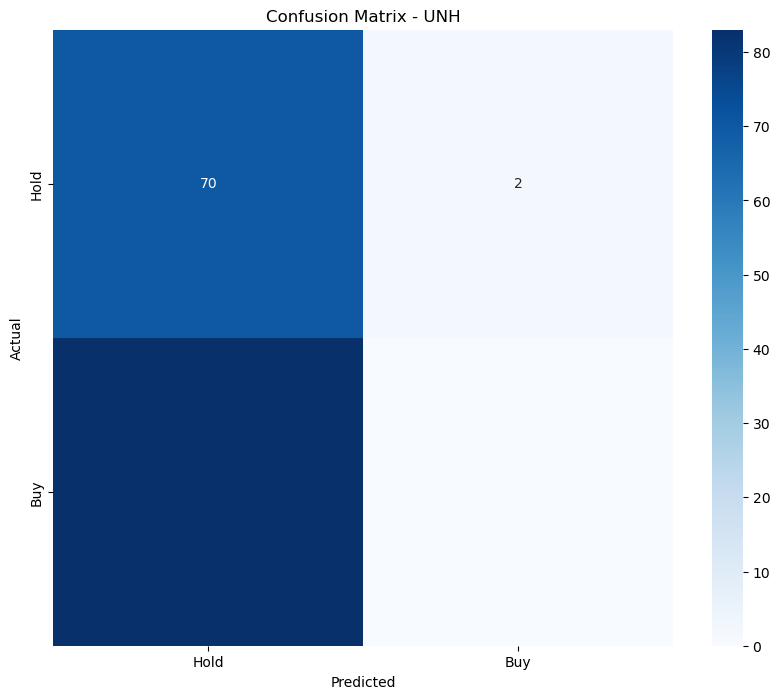

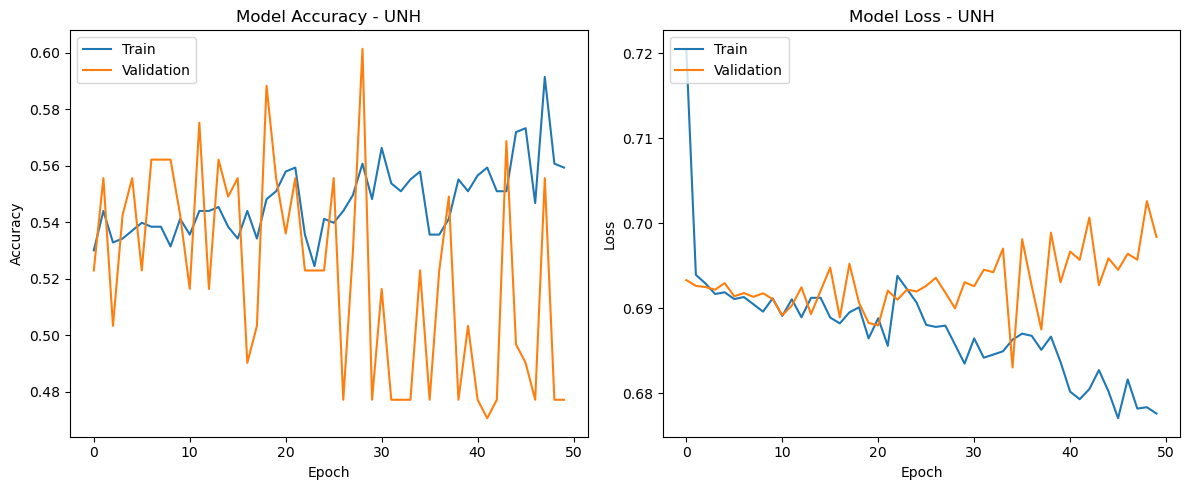

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


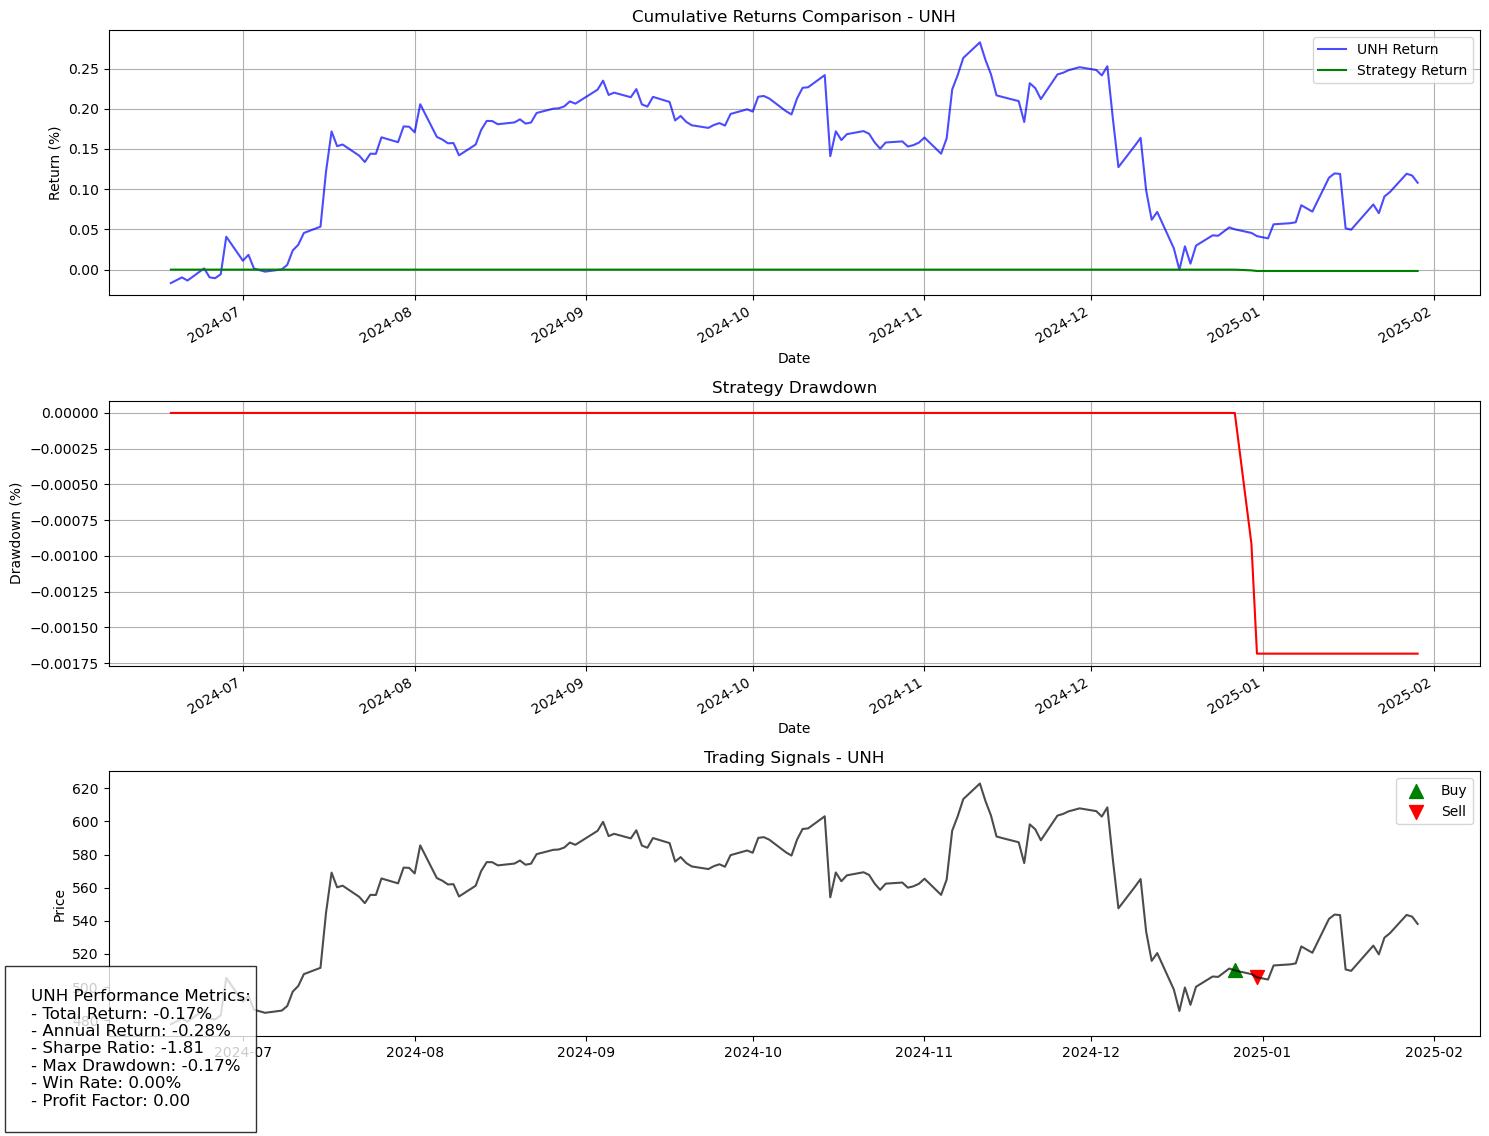

Entering position at 509.989990234375 on 2024-12-27 00:00:00
Take-profit triggered at 541.1400146484375 on 2025-01-13 00:00:00, return: 6.11%

Performance Metrics UNH: {'total_return': -0.001683280984177138, 'annual_return': -0.0027529842316351694, 'sharpe_ratio': -1.8082480372040535, 'max_drawdown': -0.001683280984177138, 'win_rate': 0.0, 'profit_factor': 0.0, 'accuracy': 0.45161290322580644, 'precision': 0.21252371916508536, 'recall': 0.45161290322580644, 'f1_score': 0.2890322580645161}

Trades UNH: {'total_return': 0.06107967805357693, 'sharpe_ratio': 1.279204298133663, 'max_drawdown': 0.0, 'num_trades': 1, 'win_rate': 1.0}
Processing NFLX...
Error processing NFLX: Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Processing WMT...
Top 15 features by mutual information:
              Feature  MI Score
34        Momentum_14  0.030073
42      Volume_StdDev  0.020342
38   Channel_Width_20  0.019762
35             ROC_14  0.019714
11              MA_20  0.01

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.4891 - loss: 0.7710 - val_accuracy: 0.5621 - val_loss: 0.6872
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5236 - loss: 0.6974 - val_accuracy: 0.5621 - val_loss: 0.6863
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5213 - loss: 0.6970 - val_accuracy: 0.5621 - val_loss: 0.6855
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5194 - loss: 0.6985 - val_accuracy: 0.5621 - val_loss: 0.6864
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5177 - loss: 0.6977 - val_accuracy: 0.5621 - val_loss: 0.6863
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5194 - loss: 0.6953 - val_accuracy: 0.5621 - val_loss: 0.6900
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5265 - loss: 0.6918 - val_accuracy: 0.5621 - val_loss: 0.6866
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5285 - loss: 0.6926 - val_accuracy: 0.5621 - val_lo

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Accuracy: 0.4710
Precision: 0.5171
Recall: 0.4710
F1 Score: 0.4670

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.63      0.49        62
           1       0.60      0.37      0.45        93

    accuracy                           0.47       155
   macro avg       0.50      0.50      0.47       155
weighted avg       0.52      0.47      0.47       155



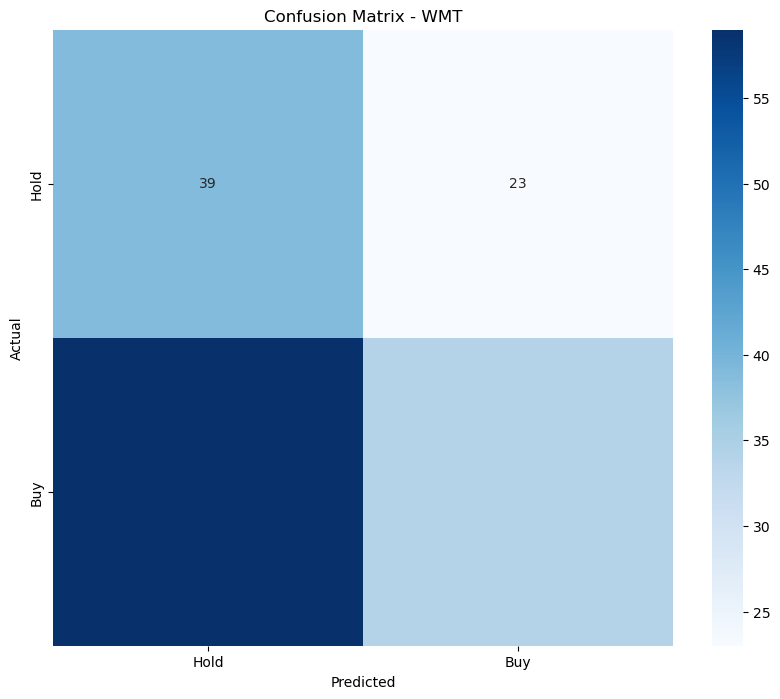

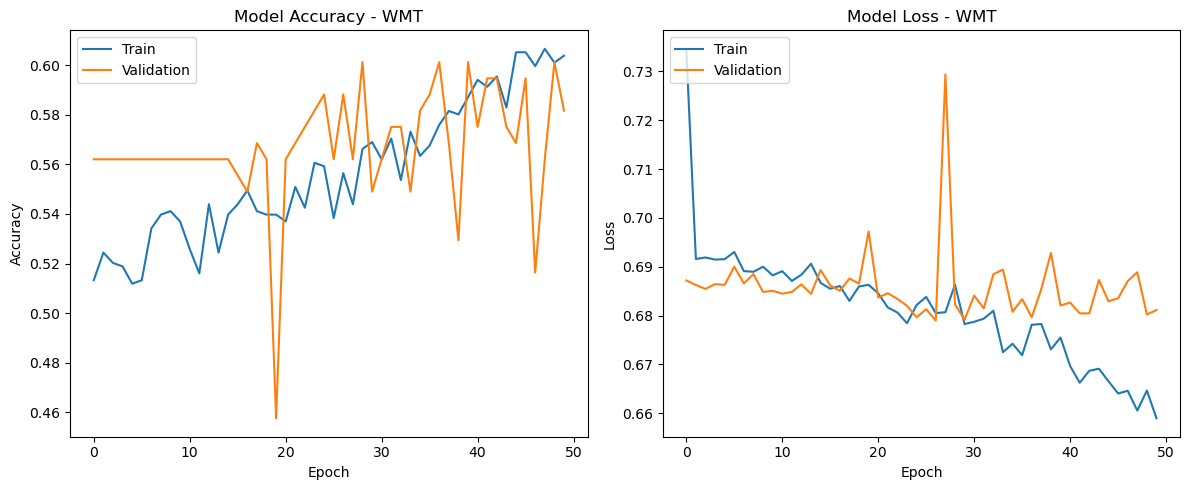

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


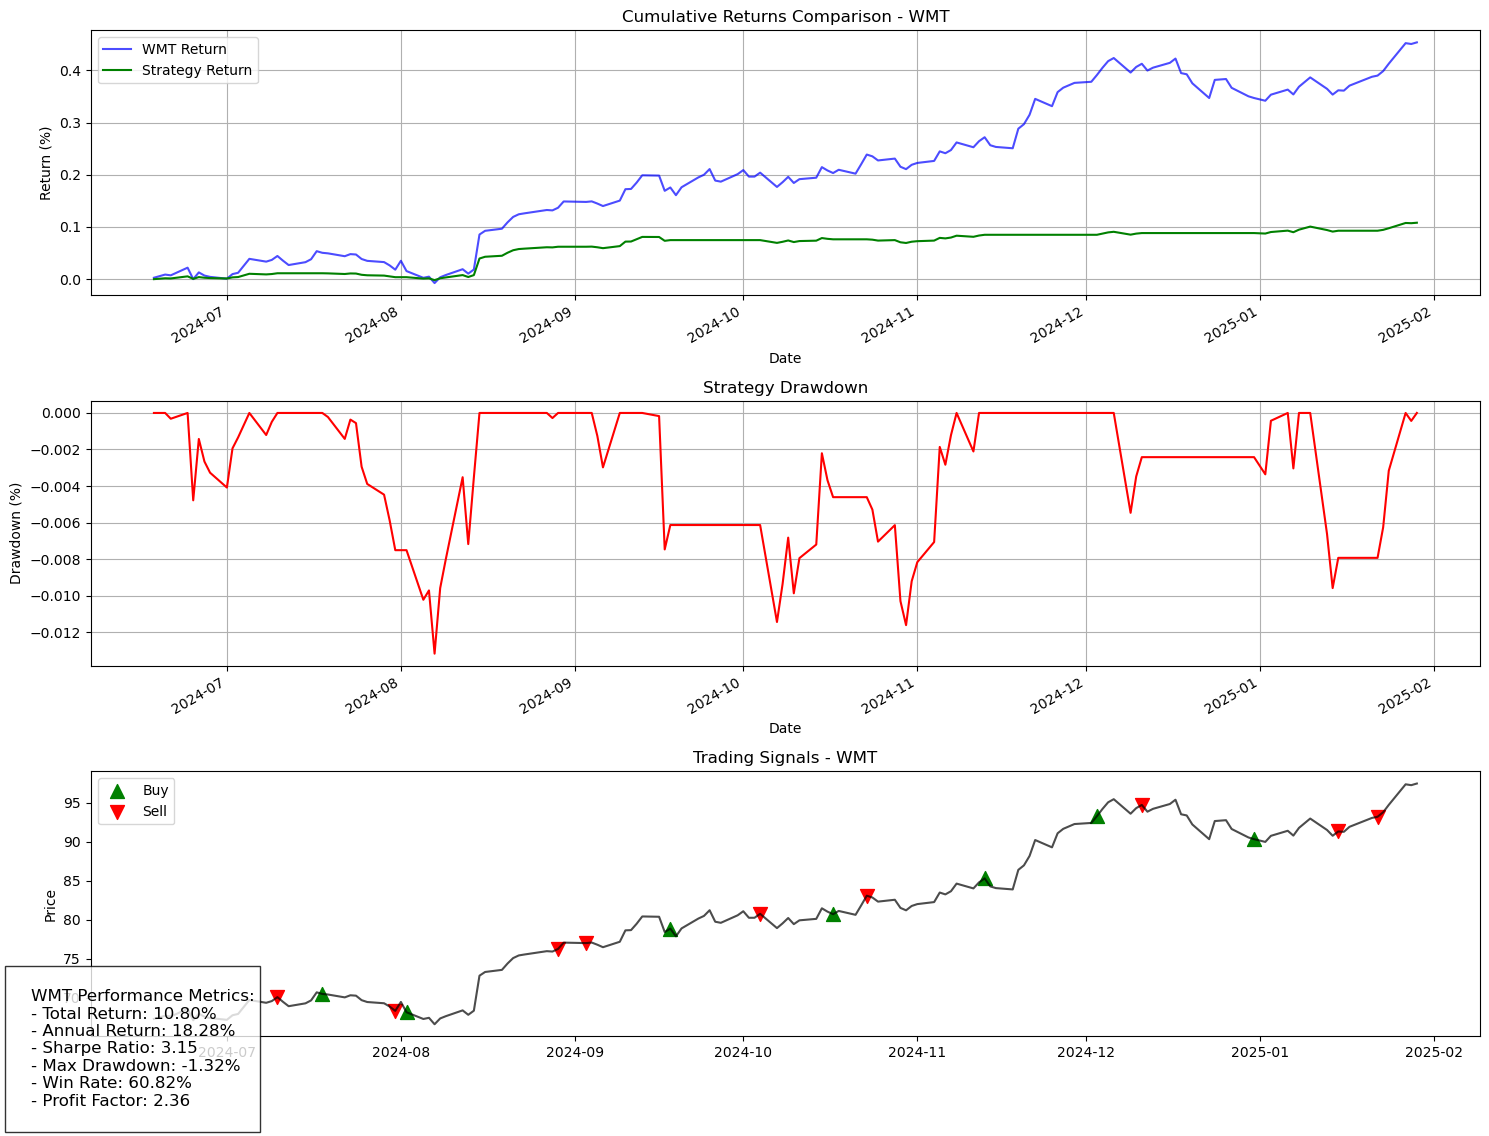

Entering position at 67.25884246826172 on 2024-06-18 00:00:00
Take-profit triggered at 70.6715316772461 on 2024-07-17 00:00:00, return: 5.07%
Entering position at 70.46259307861328 on 2024-07-18 00:00:00
Stop-loss triggered at 68.8408203125 on 2024-07-30 00:00:00, return: -2.30%
Entering position at 68.114501953125 on 2024-08-02 00:00:00
Stop-loss triggered at 66.57232666015625 on 2024-08-07 00:00:00, return: -2.26%
Entering position at 67.31854248046875 on 2024-08-08 00:00:00
Take-profit triggered at 72.81068420410156 on 2024-08-15 00:00:00, return: 8.16%
Entering position at 73.2876205444336 on 2024-08-16 00:00:00
Take-profit triggered at 77.05927276611328 on 2024-08-30 00:00:00, return: 5.15%
Entering position at 93.30328369140624 on 2024-12-03 00:00:00
Stop-loss triggered at 90.3499984741211 on 2024-12-23 00:00:00, return: -3.17%
Entering position at 90.3499984741211 on 2024-12-31 00:00:00
Take-profit triggered at 97.4000015258789 on 2025-01-27 00:00:00, return: 7.80%

Performance 

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.5150 - loss: 0.7149 - val_accuracy: 0.5490 - val_loss: 0.6904
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5092 - loss: 0.6952 - val_accuracy: 0.5490 - val_loss: 0.6911
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5132 - loss: 0.6944 - val_accuracy: 0.5490 - val_loss: 0.6932
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5086 - loss: 0.6945 - val_accuracy: 0.5490 - val_loss: 0.6969
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.4921 - loss: 0.6972 - val_accuracy: 0.5490 - val_loss: 0.6906
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4871 - loss: 0.6957 - val_accuracy: 0.5490 - val_loss: 0.6905
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5003 - loss: 0.6960 - val_accuracy: 0.5490 - val_loss: 0.6949
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5046 - loss: 0.6962 - val_accuracy: 0.5490 - val_

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
Accuracy: 0.4645
Precision: 0.5015
Recall: 0.4645
F1 Score: 0.3578

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.92      0.61        71
           1       0.54      0.08      0.14        84

    accuracy                           0.46       155
   macro avg       0.50      0.50      0.38       155
weighted avg       0.50      0.46      0.36       155



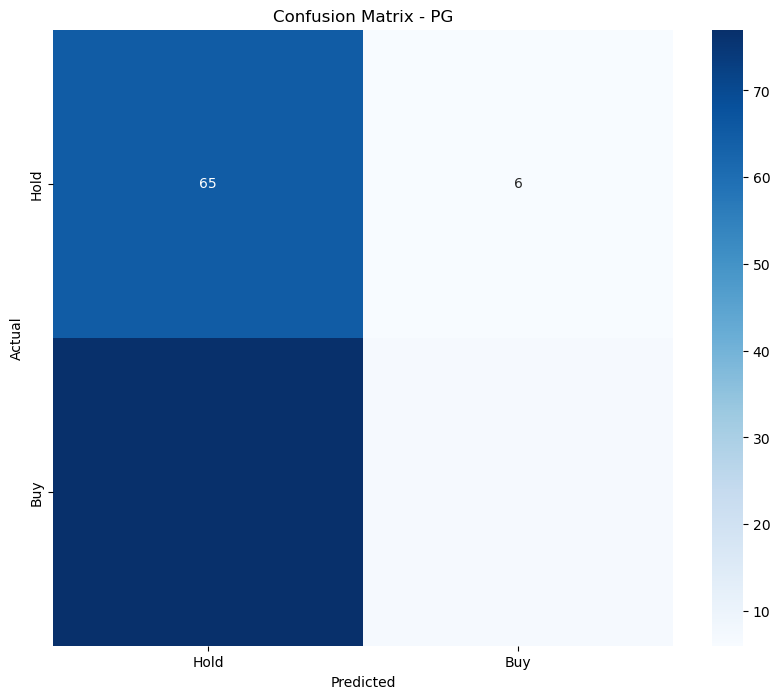

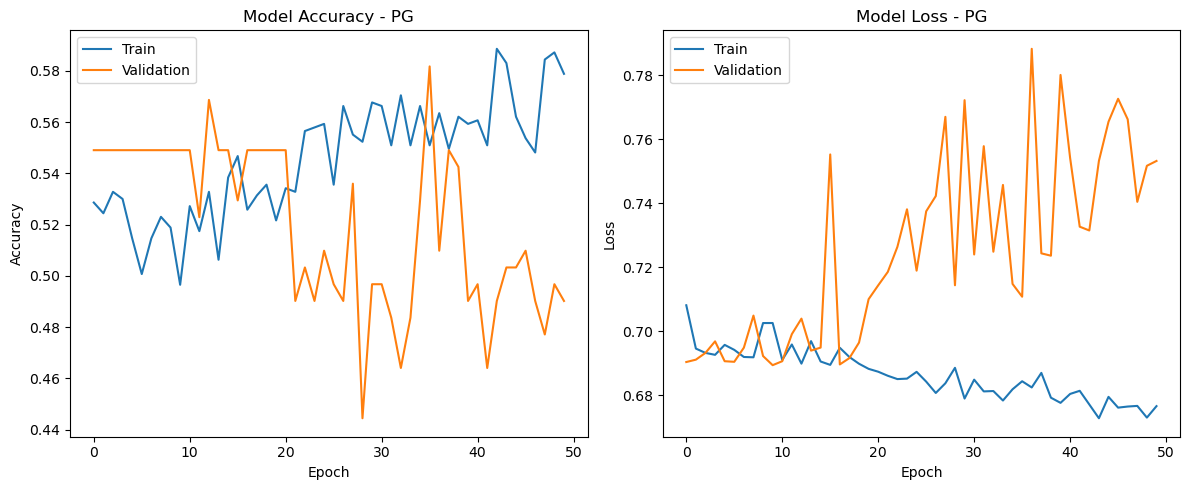

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


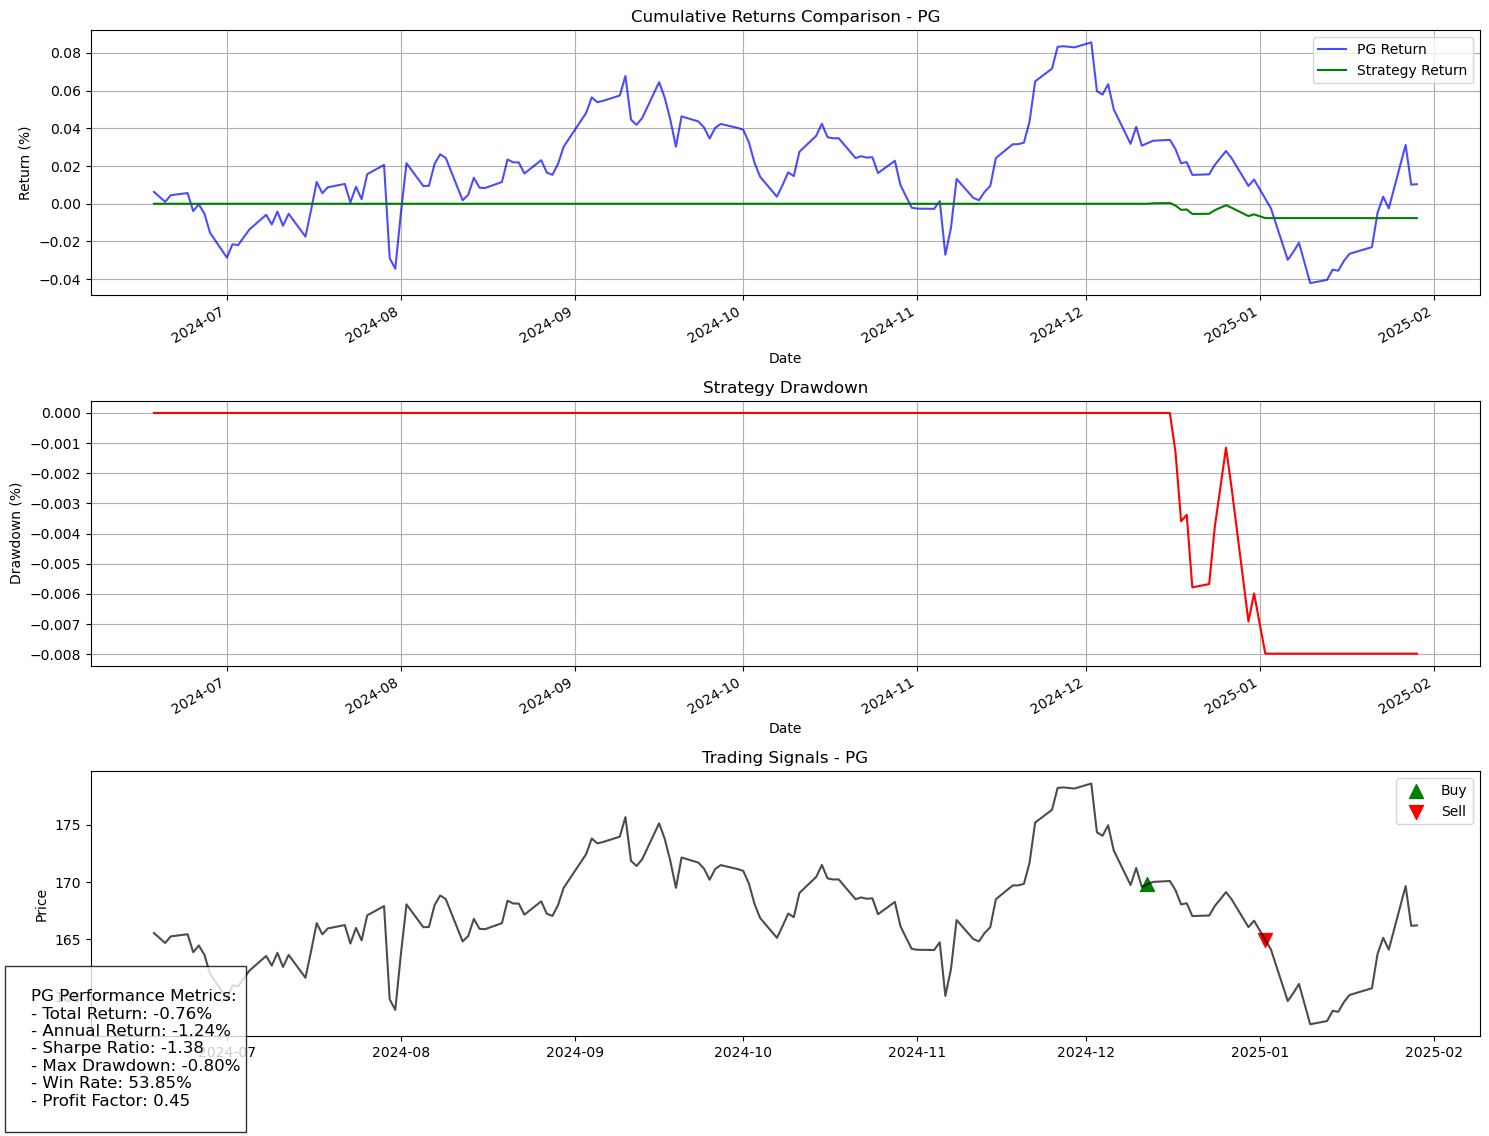

Entering position at 169.8145294189453 on 2024-12-12 00:00:00
Stop-loss triggered at 166.07730102539062 on 2024-12-30 00:00:00, return: -2.20%
Entering position at 166.6339111328125 on 2024-12-31 00:00:00
Stop-loss triggered at 159.62664794921875 on 2025-01-06 00:00:00, return: -4.21%

Performance Metrics PG: {'total_return': -0.007612082259418562, 'annual_return': -0.012425937613478766, 'sharpe_ratio': -1.3829407657685824, 'max_drawdown': -0.007983022742034551, 'win_rate': 0.5384615384615384, 'profit_factor': 0.44680954176571785, 'accuracy': 0.4645161290322581, 'precision': 0.5014888337468982, 'recall': 0.4645161290322581, 'f1_score': 0.35778738499057755}

Trades PG: {'total_return': -0.06313408595013607, 'sharpe_ratio': -1.7311779615147251, 'max_drawdown': 0.06313408595013607, 'num_trades': 2, 'win_rate': 0.0}
Processing JNJ...
Top 15 features by mutual information:
             Feature  MI Score
20     Volatility_5d  0.028997
5               MA_5  0.026926
17            MA_200  0.02

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.4957 - loss: 0.8068 - val_accuracy: 0.5490 - val_loss: 0.6894
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4949 - loss: 0.6954 - val_accuracy: 0.5490 - val_loss: 0.6902
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4627 - loss: 0.6947 - val_accuracy: 0.4510 - val_loss: 0.6953
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5083 - loss: 0.6926 - val_accuracy: 0.5490 - val_loss: 0.6883
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4953 - loss: 0.6940 - val_accuracy: 0.5490 - val_loss: 0.6900
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4841 - loss: 0.6944 - val_accuracy: 0.5556 - val_loss: 0.6918
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5218 - loss: 0.6913 - val_accuracy: 0.5490 - val_loss: 0.6904
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4911 - loss: 0.6938 - val_accuracy: 0.5882 - val

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  
Accuracy: 0.4710
Precision: 0.2218
Recall: 0.4710
F1 Score: 0.3016

Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        73
           1       0.00      0.00      0.00        82

    accuracy                           0.47       155
   macro avg       0.24      0.50      0.32       155
weighted avg       0.22      0.47      0.30       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

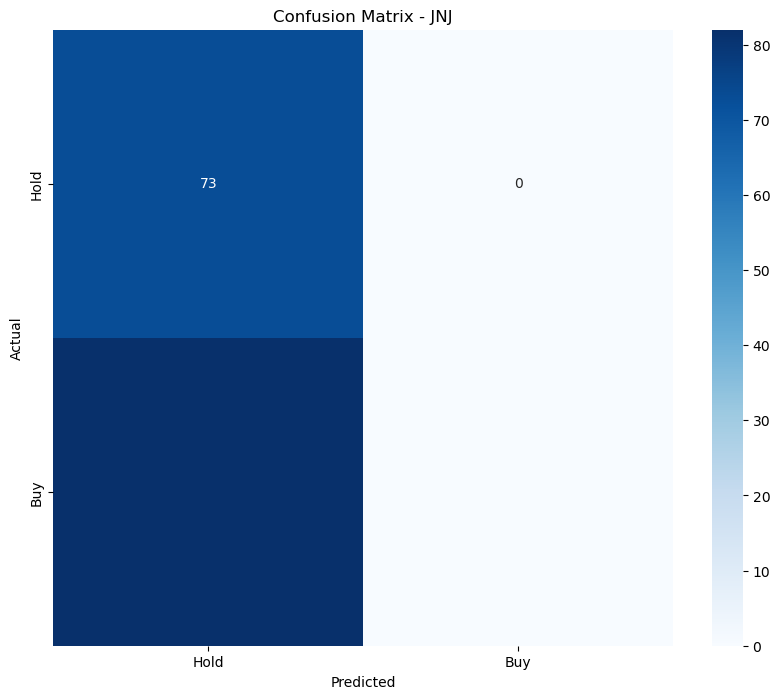

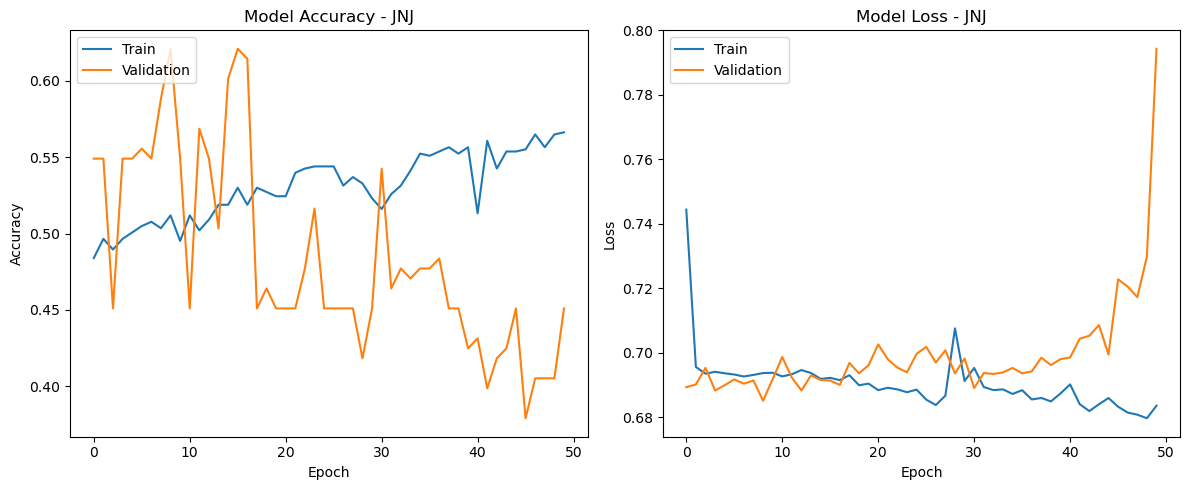

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


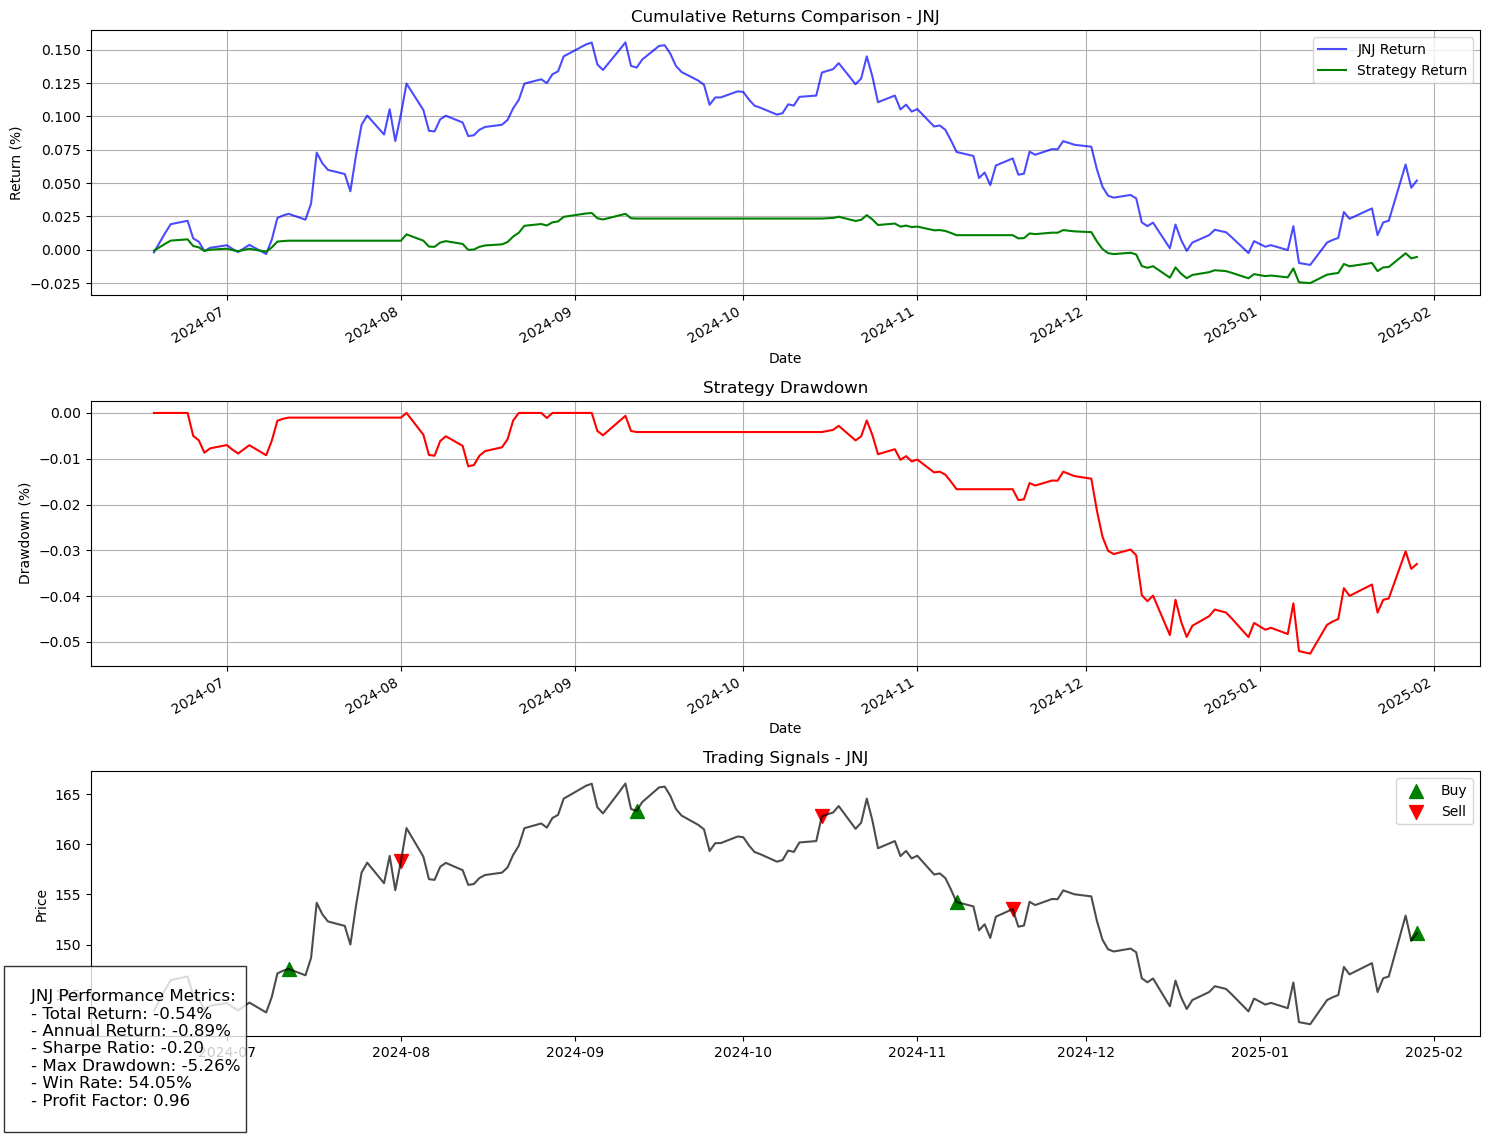


Performance Metrics JNJ: {'total_return': -0.005443321131828327, 'annual_return': -0.00889181550623297, 'sharpe_ratio': -0.1971277492678527, 'max_drawdown': -0.05257817178516955, 'win_rate': 0.5405405405405406, 'profit_factor': 0.9610189037444774, 'accuracy': 0.47096774193548385, 'precision': 0.22181061394380855, 'recall': 0.47096774193548385, 'f1_score': 0.3015846066779853}

Trades JNJ: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing HD...
Top 15 features by mutual information:
             Feature  MI Score
42     Volume_StdDev  0.031491
17            MA_200  0.025664
3        Price_Range  0.021671
29            RSI_14  0.019616
36            MFI_14  0.017158
18           EMA_200  0.017064
11             MA_20  0.016591
9             EMA_10  0.015077
7         Returns_5d  0.013243
30            RSI_25  0.012778
41      Volume_Ratio  0.011724
0              Close  0.011355
38  Channel_Width_20  0.009137
45    Dividend_Yield

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.5054 - loss: 0.7338 - val_accuracy: 0.5621 - val_loss: 0.6849
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.5414 - loss: 0.6931 - val_accuracy: 0.6013 - val_loss: 0.6819
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.5334 - loss: 0.6966 - val_accuracy: 0.6013 - val_loss: 0.6824
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5421 - loss: 0.6908 - val_accuracy: 0.5425 - val_loss: 0.7023
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5406 - loss: 0.6899 - val_accuracy: 0.5490 - val_loss: 0.6964
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.5516 - loss: 0.6891 - val_accuracy: 0.5621 - val_loss: 0.6906
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5594 - loss: 0.6890 - val_accuracy: 0.5490 - val_loss: 0.7337
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.5714 - loss: 0.6828 - val_accuracy: 0.5425 - val

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step
Accuracy: 0.4903
Precision: 0.5286
Recall: 0.4903
F1 Score: 0.4293

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.85      0.61        72
           1       0.58      0.18      0.28        83

    accuracy                           0.49       155
   macro avg       0.52      0.51      0.44       155
weighted avg       0.53      0.49      0.43       155



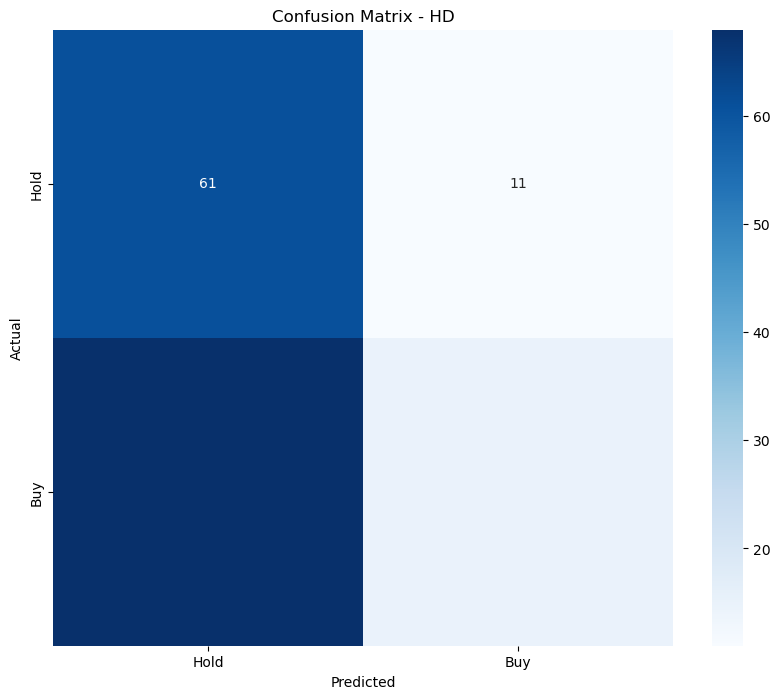

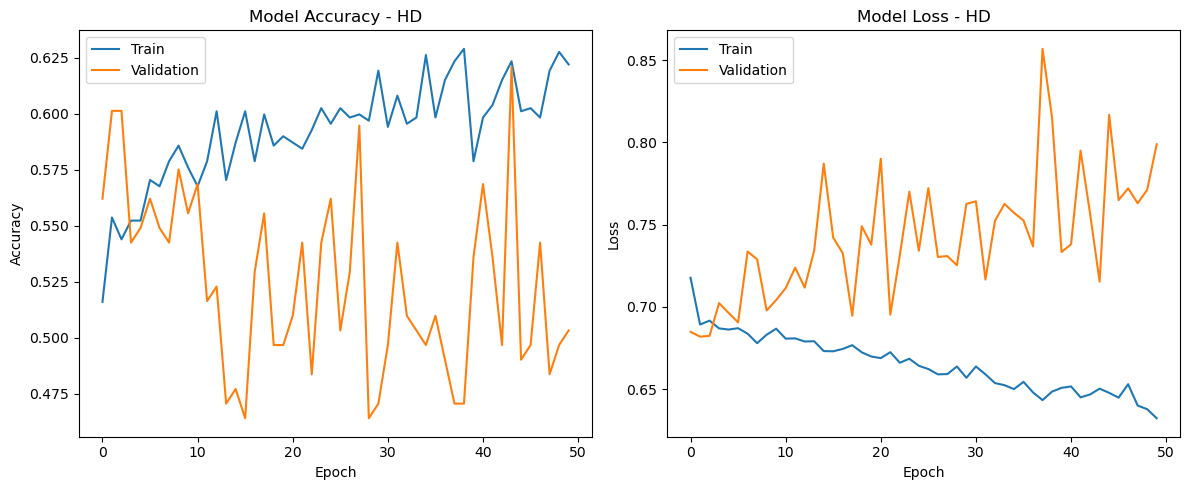

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


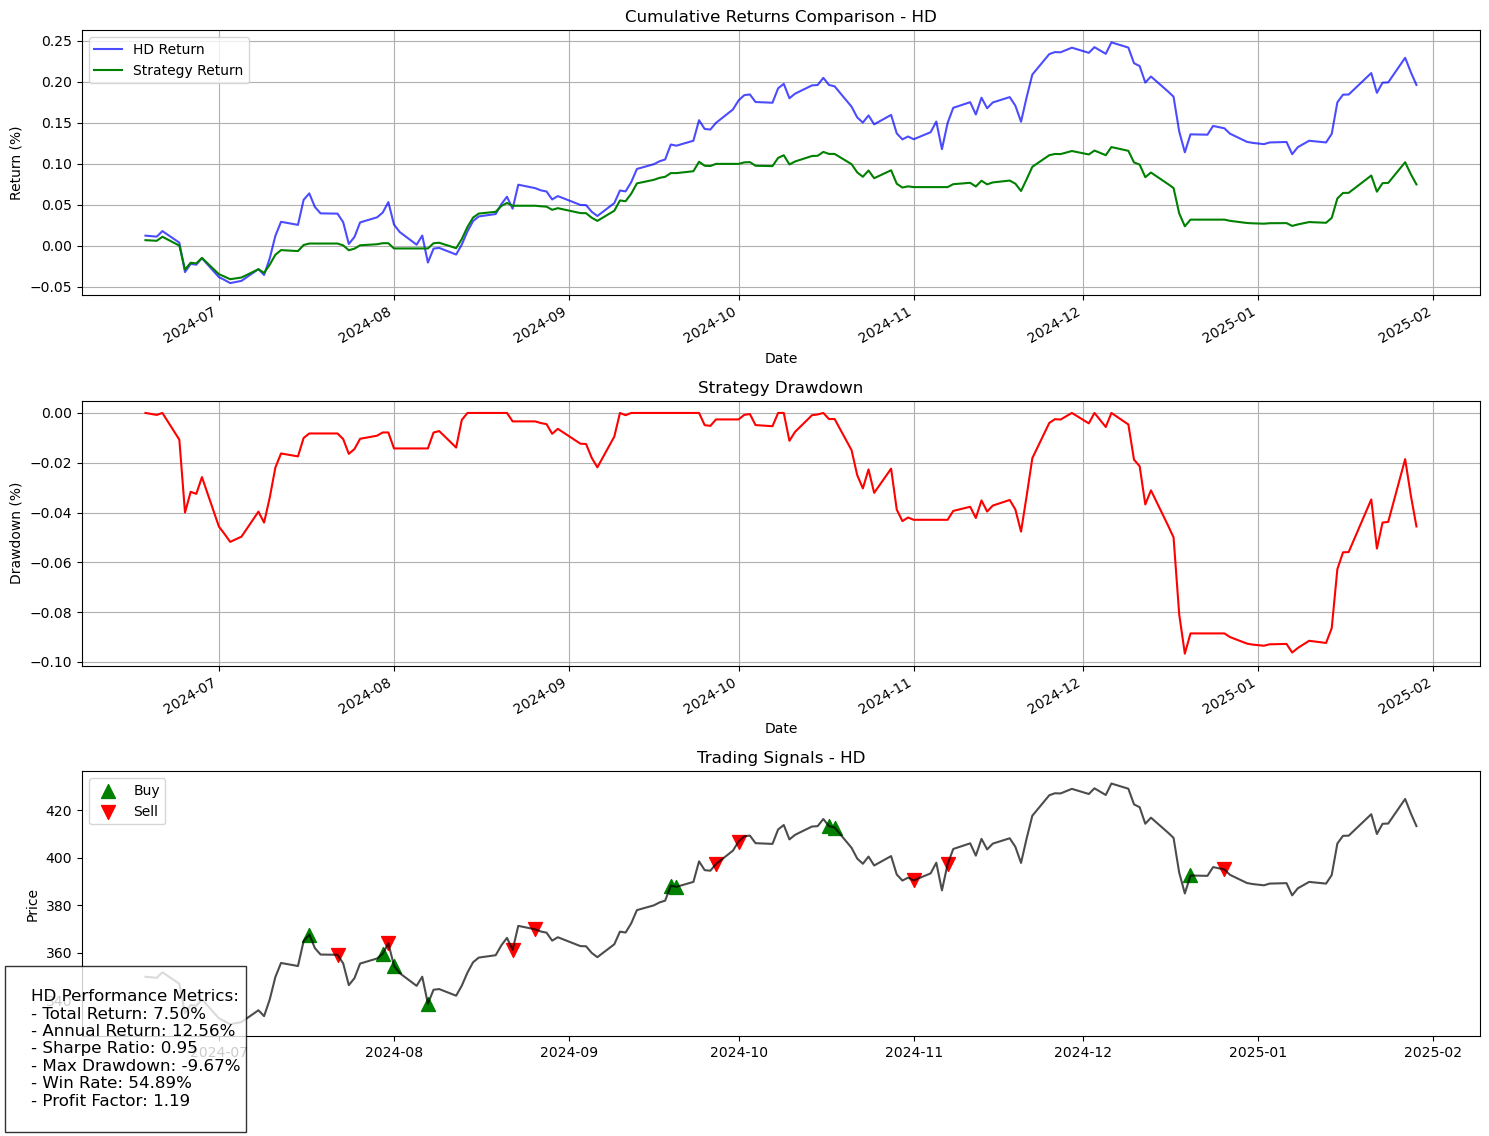

Entering position at 338.550048828125 on 2024-08-07 00:00:00
Take-profit triggered at 356.0213928222656 on 2024-08-15 00:00:00, return: 5.16%
Entering position at 357.989013671875 on 2024-08-16 00:00:00
Take-profit triggered at 377.99945068359375 on 2024-09-13 00:00:00, return: 5.59%
Entering position at 387.8177490234375 on 2024-09-20 00:00:00
Take-profit triggered at 409.1056518554688 on 2024-10-02 00:00:00, return: 5.49%
Entering position at 412.8260498046875 on 2024-10-18 00:00:00
Stop-loss triggered at 404.2710876464844 on 2024-10-21 00:00:00, return: -2.07%
Entering position at 399.7449645996094 on 2024-10-22 00:00:00
Stop-loss triggered at 390.46380615234375 on 2024-10-30 00:00:00, return: -2.32%
Entering position at 391.6873779296875 on 2024-10-31 00:00:00
Take-profit triggered at 417.79986572265625 on 2024-11-22 00:00:00, return: 6.67%

Performance Metrics HD: {'total_return': 0.07497821444290054, 'annual_return': 0.12559269675405127, 'sharpe_ratio': 0.9480296453165556, 'max_d

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 362ms/step - accuracy: 0.5046 - loss: 0.7959 - val_accuracy: 0.4379 - val_loss: 0.7007
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.5659 - loss: 0.6883 - val_accuracy: 0.3791 - val_loss: 0.7136
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.5433 - loss: 0.6880 - val_accuracy: 0.3856 - val_loss: 0.7115
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.5604 - loss: 0.6867 - val_accuracy: 0.3725 - val_loss: 0.7304
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.5586 - loss: 0.6858 - val_accuracy: 0.4510 - val_loss: 0.7063
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.5783 - loss: 0.6856 - val_accuracy: 0.4575 - val_loss: 0.6994
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5698 - loss: 0.6826 - val_accuracy: 0.4706 - val_loss: 0.7006
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5643 - loss: 0.6819 - val_accuracy: 0.4771 - val

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 933ms/step
Accuracy: 0.5097
Precision: 0.2598
Recall: 0.5097
F1 Score: 0.3441

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        79
           1       0.00      0.00      0.00        76

    accuracy                           0.51       155
   macro avg       0.25      0.50      0.34       155
weighted avg       0.26      0.51      0.34       155



c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\17034\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

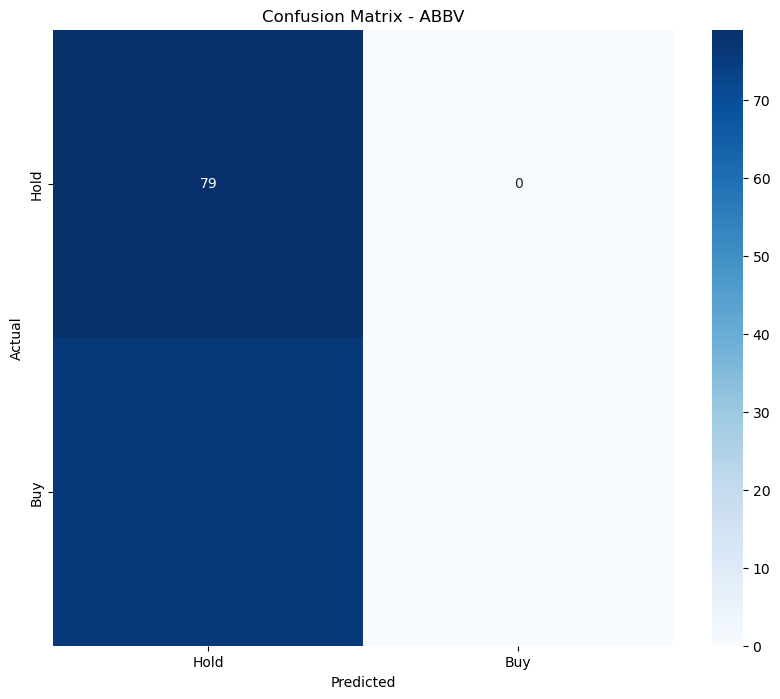

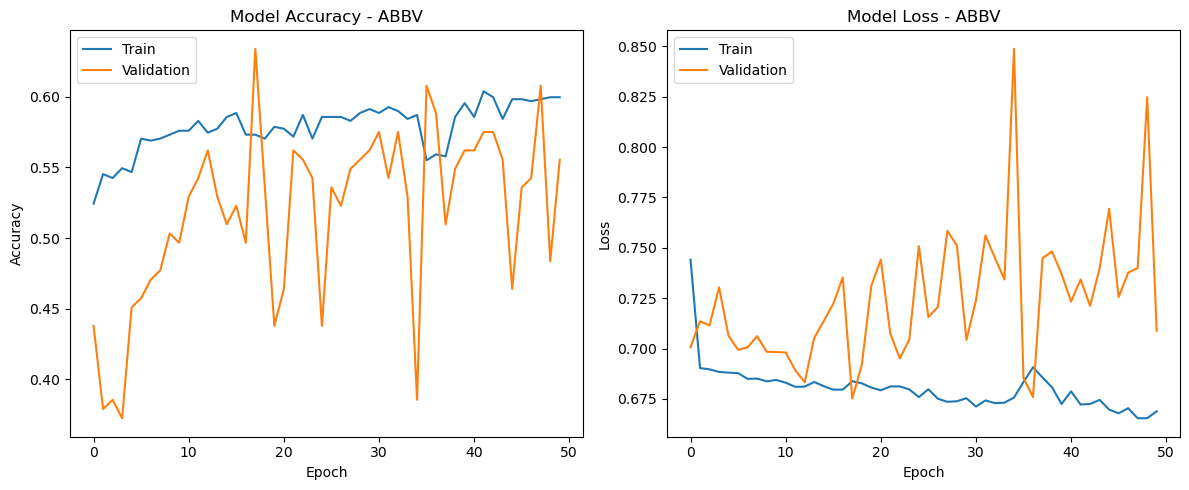

Generating trading signals...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


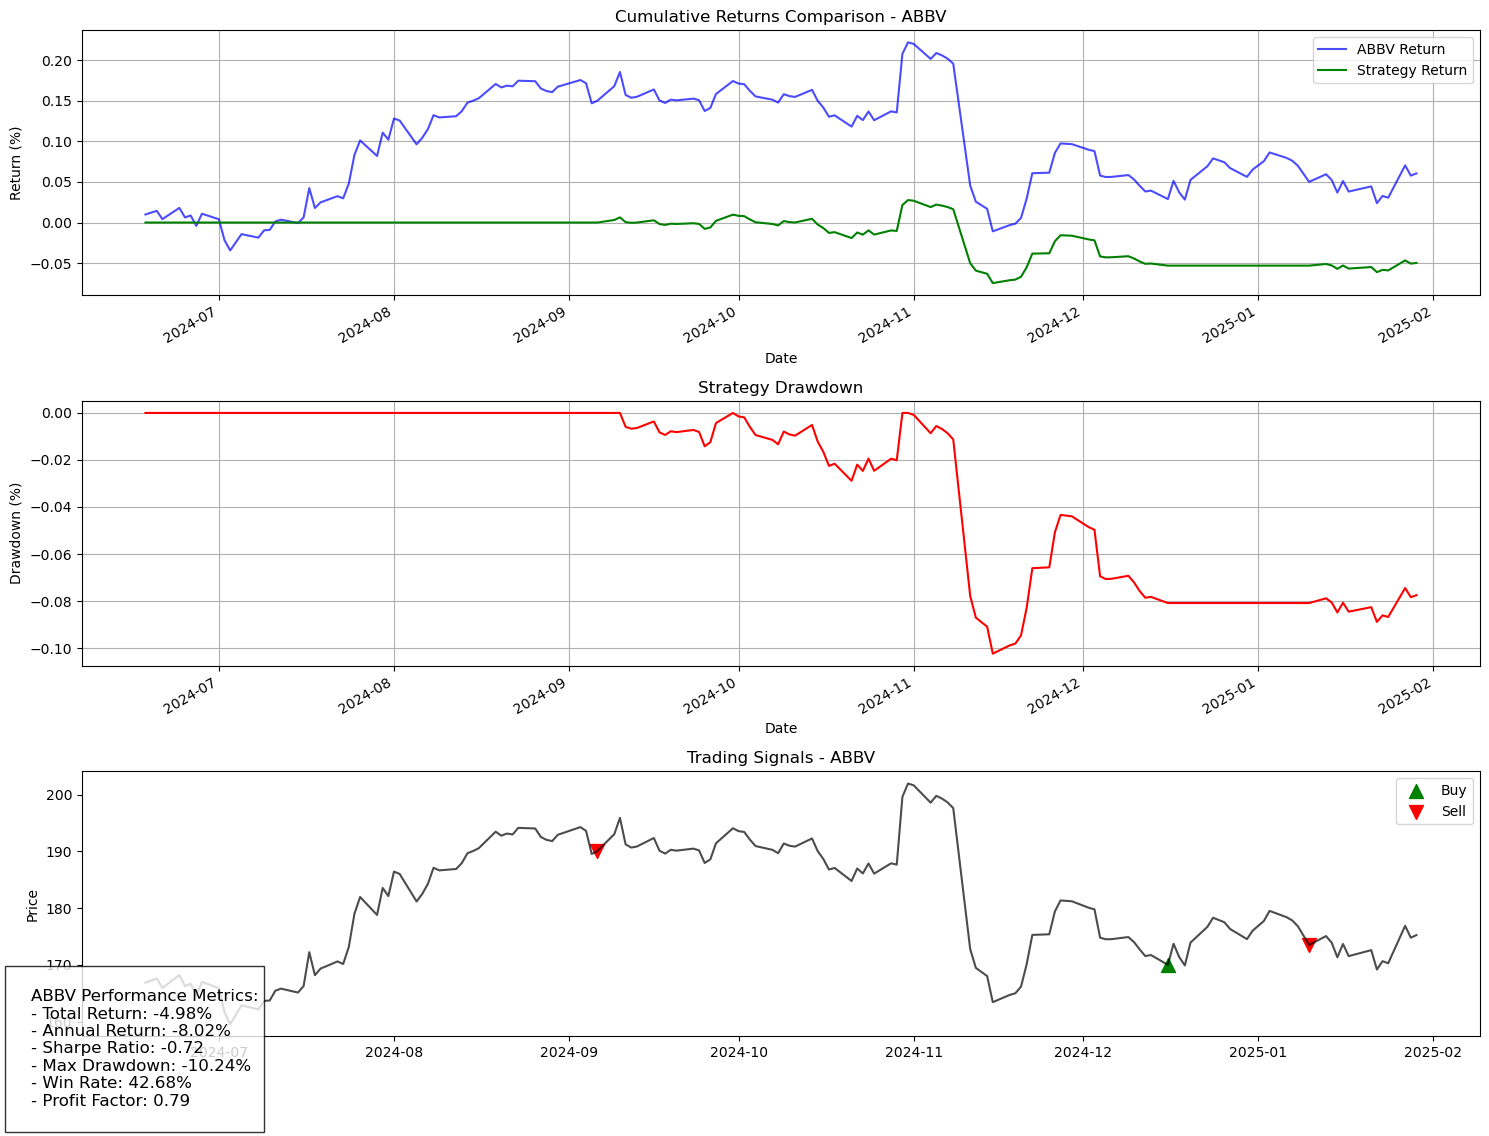


Performance Metrics ABBV: {'total_return': -0.049800710361305844, 'annual_return': -0.08019284377243674, 'sharpe_ratio': -0.7200276556464241, 'max_drawdown': -0.10238150204714791, 'win_rate': 0.4268292682926829, 'profit_factor': 0.7860129105489785, 'accuracy': 0.5096774193548387, 'precision': 0.25977107180020814, 'recall': 0.5096774193548387, 'f1_score': 0.34414116349600216}

Trades ABBV: {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0}
Processing BAC...
Top 15 features by mutual information:
             Feature  MI Score
14             MA_50  0.041449
30            RSI_25  0.038993
27       BB_Width_50  0.031213
41      Volume_Ratio  0.031016
34       Momentum_14  0.022007
6              EMA_5  0.021560
32       Signal_Line  0.020832
36            MFI_14  0.019206
7         Returns_5d  0.016173
54               VIX  0.015353
49       Forward_EPS  0.015061
38  Channel_Width_20  0.014279
35            ROC_14  0.014200
12            EMA_

c:\Users\17034\anaconda3\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 12, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4986 - loss: 0.7143 - val_accuracy: 0.4706 - val_loss: 0.6970
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.4997 - loss: 0.6956 - val_accuracy: 0.5294 - val_loss: 0.6916
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.4663 - loss: 0.6967 - val_accuracy: 0.5229 - val_loss: 0.6930
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.4794 - loss: 0.6892 - val_accuracy: 0.5294 - val_loss: 0.6921
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.5124 - loss: 0.6881 - val_accuracy: 0.4706 - val_loss: 0.6933
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.5217 - loss: 0.6984 - val_accuracy: 0.4706 - val_loss: 0.6939
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.5087 - loss: 0.6941 - val_accuracy: 0.5294 - val_loss: 0.6930
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.5390 - loss: 0.6935 - val_accuracy: 0.4706 - val

KeyboardInterrupt: 

In [37]:
# List of top 20 stock symbols
top_20_symbols = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'AVGO', 'TSLA',
                  'BRK.B', 'GOOG', 'JPM', 'LLY', 'V', 'COST', 'MA', 'UNH',
                  'NFLX', 'WMT', 'PG', 'JNJ', 'HD', 'ABBV', 'BAC', 'CRM']
#top_20_symbols = ['AAPL']
# Example usage
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
if __name__ == "__main__":
    for symbol in top_20_symbols:
        print(f"Processing {symbol}...")
        try:
            model, signals, performance,trades = run_trading_system(
                file_path='sp500_master_data.csv',
                symbol=symbol,
                seq_length=30,
                confidence_threshold=0.6,
                results_dir=results_dir
            )
            print(f"\nPerformance Metrics {symbol}:", performance)
            print(f"\nTrades {symbol}:", trades)
        except Exception as e:
            print(f"Error processing {symbol}: {e}")